# 1. Import Library yang diperlukan

In [1]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from bs4 import BeautifulSoup
import requests
import sqlite3
import csv
import os
from google.cloud import storage
import pandas_gbq
from dotenv import load_dotenv
from openai import OpenAI

# 2. ETL Pipeline Dataset 'project_data'

## 2.1 Extract Data

### 2.1.1 Extract Data 'project_data.csv'

In [2]:
df= pd.read_csv('../data_source/projects_data.csv', low_memory=False)

In [3]:
df

id                   regionname  \
0      P162228                        Other   
1      P163962                       Africa   
2      P167672                   South Asia   
3      P158768                   South Asia   
4      P161364                       Africa   
...        ...                          ...   
18243  P006578  Latin America and Caribbean   
18244  P037451      Europe and Central Asia   
18245  P037362      Europe and Central Asia   
18246  P037452      Europe and Central Asia   
18247  P037383      Europe and Central Asia   

                                             countryname prodline  \
0                                            World;World       RE   
1      Democratic Republic of the Congo;Democratic Re...       PE   
2      People's Republic of Bangladesh;People's Repub...       PE   
3      Islamic  Republic of Afghanistan;Islamic  Repu...       PE   
4      Federal Republic of Nigeria;Federal Republic o...       PE   
...                                                  ...      ...   
18243                Republic of Chile;Republic of Chile       PE   
18244  Grand Duchy of Luxembourg;Grand Duchy of Luxem...       PE   
18245              Kingdom of Denmark;Kingdom of Denmark       PE   
18246  Kingdom of the Netherlands;Kingdom of the Neth...       PE   
18247                    French Republic;French Republic       PE   

                       lendinginstr lendinginstrtype envassesmentcategorycode  \
0      Investment Project Financing               IN                        C   
1      Investment Project Financing               IN                        B   
2      Investment Project Financing               IN                      NaN   
3      Investment Project Financing               IN                        A   
4      Investment Project Financing               IN                        B   
...                             ...              ...                      ...   
18243      Specific Investment Loan               IN                      NaN   
18244    Structural Adjustment Loan               AD                      NaN   
18245    Structural Adjustment Loan               AD                      NaN   
18246    Structural Adjustment Loan               AD                      NaN   
18247    Structural Adjustment Loan               AD                      NaN   

      supplementprojectflg productlinetype projectstatusdisplay  ...  \
0                        N               L               Active  ...   
1                        N               L               Active  ...   
2                        Y               L               Active  ...   
3                        N               L               Active  ...   
4                        N               L               Active  ...   
...                    ...             ...                  ...  ...   
18243                    N               L               Closed  ...   
18244                    N               L               Closed  ...   
18245                    N               L               Closed  ...   
18246                    N               L               Closed  ...   
18247                    N               L               Closed  ...   

      mjtheme3name mjtheme4name mjtheme5name  \
0              NaN          NaN          NaN   
1              NaN          NaN          NaN   
2              NaN          NaN          NaN   
3              NaN          NaN          NaN   
4              NaN          NaN          NaN   
...            ...          ...          ...   
18243          NaN          NaN          NaN   
18244          NaN          NaN          NaN   
18245          NaN          NaN          NaN   
18246          NaN          NaN          NaN   
18247          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                      

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        18248 non-null  object 
 1   regionname                18248 non-null  object 
 2   countryname               18248 non-null  object 
 3   prodline                  18248 non-null  object 
 4   lendinginstr              18002 non-null  object 
 5   lendinginstrtype          18002 non-null  object 
 6   envassesmentcategorycode  12437 non-null  object 
 7   supplementprojectflg      18195 non-null  object 
 8   productlinetype           18248 non-null  object 
 9   projectstatusdisplay      18244 non-null  object 
 10  status                    18244 non-null  object 
 11  project_name              18248 non-null  object 
 12  boardapprovaldate         16744 non-null  object 
 13  board_approval_month      16744 non-null  object 
 14  closin

## 2.2 Transform Dataset 'project_data.csv'

### 2.2.1 Feature Engineering (Pilih Data)

In [5]:
column = ['id', 'regionname', 'countryname','status', 'project_name',
          'boardapprovaldate', 'closingdate', 'lendprojectcost', 'location']

df = df[column]
df

id                   regionname  \
0      P162228                        Other   
1      P163962                       Africa   
2      P167672                   South Asia   
3      P158768                   South Asia   
4      P161364                       Africa   
...        ...                          ...   
18243  P006578  Latin America and Caribbean   
18244  P037451      Europe and Central Asia   
18245  P037362      Europe and Central Asia   
18246  P037452      Europe and Central Asia   
18247  P037383      Europe and Central Asia   

                                             countryname  status  \
0                                            World;World  Active   
1      Democratic Republic of the Congo;Democratic Re...  Active   
2      People's Republic of Bangladesh;People's Repub...  Active   
3      Islamic  Republic of Afghanistan;Islamic  Repu...  Active   
4      Federal Republic of Nigeria;Federal Republic o...  Active   
...                                                  ...     ...   
18243                Republic of Chile;Republic of Chile  Closed   
18244  Grand Duchy of Luxembourg;Grand Duchy of Luxem...  Closed   
18245              Kingdom of Denmark;Kingdom of Denmark  Closed   
18246  Kingdom of the Netherlands;Kingdom of the Neth...  Closed   
18247                    French Republic;French Republic  Closed   

                                            project_name  \
0       Creating a Trade in Value-Added Database for ...   
1                           Productive Inclusion Project   
2      Additional Financing for Health Sector Support...   
3      Public-Private Partnerships and Public Investm...   
4                              Nigeria For Women Project   
...                                                  ...   
18243                       Power and Irrigation Project   
18244                     Steel Mill and Railway Project   
18245                    Post War Reconstruction Project   
18246                    Post-war Reconstruction Project   
18247                             Reconstruction Project   

          boardapprovaldate           closingdate lendprojectcost  \
0      2018-06-28T00:00:00Z                   NaN         500,000   
1      2018-06-28T00:00:00Z  2023-12-31T00:00:00Z     200,000,000   
2      2018-06-28T00:00:00Z                   NaN      50,000,000   
3      2018-06-27T00:00:00Z  2023-06-28T00:00:00Z      50,000,000   
4      2018-06-27T00:00:00Z  2023-05-31T00:00:00Z     100,000,000   
...                     ...                   ...             ...   
18243  1948-03-25T00:00:00Z  1954-12-31T00:00:00Z      13,500,000   
18244  1947-08-28T00:00:00Z  1949-03-31T00:00:00Z      12,000,000   
18245  1947-08-22T00:00:00Z  1949-03-31T00:00:00Z      40,000,000   
18246  1947-08-07T00:00:00Z  1948-06-30T00:00:00Z     195,000,000   
18247  1947-05-09T00:00:00Z  1947-12-31T00:00:00Z     250,000,000   

                                                location  
0                                                    NaN  
1                                                    NaN  
2                                                    NaN  
3                                                    NaN  
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...  
...                                                  ...  
18243                                                NaN  
18244                                                NaN  
18245                                                NaN  
18246                                                NaN  
18247                                                NaN  

[18248 rows x 9 columns]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 18248 non-null  object
 1   regionname         18248 non-null  object
 2   countryname        18248 non-null  object
 3   status             18244 non-null  object
 4   project_name       18248 non-null  object
 5   boardapprovaldate  16744 non-null  object
 6   closingdate        14899 non-null  object
 7   lendprojectcost    18123 non-null  object
 8   location           4326 non-null   object
dtypes: object(9)
memory usage: 1.3+ MB


In [7]:
df.head()

id  regionname                                        countryname  \
0  P162228       Other                                        World;World   
1  P163962      Africa  Democratic Republic of the Congo;Democratic Re...   
2  P167672  South Asia  People's Republic of Bangladesh;People's Repub...   
3  P158768  South Asia  Islamic  Republic of Afghanistan;Islamic  Repu...   
4  P161364      Africa  Federal Republic of Nigeria;Federal Republic o...   

   status                                       project_name  \
0  Active   Creating a Trade in Value-Added Database for ...   
1  Active                       Productive Inclusion Project   
2  Active  Additional Financing for Health Sector Support...   
3  Active  Public-Private Partnerships and Public Investm...   
4  Active                          Nigeria For Women Project   

      boardapprovaldate           closingdate lendprojectcost  \
0  2018-06-28T00:00:00Z                   NaN         500,000   
1  2018-06-28T00:00:00Z  2023-12-31T00:00:00Z     200,000,000   
2  2018-06-28T00:00:00Z                   NaN      50,000,000   
3  2018-06-27T00:00:00Z  2023-06-28T00:00:00Z      50,000,000   
4  2018-06-27T00:00:00Z  2023-05-31T00:00:00Z     100,000,000   

                                            location  
0                                                NaN  
1                                                NaN  
2                                                NaN  
3                                                NaN  
4  0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...

In [8]:
df.tail()

id                   regionname  \
18243  P006578  Latin America and Caribbean   
18244  P037451      Europe and Central Asia   
18245  P037362      Europe and Central Asia   
18246  P037452      Europe and Central Asia   
18247  P037383      Europe and Central Asia   

                                             countryname  status  \
18243                Republic of Chile;Republic of Chile  Closed   
18244  Grand Duchy of Luxembourg;Grand Duchy of Luxem...  Closed   
18245              Kingdom of Denmark;Kingdom of Denmark  Closed   
18246  Kingdom of the Netherlands;Kingdom of the Neth...  Closed   
18247                    French Republic;French Republic  Closed   

                          project_name     boardapprovaldate  \
18243     Power and Irrigation Project  1948-03-25T00:00:00Z   
18244   Steel Mill and Railway Project  1947-08-28T00:00:00Z   
18245  Post War Reconstruction Project  1947-08-22T00:00:00Z   
18246  Post-war Reconstruction Project  1947-08-07T00:00:00Z   
18247           Reconstruction Project  1947-05-09T00:00:00Z   

                closingdate lendprojectcost location  
18243  1954-12-31T00:00:00Z      13,500,000      NaN  
18244  1949-03-31T00:00:00Z      12,000,000      NaN  
18245  1949-03-31T00:00:00Z      40,000,000      NaN  
18246  1948-06-30T00:00:00Z     195,000,000      NaN  
18247  1947-12-31T00:00:00Z     250,000,000      NaN

### 2.2.2 Handle Missing Values

In [9]:
df = df.dropna()

In [10]:
df

id                    regionname  \
4     P161364                        Africa   
37    P154525                    South Asia   
47    P159712                    South Asia   
55    P164277         East Asia and Pacific   
56    P159692  Middle East and North Africa   
...       ...                           ...   
9152  P001177                        Africa   
9312  P000755                         Other   
9376  P034154                        Africa   
9609  P005920   Latin America and Caribbean   
9682  P049706  Middle East and North Africa   

                                            countryname  status  \
4     Federal Republic of Nigeria;Federal Republic o...  Active   
37                  Republic of India;Republic of India  Active   
47    Islamic Republic of Pakistan;Islamic Republic ...  Active   
55          Republic of Indonesia;Republic of Indonesia  Active   
56                  Lebanese Republic;Lebanese Republic  Active   
...                                                 ...     ...   
9152  Republic of Cote d'Ivoire;Republic of Cote d'I...  Closed   
9312                                        World;World  Closed   
9376                  State of Eritrea;State of Eritrea  Closed   
9609              Argentine Republic;Argentine Republic  Closed   
9682  Hashemite Kingdom of Jordan;Hashemite Kingdom ...  Closed   

                                           project_name     boardapprovaldate  \
4                             Nigeria For Women Project  2018-06-27T00:00:00Z   
37            Uttarakhand Workforce Development Project  2018-06-19T00:00:00Z   
47                           Sindh Solar Energy Project  2018-06-14T00:00:00Z   
55    Indonesia - Supporting Primary Health Care Reform  2018-06-13T00:00:00Z   
56             Land Administration System Modernization  2018-06-08T00:00:00Z   
...                                                 ...                   ...   
9152  Transport Sector Adjustment Investment Credit ...  1998-06-23T00:00:00Z   
9312                             ET ROAD SEC. DEV. PROG  1998-01-15T00:00:00Z   
9376                       Ports Rehabilitation Project  1997-11-18T00:00:00Z   
9609     Reduction of Ozone Project (Montreal Protocol)  1997-01-09T00:00:00Z   
9682                                JO: ODS PHASEOUT II  1996-10-06T00:00:00Z   

               closingdate lendprojectcost  \
4     2023-05-31T00:00:00Z     100,000,000   
37    2023-06-30T00:00:00Z      92,500,000   
47    2023-09-29T00:00:00Z     105,000,000   
55    2024-04-30T00:00:00Z  93,007,000,000   
56    2023-12-31T00:00:00Z      43,000,000   
...                    ...             ...   
9152  2011-08-31T00:00:00Z     754,000,000   
9312  2005-05-31T00:00:00Z               0   
9376  2011-12-31T00:00:00Z      36,600,000   
9609  2014-12-30T00:00:00Z      30,000,000   
9682  2012-12-31T00:00:00Z       3,800,000   

                                               location  
4     0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...  
37    0001253629!$!Uttarkashi!$!31!$!78.5!$!IN;00012...  
47    0001163570!$!Thatta District!$!24.49026!$!67.9...  
55    0001633791!$!Provinsi Nusa Tenggara Timur!$!-8...  
56      0000272103!$!Lebanon!$!33.83333!$!35.83333!$!LB  
...                                                 ...  
9152  0002288115!$!Grand-Bassam!$!5.2118001!$!-3.738...  
9312  0000331089!$!Melkasa!$!8.3999996!$!39.333328!$...  
9376  0000330546!$!Massawa!$!15.60811!$!39.474548!$!...  
9609  0003435910!$!Buenos Aires!$!-34.613152!$!-58.3...  
9682  0000250439!$!Muhafazat `Amman!$!31.583691!$!36...  

[3500 rows x 9 columns]

### 2.2.3 Handle Duplicates untuk Keseluruhan Kolom

In [11]:
df = df.drop_duplicates()

In [12]:
df

id                    regionname  \
4     P161364                        Africa   
37    P154525                    South Asia   
47    P159712                    South Asia   
55    P164277         East Asia and Pacific   
56    P159692  Middle East and North Africa   
...       ...                           ...   
9152  P001177                        Africa   
9312  P000755                         Other   
9376  P034154                        Africa   
9609  P005920   Latin America and Caribbean   
9682  P049706  Middle East and North Africa   

                                            countryname  status  \
4     Federal Republic of Nigeria;Federal Republic o...  Active   
37                  Republic of India;Republic of India  Active   
47    Islamic Republic of Pakistan;Islamic Republic ...  Active   
55          Republic of Indonesia;Republic of Indonesia  Active   
56                  Lebanese Republic;Lebanese Republic  Active   
...                                                 ...     ...   
9152  Republic of Cote d'Ivoire;Republic of Cote d'I...  Closed   
9312                                        World;World  Closed   
9376                  State of Eritrea;State of Eritrea  Closed   
9609              Argentine Republic;Argentine Republic  Closed   
9682  Hashemite Kingdom of Jordan;Hashemite Kingdom ...  Closed   

                                           project_name     boardapprovaldate  \
4                             Nigeria For Women Project  2018-06-27T00:00:00Z   
37            Uttarakhand Workforce Development Project  2018-06-19T00:00:00Z   
47                           Sindh Solar Energy Project  2018-06-14T00:00:00Z   
55    Indonesia - Supporting Primary Health Care Reform  2018-06-13T00:00:00Z   
56             Land Administration System Modernization  2018-06-08T00:00:00Z   
...                                                 ...                   ...   
9152  Transport Sector Adjustment Investment Credit ...  1998-06-23T00:00:00Z   
9312                             ET ROAD SEC. DEV. PROG  1998-01-15T00:00:00Z   
9376                       Ports Rehabilitation Project  1997-11-18T00:00:00Z   
9609     Reduction of Ozone Project (Montreal Protocol)  1997-01-09T00:00:00Z   
9682                                JO: ODS PHASEOUT II  1996-10-06T00:00:00Z   

               closingdate lendprojectcost  \
4     2023-05-31T00:00:00Z     100,000,000   
37    2023-06-30T00:00:00Z      92,500,000   
47    2023-09-29T00:00:00Z     105,000,000   
55    2024-04-30T00:00:00Z  93,007,000,000   
56    2023-12-31T00:00:00Z      43,000,000   
...                    ...             ...   
9152  2011-08-31T00:00:00Z     754,000,000   
9312  2005-05-31T00:00:00Z               0   
9376  2011-12-31T00:00:00Z      36,600,000   
9609  2014-12-30T00:00:00Z      30,000,000   
9682  2012-12-31T00:00:00Z       3,800,000   

                                               location  
4     0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...  
37    0001253629!$!Uttarkashi!$!31!$!78.5!$!IN;00012...  
47    0001163570!$!Thatta District!$!24.49026!$!67.9...  
55    0001633791!$!Provinsi Nusa Tenggara Timur!$!-8...  
56      0000272103!$!Lebanon!$!33.83333!$!35.83333!$!LB  
...                                                 ...  
9152  0002288115!$!Grand-Bassam!$!5.2118001!$!-3.738...  
9312  0000331089!$!Melkasa!$!8.3999996!$!39.333328!$...  
9376  0000330546!$!Massawa!$!15.60811!$!39.474548!$!...  
9609  0003435910!$!Buenos Aires!$!-34.613152!$!-58.3...  
9682  0000250439!$!Muhafazat `Amman!$!31.583691!$!36...  

[3500 rows x 9 columns]

### 2.2.4 Menyesuaikan Values dan Type Data untuk Date Time

In [13]:
# Membagi nilai yang dipisahkan oleh ';' dan mengambil nilai unik
df['countryname'] = df['countryname'].str.split(';').str[0]

In [14]:
df

id                    regionname                   countryname  \
4     P161364                        Africa   Federal Republic of Nigeria   
37    P154525                    South Asia             Republic of India   
47    P159712                    South Asia  Islamic Republic of Pakistan   
55    P164277         East Asia and Pacific         Republic of Indonesia   
56    P159692  Middle East and North Africa             Lebanese Republic   
...       ...                           ...                           ...   
9152  P001177                        Africa     Republic of Cote d'Ivoire   
9312  P000755                         Other                         World   
9376  P034154                        Africa              State of Eritrea   
9609  P005920   Latin America and Caribbean            Argentine Republic   
9682  P049706  Middle East and North Africa   Hashemite Kingdom of Jordan   

      status                                       project_name  \
4     Active                          Nigeria For Women Project   
37    Active          Uttarakhand Workforce Development Project   
47    Active                         Sindh Solar Energy Project   
55    Active  Indonesia - Supporting Primary Health Care Reform   
56    Active           Land Administration System Modernization   
...      ...                                                ...   
9152  Closed  Transport Sector Adjustment Investment Credit ...   
9312  Closed                             ET ROAD SEC. DEV. PROG   
9376  Closed                       Ports Rehabilitation Project   
9609  Closed     Reduction of Ozone Project (Montreal Protocol)   
9682  Closed                                JO: ODS PHASEOUT II   

         boardapprovaldate           closingdate lendprojectcost  \
4     2018-06-27T00:00:00Z  2023-05-31T00:00:00Z     100,000,000   
37    2018-06-19T00:00:00Z  2023-06-30T00:00:00Z      92,500,000   
47    2018-06-14T00:00:00Z  2023-09-29T00:00:00Z     105,000,000   
55    2018-06-13T00:00:00Z  2024-04-30T00:00:00Z  93,007,000,000   
56    2018-06-08T00:00:00Z  2023-12-31T00:00:00Z      43,000,000   
...                    ...                   ...             ...   
9152  1998-06-23T00:00:00Z  2011-08-31T00:00:00Z     754,000,000   
9312  1998-01-15T00:00:00Z  2005-05-31T00:00:00Z               0   
9376  1997-11-18T00:00:00Z  2011-12-31T00:00:00Z      36,600,000   
9609  1997-01-09T00:00:00Z  2014-12-30T00:00:00Z      30,000,000   
9682  1996-10-06T00:00:00Z  2012-12-31T00:00:00Z       3,800,000   

                                               location  
4     0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...  
37    0001253629!$!Uttarkashi!$!31!$!78.5!$!IN;00012...  
47    0001163570!$!Thatta District!$!24.49026!$!67.9...  
55    0001633791!$!Provinsi Nusa Tenggara Timur!$!-8...  
56      0000272103!$!Lebanon!$!33.83333!$!35.83333!$!LB  
...                                                 ...  
9152  0002288115!$!Grand-Bassam!$!5.2118001!$!-3.738...  
9312  0000331089!$!Melkasa!$!8.3999996!$!39.333328!$...  
9376  0000330546!$!Massawa!$!15.60811!$!39.474548!$!...  
9609  0003435910!$!Buenos Aires!$!-34.613152!$!-58.3...  
9682  0000250439!$!Muhafazat `Amman!$!31.583691!$!36...  

[3500 rows x 9 columns]

In [15]:
# Menghapus zona waktu 'Z' dan mengonversi ke dalam format datetime
df['boardapprovaldate'] = pd.to_datetime(df['boardapprovaldate'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S')
df['closingdate'] = pd.to_datetime(df['closingdate'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S')
df

id                    regionname                   countryname  \
4     P161364                        Africa   Federal Republic of Nigeria   
37    P154525                    South Asia             Republic of India   
47    P159712                    South Asia  Islamic Republic of Pakistan   
55    P164277         East Asia and Pacific         Republic of Indonesia   
56    P159692  Middle East and North Africa             Lebanese Republic   
...       ...                           ...                           ...   
9152  P001177                        Africa     Republic of Cote d'Ivoire   
9312  P000755                         Other                         World   
9376  P034154                        Africa              State of Eritrea   
9609  P005920   Latin America and Caribbean            Argentine Republic   
9682  P049706  Middle East and North Africa   Hashemite Kingdom of Jordan   

      status                                       project_name  \
4     Active                          Nigeria For Women Project   
37    Active          Uttarakhand Workforce Development Project   
47    Active                         Sindh Solar Energy Project   
55    Active  Indonesia - Supporting Primary Health Care Reform   
56    Active           Land Administration System Modernization   
...      ...                                                ...   
9152  Closed  Transport Sector Adjustment Investment Credit ...   
9312  Closed                             ET ROAD SEC. DEV. PROG   
9376  Closed                       Ports Rehabilitation Project   
9609  Closed     Reduction of Ozone Project (Montreal Protocol)   
9682  Closed                                JO: ODS PHASEOUT II   

     boardapprovaldate closingdate lendprojectcost  \
4           2018-06-27  2023-05-31     100,000,000   
37          2018-06-19  2023-06-30      92,500,000   
47          2018-06-14  2023-09-29     105,000,000   
55          2018-06-13  2024-04-30  93,007,000,000   
56          2018-06-08  2023-12-31      43,000,000   
...                ...         ...             ...   
9152        1998-06-23  2011-08-31     754,000,000   
9312        1998-01-15  2005-05-31               0   
9376        1997-11-18  2011-12-31      36,600,000   
9609        1997-01-09  2014-12-30      30,000,000   
9682        1996-10-06  2012-12-31       3,800,000   

                                               location  
4     0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...  
37    0001253629!$!Uttarkashi!$!31!$!78.5!$!IN;00012...  
47    0001163570!$!Thatta District!$!24.49026!$!67.9...  
55    0001633791!$!Provinsi Nusa Tenggara Timur!$!-8...  
56      0000272103!$!Lebanon!$!33.83333!$!35.83333!$!LB  
...                                                 ...  
9152  0002288115!$!Grand-Bassam!$!5.2118001!$!-3.738...  
9312  0000331089!$!Melkasa!$!8.3999996!$!39.333328!$...  
9376  0000330546!$!Massawa!$!15.60811!$!39.474548!$!...  
9609  0003435910!$!Buenos Aires!$!-34.613152!$!-58.3...  
9682  0000250439!$!Muhafazat `Amman!$!31.583691!$!36...  

[3500 rows x 9 columns]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3500 entries, 4 to 9682
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3500 non-null   object        
 1   regionname         3500 non-null   object        
 2   countryname        3500 non-null   object        
 3   status             3500 non-null   object        
 4   project_name       3500 non-null   object        
 5   boardapprovaldate  3500 non-null   datetime64[ns]
 6   closingdate        3500 non-null   datetime64[ns]
 7   lendprojectcost    3500 non-null   object        
 8   location           3500 non-null   object        
dtypes: datetime64[ns](2), object(7)
memory usage: 273.4+ KB


### 2.2.5 Dummies Variables

In [17]:
# Membuat variabel dummy untuk kolom kategorikal dengan tipe data integer (0 dan 1)
df_dummies = pd.get_dummies(df['status'], dtype=int)

# Menggabungkan variabel dummy dengan DataFrame asli
df = pd.concat([df, df_dummies], axis=1)

# Menghapus kolom 'status' yang tidak diperlukan lagi
df.drop('status', axis=1, inplace=True)
df

id                    regionname                   countryname  \
4     P161364                        Africa   Federal Republic of Nigeria   
37    P154525                    South Asia             Republic of India   
47    P159712                    South Asia  Islamic Republic of Pakistan   
55    P164277         East Asia and Pacific         Republic of Indonesia   
56    P159692  Middle East and North Africa             Lebanese Republic   
...       ...                           ...                           ...   
9152  P001177                        Africa     Republic of Cote d'Ivoire   
9312  P000755                         Other                         World   
9376  P034154                        Africa              State of Eritrea   
9609  P005920   Latin America and Caribbean            Argentine Republic   
9682  P049706  Middle East and North Africa   Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
4                             Nigeria For Women Project        2018-06-27   
37            Uttarakhand Workforce Development Project        2018-06-19   
47                           Sindh Solar Energy Project        2018-06-14   
55    Indonesia - Supporting Primary Health Care Reform        2018-06-13   
56             Land Administration System Modernization        2018-06-08   
...                                                 ...               ...   
9152  Transport Sector Adjustment Investment Credit ...        1998-06-23   
9312                             ET ROAD SEC. DEV. PROG        1998-01-15   
9376                       Ports Rehabilitation Project        1997-11-18   
9609     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
9682                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate lendprojectcost  \
4     2023-05-31     100,000,000   
37    2023-06-30      92,500,000   
47    2023-09-29     105,000,000   
55    2024-04-30  93,007,000,000   
56    2023-12-31      43,000,000   
...          ...             ...   
9152  2011-08-31     754,000,000   
9312  2005-05-31               0   
9376  2011-12-31      36,600,000   
9609  2014-12-30      30,000,000   
9682  2012-12-31       3,800,000   

                                               location  Active  Closed  
4     0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...       1       0  
37    0001253629!$!Uttarkashi!$!31!$!78.5!$!IN;00012...       1       0  
47    0001163570!$!Thatta District!$!24.49026!$!67.9...       1       0  
55    0001633791!$!Provinsi Nusa Tenggara Timur!$!-8...       1       0  
56      0000272103!$!Lebanon!$!33.83333!$!35.83333!$!LB       1       0  
...                                                 ...     ...     ...  
9152  0002288115!$!Grand-Bassam!$!5.2118001!$!-3.738...       0       1  
9312  0000331089!$!Melkasa!$!8.3999996!$!39.333328!$...       0       1  
9376  0000330546!$!Massawa!$!15.60811!$!39.474548!$!...       0       1  
9609  0003435910!$!Buenos Aires!$!-34.613152!$!-58.3...       0       1  
9682  0000250439!$!Muhafazat `Amman!$!31.583691!$!36...       0       1  

[3500 rows x 10 columns]

In [18]:
# Menghapus tanda koma dari nilai dalam kolom 'lendprojectcost'
df['lendprojectcost'] = df['lendprojectcost'].str.replace(',', '')

### 2.2.6 Cleansing Text Punctuation

In [19]:
def cleansing(text):
    # Hapus tanda baca kecuali ;
    punctuation_to_keep = ';'
    punctuation_to_remove = ''.join([p for p in string.punctuation if p != punctuation_to_keep])
    text = text.translate(str.maketrans('', '', punctuation_to_remove))

    text = text.strip()

    # Hapus dua karakter sebelum setiap tanda ';'
    text = re.sub(r'..;', ';', text)
    # Hapus dua karakter terakhir di akhir kalimat
    text = re.sub(r'.{2}$', '', text)
    text = text.encode('ascii', 'ignore').decode()  # Hapus emot/karakter
    text = re.sub(r'https*\S+', ' ', text)  # Remove URL
    text = re.sub(r'@\S+', ' ', text)  # Remove mentions
    text = re.sub(r'rt', ' ', text)  # Remove URL
    text = re.sub(r'#\S+', ' ', text)  # Remove Hashtags
    text = re.sub(r"'\w+", '', text)  # Hapus karakter
    text = re.sub(r'\s{2,}', ' ', text)  # Hapus spasi berlebih
    text = re.sub('rt', ' ', text)  # Hapus rt
    text = re.sub('[0-9]+', '', text)  # Case Folding: Removing Number
    text = re.sub(r"#", " <hash_tag> ", text)

    return text

df['location'] = df['location'].apply(lambda x:cleansing(x))
df

id                    regionname                   countryname  \
4     P161364                        Africa   Federal Republic of Nigeria   
37    P154525                    South Asia             Republic of India   
47    P159712                    South Asia  Islamic Republic of Pakistan   
55    P164277         East Asia and Pacific         Republic of Indonesia   
56    P159692  Middle East and North Africa             Lebanese Republic   
...       ...                           ...                           ...   
9152  P001177                        Africa     Republic of Cote d'Ivoire   
9312  P000755                         Other                         World   
9376  P034154                        Africa              State of Eritrea   
9609  P005920   Latin America and Caribbean            Argentine Republic   
9682  P049706  Middle East and North Africa   Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
4                             Nigeria For Women Project        2018-06-27   
37            Uttarakhand Workforce Development Project        2018-06-19   
47                           Sindh Solar Energy Project        2018-06-14   
55    Indonesia - Supporting Primary Health Care Reform        2018-06-13   
56             Land Administration System Modernization        2018-06-08   
...                                                 ...               ...   
9152  Transport Sector Adjustment Investment Credit ...        1998-06-23   
9312                             ET ROAD SEC. DEV. PROG        1998-01-15   
9376                       Ports Rehabilitation Project        1997-11-18   
9609     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
9682                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate lendprojectcost  \
4     2023-05-31       100000000   
37    2023-06-30        92500000   
47    2023-09-29       105000000   
55    2024-04-30     93007000000   
56    2023-12-31        43000000   
...          ...             ...   
9152  2011-08-31       754000000   
9312  2005-05-31               0   
9376  2011-12-31        36600000   
9609  2014-12-30        30000000   
9682  2012-12-31         3800000   

                                               location  Active  Closed  
4     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0  
37    Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0  
47    Thatta District;Thar Parkar District;Tando Muh...       1       0  
55    Provinsi Nusa Tenggara Timur;Provinsi Maluku;P...       1       0  
56                                              Lebanon       1       0  
...                                                 ...     ...     ...  
9152                       GrandBassam;Danane;Bondoukou       0       1  
9312  Melkasa;Lalibela;Annaculu;Adis Amba;Addis Abab...       0       1  
9376                        Massawa;Hirgigo;Assab Wedeb       0       1  
9609                                       Buenos Aires       0       1  
9682                              Muhafazat Amman;Amman       0       1  

[3500 rows x 10 columns]

### 2.2.7 Change Type Data

In [20]:
# Ubah tipe data kolom
df['id'] = df['id'].astype('category')
df['regionname'] = df['regionname'].astype('category')
df['countryname'] = df['countryname'].astype('category')
df['project_name'] = df['project_name'].astype('category')

df['lendprojectcost'] = df['lendprojectcost'].astype('float')
# Mengabaikan nilai 0 pada kolom 'lendprojectcost' dan mempertahankan tipe data float64
df = df[df['lendprojectcost'] != 0].astype({'lendprojectcost': 'float64'})

df['location'] = df['location'].astype('category')

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3486 entries, 4 to 9682
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3486 non-null   category      
 1   regionname         3486 non-null   category      
 2   countryname        3486 non-null   category      
 3   project_name       3486 non-null   category      
 4   boardapprovaldate  3486 non-null   datetime64[ns]
 5   closingdate        3486 non-null   datetime64[ns]
 6   lendprojectcost    3486 non-null   float64       
 7   location           3486 non-null   category      
 8   Active             3486 non-null   int32         
 9   Closed             3486 non-null   int32         
dtypes: category(5), datetime64[ns](2), float64(1), int32(2)
memory usage: 573.6 KB


### 2.2.8 Reset Index

In [22]:
# Mereset indeks baris
df = df.reset_index(drop=True)
df

id                    regionname                      countryname  \
0     P161364                        Africa      Federal Republic of Nigeria   
1     P154525                    South Asia                Republic of India   
2     P159712                    South Asia     Islamic Republic of Pakistan   
3     P164277         East Asia and Pacific            Republic of Indonesia   
4     P159692  Middle East and North Africa                Lebanese Republic   
...       ...                           ...                              ...   
3481  P041887                    South Asia  People's Republic of Bangladesh   
3482  P001177                        Africa        Republic of Cote d'Ivoire   
3483  P034154                        Africa                 State of Eritrea   
3484  P005920   Latin America and Caribbean               Argentine Republic   
3485  P049706  Middle East and North Africa      Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
0                             Nigeria For Women Project        2018-06-27   
1             Uttarakhand Workforce Development Project        2018-06-19   
2                            Sindh Solar Energy Project        2018-06-14   
3     Indonesia - Supporting Primary Health Care Reform        2018-06-13   
4              Land Administration System Modernization        2018-06-08   
...                                                 ...               ...   
3481                                 Municipal Services        1999-03-16   
3482  Transport Sector Adjustment Investment Credit ...        1998-06-23   
3483                       Ports Rehabilitation Project        1997-11-18   
3484     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
3485                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate  lendprojectcost  \
0     2023-05-31     1.000000e+08   
1     2023-06-30     9.250000e+07   
2     2023-09-29     1.050000e+08   
3     2024-04-30     9.300700e+10   
4     2023-12-31     4.300000e+07   
...          ...              ...   
3481  2012-06-30     2.000000e+08   
3482  2011-08-31     7.540000e+08   
3483  2011-12-31     3.660000e+07   
3484  2014-12-30     3.000000e+07   
3485  2012-12-31     3.800000e+06   

                                               location  Active  Closed  
0     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0  
1     Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0  
2     Thatta District;Thar Parkar District;Tando Muh...       1       0  
3     Provinsi Nusa Tenggara Timur;Provinsi Maluku;P...       1       0  
4                                               Lebanon       1       0  
...                                                 ...     ...     ...  
3481  Thakurgaon;Tungi;Sylhet;Godagari;Rajshahi;Pati...       0       1  
3482                       GrandBassam;Danane;Bondoukou       0       1  
3483                        Massawa;Hirgigo;Assab Wedeb       0       1  
3484                                       Buenos Aires       0       1  
3485                              Muhafazat Amman;Amman       0       1  

[3486 rows x 10 columns]

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3486 entries, 0 to 3485
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3486 non-null   category      
 1   regionname         3486 non-null   category      
 2   countryname        3486 non-null   category      
 3   project_name       3486 non-null   category      
 4   boardapprovaldate  3486 non-null   datetime64[ns]
 5   closingdate        3486 non-null   datetime64[ns]
 6   lendprojectcost    3486 non-null   float64       
 7   location           3486 non-null   category      
 8   Active             3486 non-null   int32         
 9   Closed             3486 non-null   int32         
dtypes: category(5), datetime64[ns](2), float64(1), int32(2)
memory usage: 546.5 KB


### 2.2.9 Visualisasi Outlier dan Handling Outliers

In [24]:
# Visualisasi
fig = px.scatter(df, y="lendprojectcost")
fig.show()

In [25]:
def remove_outliers(data, feature):
    # Menghitung kuartil pertama (Q1)
    q1 = data[feature].quantile(0.25)
    # Menghitung kuartil ketiga (Q3)
    q3 = data[feature].quantile(0.75)
    # Menghitung Rentang Interkuartil (IQR)
    IQR = q3 - q1
    # Menentukan batas bawah
    lower_limit = q1 - (1.5 * IQR)
    # Menentukan batas atas
    upper_limit = q3 + (1.5 * IQR)
    
    # Menampilkan batas bawah dan batas atas
    print(f"Batasan yang lebih rendah: {lower_limit} Batas atas: {upper_limit}")
    # Menampilkan nilai minimal dan maksimal
    print(f"Nilai Minimal: {data[feature].min()}   Nilai Maksimal: {data[feature].max()}")
    
    # Mengidentifikasi outlier
    outliers = data[(data[feature] < lower_limit) | (data[feature] > upper_limit)]
    
    # Menghapus outlier
    cleaned_data = data.drop(outliers.index)
    
    return cleaned_data

# Memanggil fungsi untuk menghapus outlier
project_data_df = remove_outliers(df, 'lendprojectcost')
project_data_df

Batasan yang lebih rendah: -184500000.0 Batas atas: 347500000.0
Nilai Minimal: 170000.0   Nilai Maksimal: 93007000000.0


id                    regionname                      countryname  \
0     P161364                        Africa      Federal Republic of Nigeria   
1     P154525                    South Asia                Republic of India   
2     P159712                    South Asia     Islamic Republic of Pakistan   
4     P159692  Middle East and North Africa                Lebanese Republic   
5     P165558  Middle East and North Africa             Republic of Djibouti   
...       ...                           ...                              ...   
3480  P006043   Latin America and Caribbean               Argentine Republic   
3481  P041887                    South Asia  People's Republic of Bangladesh   
3483  P034154                        Africa                 State of Eritrea   
3484  P005920   Latin America and Caribbean               Argentine Republic   
3485  P049706  Middle East and North Africa      Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
0                             Nigeria For Women Project        2018-06-27   
1             Uttarakhand Workforce Development Project        2018-06-19   
2                            Sindh Solar Energy Project        2018-06-14   
4              Land Administration System Modernization        2018-06-08   
5     Djibouti Support for Women and Youth Entrepren...        2018-06-08   
...                                                 ...               ...   
3480       Renewable Energy in the Rural Market Project        1999-03-30   
3481                                 Municipal Services        1999-03-16   
3483                       Ports Rehabilitation Project        1997-11-18   
3484     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
3485                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate  lendprojectcost  \
0     2023-05-31      100000000.0   
1     2023-06-30       92500000.0   
2     2023-09-29      105000000.0   
4     2023-12-31       43000000.0   
5     2023-12-31       15000000.0   
...          ...              ...   
3480  2012-12-31      120500000.0   
3481  2012-06-30      200000000.0   
3483  2011-12-31       36600000.0   
3484  2014-12-30       30000000.0   
3485  2012-12-31        3800000.0   

                                               location  Active  Closed  
0     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0  
1     Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0  
2     Thatta District;Thar Parkar District;Tando Muh...       1       0  
4                                               Lebanon       1       0  
5                                  Republic of Djibouti       1       0  
...                                                 ...     ...     ...  
3480  Provincia de Entre Ros;Provincia de Corrientes...       0       1  
3481  Thakurgaon;Tungi;Sylhet;Godagari;Rajshahi;Pati...       0       1  
3483                        Massawa;Hirgigo;Assab Wedeb       0       1  
3484                                       Buenos Aires       0       1  
3485                              Muhafazat Amman;Amman       0       1  

[3140 rows x 10 columns]

In [26]:
# Visualisasi Sesudah Outlier
fig = px.scatter(project_data_df, y="lendprojectcost")
fig.show()

In [27]:
project_data_df

id                    regionname                      countryname  \
0     P161364                        Africa      Federal Republic of Nigeria   
1     P154525                    South Asia                Republic of India   
2     P159712                    South Asia     Islamic Republic of Pakistan   
4     P159692  Middle East and North Africa                Lebanese Republic   
5     P165558  Middle East and North Africa             Republic of Djibouti   
...       ...                           ...                              ...   
3480  P006043   Latin America and Caribbean               Argentine Republic   
3481  P041887                    South Asia  People's Republic of Bangladesh   
3483  P034154                        Africa                 State of Eritrea   
3484  P005920   Latin America and Caribbean               Argentine Republic   
3485  P049706  Middle East and North Africa      Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
0                             Nigeria For Women Project        2018-06-27   
1             Uttarakhand Workforce Development Project        2018-06-19   
2                            Sindh Solar Energy Project        2018-06-14   
4              Land Administration System Modernization        2018-06-08   
5     Djibouti Support for Women and Youth Entrepren...        2018-06-08   
...                                                 ...               ...   
3480       Renewable Energy in the Rural Market Project        1999-03-30   
3481                                 Municipal Services        1999-03-16   
3483                       Ports Rehabilitation Project        1997-11-18   
3484     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
3485                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate  lendprojectcost  \
0     2023-05-31      100000000.0   
1     2023-06-30       92500000.0   
2     2023-09-29      105000000.0   
4     2023-12-31       43000000.0   
5     2023-12-31       15000000.0   
...          ...              ...   
3480  2012-12-31      120500000.0   
3481  2012-06-30      200000000.0   
3483  2011-12-31       36600000.0   
3484  2014-12-30       30000000.0   
3485  2012-12-31        3800000.0   

                                               location  Active  Closed  
0     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0  
1     Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0  
2     Thatta District;Thar Parkar District;Tando Muh...       1       0  
4                                               Lebanon       1       0  
5                                  Republic of Djibouti       1       0  
...                                                 ...     ...     ...  
3480  Provincia de Entre Ros;Provincia de Corrientes...       0       1  
3481  Thakurgaon;Tungi;Sylhet;Godagari;Rajshahi;Pati...       0       1  
3483                        Massawa;Hirgigo;Assab Wedeb       0       1  
3484                                       Buenos Aires       0       1  
3485                              Muhafazat Amman;Amman       0       1  

[3140 rows x 10 columns]

### 2.2.10 Scaling Features

In [28]:
# Inisialisasi MaxAbsScaler
scaler = MaxAbsScaler()

project_data_df_scaled = project_data_df.copy()
# Melakukan scaling fitur
project_data_df_scaled['lendprojectcost'] = scaler.fit_transform(project_data_df_scaled[['lendprojectcost']])
project_data_df_scaled

id                    regionname                      countryname  \
0     P161364                        Africa      Federal Republic of Nigeria   
1     P154525                    South Asia                Republic of India   
2     P159712                    South Asia     Islamic Republic of Pakistan   
4     P159692  Middle East and North Africa                Lebanese Republic   
5     P165558  Middle East and North Africa             Republic of Djibouti   
...       ...                           ...                              ...   
3480  P006043   Latin America and Caribbean               Argentine Republic   
3481  P041887                    South Asia  People's Republic of Bangladesh   
3483  P034154                        Africa                 State of Eritrea   
3484  P005920   Latin America and Caribbean               Argentine Republic   
3485  P049706  Middle East and North Africa      Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
0                             Nigeria For Women Project        2018-06-27   
1             Uttarakhand Workforce Development Project        2018-06-19   
2                            Sindh Solar Energy Project        2018-06-14   
4              Land Administration System Modernization        2018-06-08   
5     Djibouti Support for Women and Youth Entrepren...        2018-06-08   
...                                                 ...               ...   
3480       Renewable Energy in the Rural Market Project        1999-03-30   
3481                                 Municipal Services        1999-03-16   
3483                       Ports Rehabilitation Project        1997-11-18   
3484     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
3485                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate  lendprojectcost  \
0     2023-05-31         0.288659   
1     2023-06-30         0.267009   
2     2023-09-29         0.303092   
4     2023-12-31         0.124123   
5     2023-12-31         0.043299   
...          ...              ...   
3480  2012-12-31         0.347834   
3481  2012-06-30         0.577317   
3483  2011-12-31         0.105649   
3484  2014-12-30         0.086598   
3485  2012-12-31         0.010969   

                                               location  Active  Closed  
0     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0  
1     Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0  
2     Thatta District;Thar Parkar District;Tando Muh...       1       0  
4                                               Lebanon       1       0  
5                                  Republic of Djibouti       1       0  
...                                                 ...     ...     ...  
3480  Provincia de Entre Ros;Provincia de Corrientes...       0       1  
3481  Thakurgaon;Tungi;Sylhet;Godagari;Rajshahi;Pati...       0       1  
3483                        Massawa;Hirgigo;Assab Wedeb       0       1  
3484                                       Buenos Aires       0       1  
3485                              Muhafazat Amman;Amman       0       1  

[3140 rows x 10 columns]

### 2.2.11 Project Data untuk Load

In [29]:
df_project_data = pd.read_csv('../data_source/projects_data.csv', low_memory=False)
df_project_data

id                   regionname  \
0      P162228                        Other   
1      P163962                       Africa   
2      P167672                   South Asia   
3      P158768                   South Asia   
4      P161364                       Africa   
...        ...                          ...   
18243  P006578  Latin America and Caribbean   
18244  P037451      Europe and Central Asia   
18245  P037362      Europe and Central Asia   
18246  P037452      Europe and Central Asia   
18247  P037383      Europe and Central Asia   

                                             countryname prodline  \
0                                            World;World       RE   
1      Democratic Republic of the Congo;Democratic Re...       PE   
2      People's Republic of Bangladesh;People's Repub...       PE   
3      Islamic  Republic of Afghanistan;Islamic  Repu...       PE   
4      Federal Republic of Nigeria;Federal Republic o...       PE   
...                                                  ...      ...   
18243                Republic of Chile;Republic of Chile       PE   
18244  Grand Duchy of Luxembourg;Grand Duchy of Luxem...       PE   
18245              Kingdom of Denmark;Kingdom of Denmark       PE   
18246  Kingdom of the Netherlands;Kingdom of the Neth...       PE   
18247                    French Republic;French Republic       PE   

                       lendinginstr lendinginstrtype envassesmentcategorycode  \
0      Investment Project Financing               IN                        C   
1      Investment Project Financing               IN                        B   
2      Investment Project Financing               IN                      NaN   
3      Investment Project Financing               IN                        A   
4      Investment Project Financing               IN                        B   
...                             ...              ...                      ...   
18243      Specific Investment Loan               IN                      NaN   
18244    Structural Adjustment Loan               AD                      NaN   
18245    Structural Adjustment Loan               AD                      NaN   
18246    Structural Adjustment Loan               AD                      NaN   
18247    Structural Adjustment Loan               AD                      NaN   

      supplementprojectflg productlinetype projectstatusdisplay  ...  \
0                        N               L               Active  ...   
1                        N               L               Active  ...   
2                        Y               L               Active  ...   
3                        N               L               Active  ...   
4                        N               L               Active  ...   
...                    ...             ...                  ...  ...   
18243                    N               L               Closed  ...   
18244                    N               L               Closed  ...   
18245                    N               L               Closed  ...   
18246                    N               L               Closed  ...   
18247                    N               L               Closed  ...   

      mjtheme3name mjtheme4name mjtheme5name  \
0              NaN          NaN          NaN   
1              NaN          NaN          NaN   
2              NaN          NaN          NaN   
3              NaN          NaN          NaN   
4              NaN          NaN          NaN   
...            ...          ...          ...   
18243          NaN          NaN          NaN   
18244          NaN          NaN          NaN   
18245          NaN          NaN          NaN   
18246          NaN          NaN          NaN   
18247          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                      

##### a. Replace & Regex

In [30]:
# Membagi nilai yang dipisahkan oleh ';' dan mengambil nilai unik
df_project_data['countryname'] = df_project_data['countryname'].str.split(';').str[0]
df_project_data

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      prodline                  lendinginstr lendinginstrtype  \
0           RE  Investment Project Financing               IN   
1           PE  Investment Project Financing               IN   
2           PE  Investment Project Financing               IN   
3           PE  Investment Project Financing               IN   
4           PE  Investment Project Financing               IN   
...        ...                           ...              ...   
18243       PE      Specific Investment Loan               IN   
18244       PE    Structural Adjustment Loan               AD   
18245       PE    Structural Adjustment Loan               AD   
18246       PE    Structural Adjustment Loan               AD   
18247       PE    Structural Adjustment Loan               AD   

      envassesmentcategorycode supplementprojectflg productlinetype  \
0                            C                    N               L   
1                            B                    N               L   
2                          NaN                    Y               L   
3                            A                    N               L   
4                            B                    N               L   
...                        ...                  ...             ...   
18243                      NaN                    N               L   
18244                      NaN                    N               L   
18245                      NaN                    N               L   
18246                      NaN                    N               L   
18247                      NaN                    N               L   

      projectstatusdisplay  ... mjtheme3name mjtheme4name mjtheme5name  \
0                   Active  ...          NaN          NaN          NaN   
1                   Active  ...          NaN          NaN          NaN   
2                   Active  ...          NaN          NaN          NaN   
3                   Active  ...          NaN          NaN          NaN   
4                   Active  ...          NaN          NaN          NaN   
...                    ...  ...          ...          ...          ...   
18243               Closed  ...          NaN          NaN          NaN   
18244               Closed  ...          NaN          NaN          NaN   
18245               Closed  ...          NaN          NaN          NaN   
18246               Closed  ...          NaN          NaN          NaN   
18247               Closed  ...          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...   
...                                                  ...   
18243                                                NaN   
18244                               

##### b. Time Zone

In [31]:
# Menghapus zona waktu 'Z' dan mengonversi ke dalam format datetime
df_project_data['boardapprovaldate'] = pd.to_datetime(df_project_data['boardapprovaldate'].str.replace('Z', ''), format='%Y-%m-%dT%H:%M:%S')
df_project_data

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      prodline                  lendinginstr lendinginstrtype  \
0           RE  Investment Project Financing               IN   
1           PE  Investment Project Financing               IN   
2           PE  Investment Project Financing               IN   
3           PE  Investment Project Financing               IN   
4           PE  Investment Project Financing               IN   
...        ...                           ...              ...   
18243       PE      Specific Investment Loan               IN   
18244       PE    Structural Adjustment Loan               AD   
18245       PE    Structural Adjustment Loan               AD   
18246       PE    Structural Adjustment Loan               AD   
18247       PE    Structural Adjustment Loan               AD   

      envassesmentcategorycode supplementprojectflg productlinetype  \
0                            C                    N               L   
1                            B                    N               L   
2                          NaN                    Y               L   
3                            A                    N               L   
4                            B                    N               L   
...                        ...                  ...             ...   
18243                      NaN                    N               L   
18244                      NaN                    N               L   
18245                      NaN                    N               L   
18246                      NaN                    N               L   
18247                      NaN                    N               L   

      projectstatusdisplay  ... mjtheme3name mjtheme4name mjtheme5name  \
0                   Active  ...          NaN          NaN          NaN   
1                   Active  ...          NaN          NaN          NaN   
2                   Active  ...          NaN          NaN          NaN   
3                   Active  ...          NaN          NaN          NaN   
4                   Active  ...          NaN          NaN          NaN   
...                    ...  ...          ...          ...          ...   
18243               Closed  ...          NaN          NaN          NaN   
18244               Closed  ...          NaN          NaN          NaN   
18245               Closed  ...          NaN          NaN          NaN   
18246               Closed  ...          NaN          NaN          NaN   
18247               Closed  ...          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...   
...                                                  ...   
18243                                                NaN   
18244                               

In [32]:
df_project_data['boardapprovaldate'] = df_project_data['boardapprovaldate'].dt.year
df_project_data

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      prodline                  lendinginstr lendinginstrtype  \
0           RE  Investment Project Financing               IN   
1           PE  Investment Project Financing               IN   
2           PE  Investment Project Financing               IN   
3           PE  Investment Project Financing               IN   
4           PE  Investment Project Financing               IN   
...        ...                           ...              ...   
18243       PE      Specific Investment Loan               IN   
18244       PE    Structural Adjustment Loan               AD   
18245       PE    Structural Adjustment Loan               AD   
18246       PE    Structural Adjustment Loan               AD   
18247       PE    Structural Adjustment Loan               AD   

      envassesmentcategorycode supplementprojectflg productlinetype  \
0                            C                    N               L   
1                            B                    N               L   
2                          NaN                    Y               L   
3                            A                    N               L   
4                            B                    N               L   
...                        ...                  ...             ...   
18243                      NaN                    N               L   
18244                      NaN                    N               L   
18245                      NaN                    N               L   
18246                      NaN                    N               L   
18247                      NaN                    N               L   

      projectstatusdisplay  ... mjtheme3name mjtheme4name  mjtheme5name  \
0                   Active  ...          NaN          NaN           NaN   
1                   Active  ...          NaN          NaN           NaN   
2                   Active  ...          NaN          NaN           NaN   
3                   Active  ...          NaN          NaN           NaN   
4                   Active  ...          NaN          NaN           NaN   
...                    ...  ...          ...          ...           ...   
18243               Closed  ...          NaN          NaN           NaN   
18244               Closed  ...          NaN          NaN           NaN   
18245               Closed  ...          NaN          NaN           NaN   
18246               Closed  ...          NaN          NaN           NaN   
18247               Closed  ...          NaN          NaN           NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...   
...                                                  ...   
18243                                                NaN   
18244                   

In [33]:
df_project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        18248 non-null  object 
 1   regionname                18248 non-null  object 
 2   countryname               18248 non-null  object 
 3   prodline                  18248 non-null  object 
 4   lendinginstr              18002 non-null  object 
 5   lendinginstrtype          18002 non-null  object 
 6   envassesmentcategorycode  12437 non-null  object 
 7   supplementprojectflg      18195 non-null  object 
 8   productlinetype           18248 non-null  object 
 9   projectstatusdisplay      18244 non-null  object 
 10  status                    18244 non-null  object 
 11  project_name              18248 non-null  object 
 12  boardapprovaldate         16744 non-null  float64
 13  board_approval_month      16744 non-null  object 
 14  closin

In [34]:
columns_to_categorical = ['boardapprovaldate', 'countryname']
for column in columns_to_categorical:
    df_project_data[column] = df_project_data[column].astype('category')

df_project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        18248 non-null  object  
 1   regionname                18248 non-null  object  
 2   countryname               18248 non-null  category
 3   prodline                  18248 non-null  object  
 4   lendinginstr              18002 non-null  object  
 5   lendinginstrtype          18002 non-null  object  
 6   envassesmentcategorycode  12437 non-null  object  
 7   supplementprojectflg      18195 non-null  object  
 8   productlinetype           18248 non-null  object  
 9   projectstatusdisplay      18244 non-null  object  
 10  status                    18244 non-null  object  
 11  project_name              18248 non-null  object  
 12  boardapprovaldate         16744 non-null  category
 13  board_approval_month      16744 non-null  obje

In [35]:
# Menghapus tanda koma dari nilai dalam kolom 'lendprojectcost'
df_project_data['lendprojectcost'] = df_project_data['lendprojectcost'].str.replace(',', '')
df_project_data

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      prodline                  lendinginstr lendinginstrtype  \
0           RE  Investment Project Financing               IN   
1           PE  Investment Project Financing               IN   
2           PE  Investment Project Financing               IN   
3           PE  Investment Project Financing               IN   
4           PE  Investment Project Financing               IN   
...        ...                           ...              ...   
18243       PE      Specific Investment Loan               IN   
18244       PE    Structural Adjustment Loan               AD   
18245       PE    Structural Adjustment Loan               AD   
18246       PE    Structural Adjustment Loan               AD   
18247       PE    Structural Adjustment Loan               AD   

      envassesmentcategorycode supplementprojectflg productlinetype  \
0                            C                    N               L   
1                            B                    N               L   
2                          NaN                    Y               L   
3                            A                    N               L   
4                            B                    N               L   
...                        ...                  ...             ...   
18243                      NaN                    N               L   
18244                      NaN                    N               L   
18245                      NaN                    N               L   
18246                      NaN                    N               L   
18247                      NaN                    N               L   

      projectstatusdisplay  ... mjtheme3name mjtheme4name mjtheme5name  \
0                   Active  ...          NaN          NaN          NaN   
1                   Active  ...          NaN          NaN          NaN   
2                   Active  ...          NaN          NaN          NaN   
3                   Active  ...          NaN          NaN          NaN   
4                   Active  ...          NaN          NaN          NaN   
...                    ...  ...          ...          ...          ...   
18243               Closed  ...          NaN          NaN          NaN   
18244               Closed  ...          NaN          NaN          NaN   
18245               Closed  ...          NaN          NaN          NaN   
18246               Closed  ...          NaN          NaN          NaN   
18247               Closed  ...          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...   
...                                                  ...   
18243                                                NaN   
18244                               

In [36]:
df_project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        18248 non-null  object  
 1   regionname                18248 non-null  object  
 2   countryname               18248 non-null  category
 3   prodline                  18248 non-null  object  
 4   lendinginstr              18002 non-null  object  
 5   lendinginstrtype          18002 non-null  object  
 6   envassesmentcategorycode  12437 non-null  object  
 7   supplementprojectflg      18195 non-null  object  
 8   productlinetype           18248 non-null  object  
 9   projectstatusdisplay      18244 non-null  object  
 10  status                    18244 non-null  object  
 11  project_name              18248 non-null  object  
 12  boardapprovaldate         16744 non-null  category
 13  board_approval_month      16744 non-null  obje

In [37]:
# df_project_data = df_project_data.dropna()
# df_project_data.info()

In [38]:
df_project_data['lendprojectcost'] = df_project_data['lendprojectcost'].fillna(0)
df_project_data['lendprojectcost'] = df_project_data['lendprojectcost'].astype('int64')
df_project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 57 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        18248 non-null  object  
 1   regionname                18248 non-null  object  
 2   countryname               18248 non-null  category
 3   prodline                  18248 non-null  object  
 4   lendinginstr              18002 non-null  object  
 5   lendinginstrtype          18002 non-null  object  
 6   envassesmentcategorycode  12437 non-null  object  
 7   supplementprojectflg      18195 non-null  object  
 8   productlinetype           18248 non-null  object  
 9   projectstatusdisplay      18244 non-null  object  
 10  status                    18244 non-null  object  
 11  project_name              18248 non-null  object  
 12  boardapprovaldate         16744 non-null  category
 13  board_approval_month      16744 non-null  obje

In [39]:
df_project_data

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      prodline                  lendinginstr lendinginstrtype  \
0           RE  Investment Project Financing               IN   
1           PE  Investment Project Financing               IN   
2           PE  Investment Project Financing               IN   
3           PE  Investment Project Financing               IN   
4           PE  Investment Project Financing               IN   
...        ...                           ...              ...   
18243       PE      Specific Investment Loan               IN   
18244       PE    Structural Adjustment Loan               AD   
18245       PE    Structural Adjustment Loan               AD   
18246       PE    Structural Adjustment Loan               AD   
18247       PE    Structural Adjustment Loan               AD   

      envassesmentcategorycode supplementprojectflg productlinetype  \
0                            C                    N               L   
1                            B                    N               L   
2                          NaN                    Y               L   
3                            A                    N               L   
4                            B                    N               L   
...                        ...                  ...             ...   
18243                      NaN                    N               L   
18244                      NaN                    N               L   
18245                      NaN                    N               L   
18246                      NaN                    N               L   
18247                      NaN                    N               L   

      projectstatusdisplay  ... mjtheme3name mjtheme4name mjtheme5name  \
0                   Active  ...          NaN          NaN          NaN   
1                   Active  ...          NaN          NaN          NaN   
2                   Active  ...          NaN          NaN          NaN   
3                   Active  ...          NaN          NaN          NaN   
4                   Active  ...          NaN          NaN          NaN   
...                    ...  ...          ...          ...          ...   
18243               Closed  ...          NaN          NaN          NaN   
18244               Closed  ...          NaN          NaN          NaN   
18245               Closed  ...          NaN          NaN          NaN   
18246               Closed  ...          NaN          NaN          NaN   
18247               Closed  ...          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...   
...                                                  ...   
18243                                                NaN   
18244                               

In [40]:
# Mengonversi nilai dalam kolom boardapprovaldate menjadi string
df_project_data['boardapprovaldate'] = df_project_data['boardapprovaldate'].astype(str)

# Menghapus 2 karakter terakhir dari nilai dalam kolom boardapprovaldate
df_project_data['boardapprovaldate'] = df_project_data['boardapprovaldate'].str[:-2]
df_project_data

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      prodline                  lendinginstr lendinginstrtype  \
0           RE  Investment Project Financing               IN   
1           PE  Investment Project Financing               IN   
2           PE  Investment Project Financing               IN   
3           PE  Investment Project Financing               IN   
4           PE  Investment Project Financing               IN   
...        ...                           ...              ...   
18243       PE      Specific Investment Loan               IN   
18244       PE    Structural Adjustment Loan               AD   
18245       PE    Structural Adjustment Loan               AD   
18246       PE    Structural Adjustment Loan               AD   
18247       PE    Structural Adjustment Loan               AD   

      envassesmentcategorycode supplementprojectflg productlinetype  \
0                            C                    N               L   
1                            B                    N               L   
2                          NaN                    Y               L   
3                            A                    N               L   
4                            B                    N               L   
...                        ...                  ...             ...   
18243                      NaN                    N               L   
18244                      NaN                    N               L   
18245                      NaN                    N               L   
18246                      NaN                    N               L   
18247                      NaN                    N               L   

      projectstatusdisplay  ... mjtheme3name mjtheme4name mjtheme5name  \
0                   Active  ...          NaN          NaN          NaN   
1                   Active  ...          NaN          NaN          NaN   
2                   Active  ...          NaN          NaN          NaN   
3                   Active  ...          NaN          NaN          NaN   
4                   Active  ...          NaN          NaN          NaN   
...                    ...  ...          ...          ...          ...   
18243               Closed  ...          NaN          NaN          NaN   
18244               Closed  ...          NaN          NaN          NaN   
18245               Closed  ...          NaN          NaN          NaN   
18246               Closed  ...          NaN          NaN          NaN   
18247               Closed  ...          NaN          NaN          NaN   

                                                location  \
0                                                    NaN   
1                                                    NaN   
2                                                    NaN   
3                                                    NaN   
4      0002327546!$!Ogun State!$!7!$!3.58333!$!NG;000...   
...                                                  ...   
18243                                                NaN   
18244                               

# 3. ETL Pipeline Dataset 'population_data' all source

## 3.1 Extract Data

### 3.1.1 Extract Data

- df_1 = pop_data.csv
- df_2 = pop_data.db
- df_3 = pop_data.json
- df_4 = pop_data.xml
- df_5 = mystery.csv
- df_6 = API

#### 3.1.1.1 Connection to SQLite

In [41]:
conn = sqlite3.connect("../data_source/population_data.db")
cursor = conn.cursor()

query = "SELECT * FROM population_data"

df_2 = pd.read_sql(query, conn)

print(df_2.head())

conn.close()

   index Country_Name Country_Code     Indicator_Name Indicator_Code  \
0      0        Aruba          ABW  Population, total    SP.POP.TOTL   
1      1  Afghanistan          AFG  Population, total    SP.POP.TOTL   
2      2       Angola          AGO  Population, total    SP.POP.TOTL   
3      3      Albania          ALB  Population, total    SP.POP.TOTL   
4      4      Andorra          AND  Population, total    SP.POP.TOTL   

        1960       1961       1962       1963       1964  ...        2008  \
0    54211.0    55438.0    56225.0    56695.0    57032.0  ...    101353.0   
1  8996351.0  9166764.0  9345868.0  9533954.0  9731361.0  ...  27294031.0   
2  5643182.0  5753024.0  5866061.0  5980417.0  6093321.0  ...  21759420.0   
3  1608800.0  1659800.0  1711319.0  1762621.0  1814135.0  ...   2947314.0   
4    13411.0    14375.0    15370.0    16412.0    17469.0  ...     83861.0   

         2009        2010        2011        2012        2013        2014  \
0    101453.0    101669.0  

#### 3.1.1.2 Extract CSV

In [42]:
df_1 = pd.read_csv('../data_source/population_data.csv', skiprows=4) # Lewati empat baris pertama yang tidak berisi data


print("DATA CSV POPULATION")
df_1.head()

DATA CSV POPULATION


Country Name Country Code     Indicator Name Indicator Code       1960  \
0        Aruba          ABW  Population, total    SP.POP.TOTL    54211.0   
1  Afghanistan          AFG  Population, total    SP.POP.TOTL  8996351.0   
2       Angola          AGO  Population, total    SP.POP.TOTL  5643182.0   
3      Albania          ALB  Population, total    SP.POP.TOTL  1608800.0   
4      Andorra          AND  Population, total    SP.POP.TOTL    13411.0   

        1961       1962       1963       1964       1965  ...        2009  \
0    55438.0    56225.0    56695.0    57032.0    57360.0  ...    101453.0   
1  9166764.0  9345868.0  9533954.0  9731361.0  9938414.0  ...  28004331.0   
2  5753024.0  5866061.0  5980417.0  6093321.0  6203299.0  ...  22549547.0   
3  1659800.0  1711319.0  1762621.0  1814135.0  1864791.0  ...   2927519.0   
4    14375.0    15370.0    16412.0    17469.0    18549.0  ...     84462.0   

         2010        2011        2012        2013        2014        2015  \
0    101669.0    102053.0    102577.0    103187.0    103795.0    104341.0   
1  28803167.0  29708599.0  30696958.0  31731688.0  32758020.0  33736494.0   
2  23369131.0  24218565.0  25096150.0  25998340.0  26920466.0  27859305.0   
3   2913021.0   2905195.0   2900401.0   2895092.0   2889104.0   2880703.0   
4     84449.0     83751.0     82431.0     80788.0     79223.0     78014.0   

         2016        2017  Unnamed: 62  
0    104822.0    105264.0          NaN  
1  34656032.0  35530081.0          NaN  
2  28813463.0  29784193.0          NaN  
3   2876101.0   2873457.0          NaN  
4     77281.0     76965.0          NaN  

[5 rows x 63 columns]

In [43]:
df_5 = pd.read_csv('../data_source/mystery.csv', encoding='utf-16')

print("DATA CSV MYSTERY")
df_5.head()

DATA CSV MYSTERY


Unnamed: 0 Country Name Country Code     Indicator Name Indicator Code  \
0           0        Aruba          ABW  Population, total    SP.POP.TOTL   
1           1  Afghanistan          AFG  Population, total    SP.POP.TOTL   
2           2       Angola          AGO  Population, total    SP.POP.TOTL   
3           3      Albania          ALB  Population, total    SP.POP.TOTL   
4           4      Andorra          AND  Population, total    SP.POP.TOTL   

        1960       1961       1962       1963       1964  ...        2008  \
0    54211.0    55438.0    56225.0    56695.0    57032.0  ...    101353.0   
1  8996351.0  9166764.0  9345868.0  9533954.0  9731361.0  ...  27294031.0   
2  5643182.0  5753024.0  5866061.0  5980417.0  6093321.0  ...  21759420.0   
3  1608800.0  1659800.0  1711319.0  1762621.0  1814135.0  ...   2947314.0   
4    13411.0    14375.0    15370.0    16412.0    17469.0  ...     83861.0   

         2009        2010        2011        2012        2013        2014  \
0    101453.0    101669.0    102053.0    102577.0    103187.0    103795.0   
1  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0  32758020.0   
2  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0  26920466.0   
3   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   2889104.0   
4     84462.0     84449.0     83751.0     82431.0     80788.0     79223.0   

         2015        2016        2017  
0    104341.0    104822.0    105264.0  
1  33736494.0  34656032.0  35530081.0  
2  27859305.0  28813463.0  29784193.0  
3   2880703.0   2876101.0   2873457.0  
4     78014.0     77281.0     76965.0  

[5 rows x 63 columns]

In [44]:
print(df_5.columns)

Index(['Unnamed: 0', 'Country Name', 'Country Code', 'Indicator Name',
       'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')


In [45]:
df_5 = df_5.drop(columns=['Unnamed: 0'])
df_5

Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

           1961        1962        1963        1964        1965  ...  \
0       55438.0     56225.0     56695.0     57032.0     57360.0  ...   
1     9166764.0   9345868.0   9533954.0   9731361.0   9938414.0  ...   
2     5753024.0   5866061.0   5980417.0   6093321.0   6203299.0  ...   
3     1659800.0   1711319.0   1762621.0   1814135.0   1864791.0  ...   
4       14375.0     15370.0     16412.0     17469.0     18549.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    966000.0    994000.0   1022000.0   1050000.0   1078000.0  ...   
260   5260501.0   5351799.0   5446063.0   5543339.0   5643643.0  ...   
261  17920673.0  18401608.0  18899275.0  19412975.0  19942303.0  ...   
262   3140264.0   3240587.0   3345145.0   3452942.0   3563407.0  ...   
263   3870756.0   3999419.0   4132756.0   4269863.0   4410212.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 62 columns]

#### 3.1.1.3 Extraxt DB

In [46]:
df_2.rename(columns={
    'Country_Name': 'Country Name',
    'Country_Code': 'Country Code',
    'Indicator_Name': 'Indicator Name',
    'Indicator_Code': 'Indicator Code'
}, inplace=True)
df_2.columns.name = None

df_2

index  Country Name Country Code     Indicator Name Indicator Code  \
0        0         Aruba          ABW  Population, total    SP.POP.TOTL   
1        1   Afghanistan          AFG  Population, total    SP.POP.TOTL   
2        2        Angola          AGO  Population, total    SP.POP.TOTL   
3        3       Albania          ALB  Population, total    SP.POP.TOTL   
4        4       Andorra          AND  Population, total    SP.POP.TOTL   
..     ...           ...          ...                ...            ...   
259    259        Kosovo          XKX  Population, total    SP.POP.TOTL   
260    260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   
261    261  South Africa          ZAF  Population, total    SP.POP.TOTL   
262    262        Zambia          ZMB  Population, total    SP.POP.TOTL   
263    263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   

           1960        1961        1962        1963        1964  ...  \
0       54211.0     55438.0     56225.0     56695.0     57032.0  ...   
1     8996351.0   9166764.0   9345868.0   9533954.0   9731361.0  ...   
2     5643182.0   5753024.0   5866061.0   5980417.0   6093321.0  ...   
3     1608800.0   1659800.0   1711319.0   1762621.0   1814135.0  ...   
4       13411.0     14375.0     15370.0     16412.0     17469.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    947000.0    966000.0    994000.0   1022000.0   1050000.0  ...   
260   5172135.0   5260501.0   5351799.0   5446063.0   5543339.0  ...   
261  17456855.0  17920673.0  18401608.0  18899275.0  19412975.0  ...   
262   3044846.0   3140264.0   3240587.0   3345145.0   3452942.0  ...   
263   3747369.0   3870756.0   3999419.0   4132756.0   4269863.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 63 columns]

In [47]:
print("DATA DB")
df_2

DATA DB


index  Country Name Country Code     Indicator Name Indicator Code  \
0        0         Aruba          ABW  Population, total    SP.POP.TOTL   
1        1   Afghanistan          AFG  Population, total    SP.POP.TOTL   
2        2        Angola          AGO  Population, total    SP.POP.TOTL   
3        3       Albania          ALB  Population, total    SP.POP.TOTL   
4        4       Andorra          AND  Population, total    SP.POP.TOTL   
..     ...           ...          ...                ...            ...   
259    259        Kosovo          XKX  Population, total    SP.POP.TOTL   
260    260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   
261    261  South Africa          ZAF  Population, total    SP.POP.TOTL   
262    262        Zambia          ZMB  Population, total    SP.POP.TOTL   
263    263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   

           1960        1961        1962        1963        1964  ...  \
0       54211.0     55438.0     56225.0     56695.0     57032.0  ...   
1     8996351.0   9166764.0   9345868.0   9533954.0   9731361.0  ...   
2     5643182.0   5753024.0   5866061.0   5980417.0   6093321.0  ...   
3     1608800.0   1659800.0   1711319.0   1762621.0   1814135.0  ...   
4       13411.0     14375.0     15370.0     16412.0     17469.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    947000.0    966000.0    994000.0   1022000.0   1050000.0  ...   
260   5172135.0   5260501.0   5351799.0   5446063.0   5543339.0  ...   
261  17456855.0  17920673.0  18401608.0  18899275.0  19412975.0  ...   
262   3044846.0   3140264.0   3240587.0   3345145.0   3452942.0  ...   
263   3747369.0   3870756.0   3999419.0   4132756.0   4269863.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 63 columns]

In [48]:
df_2.columns

Index(['index', 'Country Name', 'Country Code', 'Indicator Name',
       'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965',
       '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974',
       '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983',
       '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992',
       '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001',
       '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010',
       '2011', '2012', '2013', '2014', '2015', '2016', '2017'],
      dtype='object')

In [49]:
df_2 = df_2.drop(columns=['index'])
df_2

Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

           1961        1962        1963        1964        1965  ...  \
0       55438.0     56225.0     56695.0     57032.0     57360.0  ...   
1     9166764.0   9345868.0   9533954.0   9731361.0   9938414.0  ...   
2     5753024.0   5866061.0   5980417.0   6093321.0   6203299.0  ...   
3     1659800.0   1711319.0   1762621.0   1814135.0   1864791.0  ...   
4       14375.0     15370.0     16412.0     17469.0     18549.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    966000.0    994000.0   1022000.0   1050000.0   1078000.0  ...   
260   5260501.0   5351799.0   5446063.0   5543339.0   5643643.0  ...   
261  17920673.0  18401608.0  18899275.0  19412975.0  19942303.0  ...   
262   3140264.0   3240587.0   3345145.0   3452942.0   3563407.0  ...   
263   3870756.0   3999419.0   4132756.0   4269863.0   4410212.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 62 columns]

#### 3.1.1.4 Extract JSON

In [50]:
df_3 = pd.read_json('../data_source/population_data.json')

print("DATA JSON")
df_3.head()

DATA JSON


Country Name Country Code     Indicator Name Indicator Code       1960  \
0        Aruba          ABW  Population, total    SP.POP.TOTL    54211.0   
1  Afghanistan          AFG  Population, total    SP.POP.TOTL  8996351.0   
2       Angola          AGO  Population, total    SP.POP.TOTL  5643182.0   
3      Albania          ALB  Population, total    SP.POP.TOTL  1608800.0   
4      Andorra          AND  Population, total    SP.POP.TOTL    13411.0   

        1961       1962       1963       1964       1965  ...        2008  \
0    55438.0    56225.0    56695.0    57032.0    57360.0  ...    101353.0   
1  9166764.0  9345868.0  9533954.0  9731361.0  9938414.0  ...  27294031.0   
2  5753024.0  5866061.0  5980417.0  6093321.0  6203299.0  ...  21759420.0   
3  1659800.0  1711319.0  1762621.0  1814135.0  1864791.0  ...   2947314.0   
4    14375.0    15370.0    16412.0    17469.0    18549.0  ...     83861.0   

         2009        2010        2011        2012        2013        2014  \
0    101453.0    101669.0    102053.0    102577.0    103187.0    103795.0   
1  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0  32758020.0   
2  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0  26920466.0   
3   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   2889104.0   
4     84462.0     84449.0     83751.0     82431.0     80788.0     79223.0   

         2015        2016        2017  
0    104341.0    104822.0    105264.0  
1  33736494.0  34656032.0  35530081.0  
2  27859305.0  28813463.0  29784193.0  
3   2880703.0   2876101.0   2873457.0  
4     78014.0     77281.0     76965.0  

[5 rows x 62 columns]

#### 3.1.1.5 Extract XML

In [51]:
with open("../data_source/population_data.xml", "r") as f:
    population_data_xml = f.read()

soup_population_data_xml = BeautifulSoup(population_data_xml, "lxml")

data = []

for record in soup_population_data_xml.find_all("record"):
    record_data = {}

    for field in record.find_all("field"):
        name = field.get("name")
        key = field.get("key")
        value = field.text

        if name == "Country or Area":
            record_data["Country Name"] = value
            record_data["Country Code"] = key
        elif name == "Item":
            record_data["Indicator Name"] = value
            record_data["Indicator Code"] = key
        else:
            record_data[name] = value

    data.append(record_data)

df_4 = pd.DataFrame(data)

print("DATA XML")
df_4

DATA XML


Country Name Country Code     Indicator Name Indicator Code  Year  \
0            Aruba          ABW  Population, total    SP.POP.TOTL  1960   
1            Aruba          ABW  Population, total    SP.POP.TOTL  1961   
2            Aruba          ABW  Population, total    SP.POP.TOTL  1962   
3            Aruba          ABW  Population, total    SP.POP.TOTL  1963   
4            Aruba          ABW  Population, total    SP.POP.TOTL  1964   
...            ...          ...                ...            ...   ...   
15307     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2013   
15308     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2014   
15309     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2015   
15310     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2016   
15311     Zimbabwe          ZWE  Population, total    SP.POP.TOTL  2017   

          Value  
0         54211  
1         55438  
2         56225  
3         56695  
4         57032  
...         ...  
15307  15054506  
15308  15411675  
15309  15777451  
15310  16150362  
15311  16529904  

[15312 rows x 6 columns]

In [52]:
print(df_4.columns)

Index(['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code',
       'Year', 'Value'],
      dtype='object')


In [53]:
# Konversi tipe data kolom 'Value' menjadi numerik jika diperlukan
df_4['Value'] = pd.to_numeric(df_4['Value'], errors='coerce')

# Membuat pivot table
df_4 = df_4.pivot_table(index=['Country Name', 'Country Code',
                                    'Indicator Name', 'Indicator Code'],
                             columns='Year', values='Value').reset_index()
df_4.columns.name = None
df_4

Country Name Country Code     Indicator Name Indicator Code  \
0           Afghanistan          AFG  Population, total    SP.POP.TOTL   
1               Albania          ALB  Population, total    SP.POP.TOTL   
2               Algeria          DZA  Population, total    SP.POP.TOTL   
3        American Samoa          ASM  Population, total    SP.POP.TOTL   
4               Andorra          AND  Population, total    SP.POP.TOTL   
..                  ...          ...                ...            ...   
258  West Bank and Gaza          PSE  Population, total    SP.POP.TOTL   
259               World          WLD  Population, total    SP.POP.TOTL   
260         Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   
261              Zambia          ZMB  Population, total    SP.POP.TOTL   
262            Zimbabwe          ZWE  Population, total    SP.POP.TOTL   

             1960          1961          1962          1963          1964  \
0    8.996351e+06  9.166764e+06  9.345868e+06  9.533954e+06  9.731361e+06   
1    1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06  1.814135e+06   
2    1.112489e+07  1.140486e+07  1.169015e+07  1.198514e+07  1.229597e+07   
3    2.001300e+04  2.048600e+04  2.111700e+04  2.188200e+04  2.269800e+04   
4    1.341100e+04  1.437500e+04  1.537000e+04  1.641200e+04  1.746900e+04   
..            ...           ...           ...           ...           ...   
258           NaN           NaN           NaN           NaN           NaN   
259  3.032160e+09  3.073369e+09  3.126510e+09  3.191786e+09  3.257460e+09   
260  5.172135e+06  5.260501e+06  5.351799e+06  5.446063e+06  5.543339e+06   
261  3.044846e+06  3.140264e+06  3.240587e+06  3.345145e+06  3.452942e+06   
262  3.747369e+06  3.870756e+06  3.999419e+06  4.132756e+06  4.269863e+06   

             1965  ...          2008          2009          2010  \
0    9.938414e+06  ...  2.729403e+07  2.800433e+07  2.880317e+07   
1    1.864791e+06  ...  2.947314e+06  2.927519e+06  2.913021e+06   
2    1.262695e+07  ...  3.486072e+07  3.546576e+07  3.611764e+07   
3    2.352000e+04  ...  5.703000e+04  5.622700e+04  5.563700e+04   
4    1.854900e+04  ...  8.386100e+04  8.446200e+04  8.444900e+04   
..            ...  ...           ...           ...           ...   
258           NaN  ...  3.596688e+06  3.702218e+06  3.811102e+06   
259  3.324545e+09  ...  6.766297e+09  6.849569e+09  6.932870e+09   
260  5.643643e+06  ...  2.235639e+07  2.297493e+07  2.360678e+07   
261  3.563407e+06  ...  1.308252e+07  1.345642e+07  1.385003e+07   
262  4.410212e+06  ...  1.355847e+07  1.381060e+07  1.408632e+07   

             2011          2012          2013          2014          2015  \
0    2.970860e+07  3.069696e+07  3.173169e+07  3.275802e+07  3.373649e+07   
1    2.905195e+06  2.900401e+06  2.895092e+06  2.889104e+06  2.880703e+06   
2    3.681956e+07  3.756585e+07  3.833856e+07  3.911331e+07  3.987153e+07   
3    5.532000e+04  5.523000e+04  5.530700e+04  5.543700e+04  5.553700e+04   
4    8.375100e+04  8.243100e+04  8.078800e+04  7.922300e+04  7.801400e+04   
..            ...           ...           ...           ...           ...   
258  3.927051e+06  4.046901e+06  4.169506e+06  4.294682e+06  4.422143e+06   
259  7.014984e+09  7.099558e+09  7.185138e+09  7.271323e+09  7.357559e+09   
260  2.425221e+07  2.490997e+07  2.557632e+07  2.624633e+07  2.691621e+07   
261  1.426476e+07  1.469994e+07  1.515321e+07  1.562097e+07  1.610059e+07   
262  1.438665e+07  1.471083e+07  1.505451e+07  1.541168e+07  1.577745e+07   

             2016          2017  
0    3.465603e+07  3.553008e+07  
1    2.876101e+06  2.873457e+06  
2    4.060605e+07  4.131814e+07  
3    5.559900e+04  5.564100e+04  
4    7.728100e+04  7.696500e+04  
..            ...           ...  
258  4.551566e+06  4.684777e+06  
259  7.444157e+09  7.530360e+09  
260  2.758421e+07  2.825042e+07  
261  1.659139e+07  1.709413e+07  
262  1.615036e+07  1.652990e+07  

[263 rows x 62 columns]

#### 3.1.1.6 Extract API

In [54]:
url = "https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json&per_page=30000"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()[1]  # Memilih bagian data dari JSON
    df_6 = pd.DataFrame(data)
    columns = ['country.value', 'countryiso3code', 'indicator.id', 'indicator.value', 'date', 'value']
    df_6 = pd.json_normalize(data)[columns]
    df_6.columns = ['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name', 'Year', 'Population']

else:
    print("Error:", response.status_code)
    
df_6

Country Name Country Code Indicator Code  \
0      Africa Eastern and Southern          AFE    SP.POP.TOTL   
1      Africa Eastern and Southern          AFE    SP.POP.TOTL   
2      Africa Eastern and Southern          AFE    SP.POP.TOTL   
3      Africa Eastern and Southern          AFE    SP.POP.TOTL   
4      Africa Eastern and Southern          AFE    SP.POP.TOTL   
...                            ...          ...            ...   
17019                     Zimbabwe          ZWE    SP.POP.TOTL   
17020                     Zimbabwe          ZWE    SP.POP.TOTL   
17021                     Zimbabwe          ZWE    SP.POP.TOTL   
17022                     Zimbabwe          ZWE    SP.POP.TOTL   
17023                     Zimbabwe          ZWE    SP.POP.TOTL   

          Indicator Name  Year   Population  
0      Population, total  2023          NaN  
1      Population, total  2022  720859132.0  
2      Population, total  2021  702977106.0  
3      Population, total  2020  685112979.0  
4      Population, total  2019  667242986.0  
...                  ...   ...          ...  
17019  Population, total  1964    4310332.0  
17020  Population, total  1963    4177931.0  
17021  Population, total  1962    4049778.0  
17022  Population, total  1961    3925952.0  
17023  Population, total  1960    3806310.0  

[17024 rows x 6 columns]

In [55]:
print(df_6.columns)

Index(['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name',
       'Year', 'Population'],
      dtype='object')


In [56]:
# Mengisi nilai NaN dengan 0
df_6.fillna(0, inplace=True)

In [57]:
# Pivot DataFrame df_6
df_6 = df_6.pivot_table(index=['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name'],
                        columns='Year', values='Population').reset_index()
df_6 = df_6.sort_values(by='Country Name')
df_6.columns.name = None
df_6

Country Name Country Code Indicator Code  \
0                    Afghanistan          AFG    SP.POP.TOTL   
1    Africa Eastern and Southern          AFE    SP.POP.TOTL   
2     Africa Western and Central          AFW    SP.POP.TOTL   
3                        Albania          ALB    SP.POP.TOTL   
4                        Algeria          DZA    SP.POP.TOTL   
..                           ...          ...            ...   
261           West Bank and Gaza          PSE    SP.POP.TOTL   
262                        World          WLD    SP.POP.TOTL   
263                  Yemen, Rep.          YEM    SP.POP.TOTL   
264                       Zambia          ZMB    SP.POP.TOTL   
265                     Zimbabwe          ZWE    SP.POP.TOTL   

        Indicator Name          1960          1961          1962  \
0    Population, total  8.622466e+06  8.790140e+06  8.969047e+06   
1    Population, total  1.306926e+08  1.341692e+08  1.378356e+08   
2    Population, total  9.725629e+07  9.931403e+07  1.014450e+08   
3    Population, total  1.608800e+06  1.659800e+06  1.711319e+06   
4    Population, total  1.139431e+07  1.159861e+07  1.177826e+07   
..                 ...           ...           ...           ...   
261  Population, total  0.000000e+00  0.000000e+00  0.000000e+00   
262  Population, total  3.031474e+09  3.072422e+09  3.126850e+09   
263  Population, total  5.542459e+06  5.646668e+06  5.753386e+06   
264  Population, total  3.119430e+06  3.219451e+06  3.323427e+06   
265  Population, total  3.806310e+06  3.925952e+06  4.049778e+06   

             1963          1964          1965  ...          2014  \
0    9.157465e+06  9.355514e+06  9.565147e+06  ...  3.271621e+07   
1    1.416305e+08  1.456060e+08  1.497424e+08  ...  5.836511e+08   
2    1.036675e+08  1.059600e+08  1.083362e+08  ...  3.978555e+08   
3    1.762621e+06  1.814135e+06  1.864791e+06  ...  2.889104e+06   
4    1.196945e+07  1.217910e+07  1.238126e+07  ...  3.876017e+07   
..            ...           ...           ...  ...           ...   
261  0.000000e+00  0.000000e+00  0.000000e+00  ...  4.173398e+06   
262  3.193429e+09  3.260442e+09  3.328209e+09  ...  7.317040e+09   
263  5.860197e+06  5.973803e+06  6.097298e+06  ...  2.775330e+07   
264  3.431381e+06  3.542764e+06  3.658024e+06  ...  1.573779e+07   
265  4.177931e+06  4.310332e+06  4.447149e+06  ...  1.385575e+07   

             2015          2016          2017          2018          2019  \
0    3.375350e+07  3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07   
1    6.000084e+08  6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08   
2    4.086904e+08  4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08   
3    2.880703e+06  2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06   
4    3.954315e+07  4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07   
..            ...           ...           ...           ...           ...   
261  4.270092e+06  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06   
262  7.403850e+09  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09   
263  2.851654e+07  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07   
264  1.624823e+07  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07   
265  1.415494e+07  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07   

             2020          2021          2022  2023  
0    3.897223e+07  4.009946e+07  4.112877e+07   0.0  
1    6.851130e+08  7.029771e+08  7.208591e+08   0.0  
2    4.661891e+08  4.781859e+08  4.903309e+08   0.0  
3    2.837849e+06  2.811666e+06  2.777689e+06   0.0  
4    4.345167e+07  4.417797e+07  4.490322e+07   0.0  
..            ...           ...           ...   ...  
261  4.803269e+06  4.922749e+06  5.043612e+06   0.0  
262  7.820206e+09  7.888306e+09  7.950947e+09   0.0  
263  3.228405e+07  3.298164e+07  3.369661e+07   0.0  
264  1.892772e+07  1.947312e+07  2.001768e+07   0.0  
265  1.566967e+07  1.599352e+07  1.632054e+07   0.0  

[266 rows x 68 columns]

In [58]:
df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Code  266 non-null    object 
 3   Indicator Name  266 non-null    object 
 4   1960            266 non-null    float64
 5   1961            266 non-null    float64
 6   1962            266 non-null    float64
 7   1963            266 non-null    float64
 8   1964            266 non-null    float64
 9   1965            266 non-null    float64
 10  1966            266 non-null    float64
 11  1967            266 non-null    float64
 12  1968            266 non-null    float64
 13  1969            266 non-null    float64
 14  1970            266 non-null    float64
 15  1971            266 non-null    float64
 16  1972            266 non-null    float64
 17  1973            266 non-null    flo

### 3.1.2 Drop Kolom yang tidak diperlukan. Dikarenakan semua values nya NaN

In [59]:
# Menghapus kolom 'Unnamed: 62' dari df_1
df_1.drop(columns=['Unnamed: 62'], inplace=True)
df_1

Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

           1961        1962        1963        1964        1965  ...  \
0       55438.0     56225.0     56695.0     57032.0     57360.0  ...   
1     9166764.0   9345868.0   9533954.0   9731361.0   9938414.0  ...   
2     5753024.0   5866061.0   5980417.0   6093321.0   6203299.0  ...   
3     1659800.0   1711319.0   1762621.0   1814135.0   1864791.0  ...   
4       14375.0     15370.0     16412.0     17469.0     18549.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    966000.0    994000.0   1022000.0   1050000.0   1078000.0  ...   
260   5260501.0   5351799.0   5446063.0   5543339.0   5643643.0  ...   
261  17920673.0  18401608.0  18899275.0  19412975.0  19942303.0  ...   
262   3140264.0   3240587.0   3345145.0   3452942.0   3563407.0  ...   
263   3870756.0   3999419.0   4132756.0   4269863.0   4410212.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 62 columns]

In [60]:
df_2

Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

           1961        1962        1963        1964        1965  ...  \
0       55438.0     56225.0     56695.0     57032.0     57360.0  ...   
1     9166764.0   9345868.0   9533954.0   9731361.0   9938414.0  ...   
2     5753024.0   5866061.0   5980417.0   6093321.0   6203299.0  ...   
3     1659800.0   1711319.0   1762621.0   1814135.0   1864791.0  ...   
4       14375.0     15370.0     16412.0     17469.0     18549.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    966000.0    994000.0   1022000.0   1050000.0   1078000.0  ...   
260   5260501.0   5351799.0   5446063.0   5543339.0   5643643.0  ...   
261  17920673.0  18401608.0  18899275.0  19412975.0  19942303.0  ...   
262   3140264.0   3240587.0   3345145.0   3452942.0   3563407.0  ...   
263   3870756.0   3999419.0   4132756.0   4269863.0   4410212.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 62 columns]

In [61]:
df_3

Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

           1961        1962        1963        1964        1965  ...  \
0       55438.0     56225.0     56695.0     57032.0     57360.0  ...   
1     9166764.0   9345868.0   9533954.0   9731361.0   9938414.0  ...   
2     5753024.0   5866061.0   5980417.0   6093321.0   6203299.0  ...   
3     1659800.0   1711319.0   1762621.0   1814135.0   1864791.0  ...   
4       14375.0     15370.0     16412.0     17469.0     18549.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    966000.0    994000.0   1022000.0   1050000.0   1078000.0  ...   
260   5260501.0   5351799.0   5446063.0   5543339.0   5643643.0  ...   
261  17920673.0  18401608.0  18899275.0  19412975.0  19942303.0  ...   
262   3140264.0   3240587.0   3345145.0   3452942.0   3563407.0  ...   
263   3870756.0   3999419.0   4132756.0   4269863.0   4410212.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 62 columns]

In [62]:
df_4

Country Name Country Code     Indicator Name Indicator Code  \
0           Afghanistan          AFG  Population, total    SP.POP.TOTL   
1               Albania          ALB  Population, total    SP.POP.TOTL   
2               Algeria          DZA  Population, total    SP.POP.TOTL   
3        American Samoa          ASM  Population, total    SP.POP.TOTL   
4               Andorra          AND  Population, total    SP.POP.TOTL   
..                  ...          ...                ...            ...   
258  West Bank and Gaza          PSE  Population, total    SP.POP.TOTL   
259               World          WLD  Population, total    SP.POP.TOTL   
260         Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   
261              Zambia          ZMB  Population, total    SP.POP.TOTL   
262            Zimbabwe          ZWE  Population, total    SP.POP.TOTL   

             1960          1961          1962          1963          1964  \
0    8.996351e+06  9.166764e+06  9.345868e+06  9.533954e+06  9.731361e+06   
1    1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06  1.814135e+06   
2    1.112489e+07  1.140486e+07  1.169015e+07  1.198514e+07  1.229597e+07   
3    2.001300e+04  2.048600e+04  2.111700e+04  2.188200e+04  2.269800e+04   
4    1.341100e+04  1.437500e+04  1.537000e+04  1.641200e+04  1.746900e+04   
..            ...           ...           ...           ...           ...   
258           NaN           NaN           NaN           NaN           NaN   
259  3.032160e+09  3.073369e+09  3.126510e+09  3.191786e+09  3.257460e+09   
260  5.172135e+06  5.260501e+06  5.351799e+06  5.446063e+06  5.543339e+06   
261  3.044846e+06  3.140264e+06  3.240587e+06  3.345145e+06  3.452942e+06   
262  3.747369e+06  3.870756e+06  3.999419e+06  4.132756e+06  4.269863e+06   

             1965  ...          2008          2009          2010  \
0    9.938414e+06  ...  2.729403e+07  2.800433e+07  2.880317e+07   
1    1.864791e+06  ...  2.947314e+06  2.927519e+06  2.913021e+06   
2    1.262695e+07  ...  3.486072e+07  3.546576e+07  3.611764e+07   
3    2.352000e+04  ...  5.703000e+04  5.622700e+04  5.563700e+04   
4    1.854900e+04  ...  8.386100e+04  8.446200e+04  8.444900e+04   
..            ...  ...           ...           ...           ...   
258           NaN  ...  3.596688e+06  3.702218e+06  3.811102e+06   
259  3.324545e+09  ...  6.766297e+09  6.849569e+09  6.932870e+09   
260  5.643643e+06  ...  2.235639e+07  2.297493e+07  2.360678e+07   
261  3.563407e+06  ...  1.308252e+07  1.345642e+07  1.385003e+07   
262  4.410212e+06  ...  1.355847e+07  1.381060e+07  1.408632e+07   

             2011          2012          2013          2014          2015  \
0    2.970860e+07  3.069696e+07  3.173169e+07  3.275802e+07  3.373649e+07   
1    2.905195e+06  2.900401e+06  2.895092e+06  2.889104e+06  2.880703e+06   
2    3.681956e+07  3.756585e+07  3.833856e+07  3.911331e+07  3.987153e+07   
3    5.532000e+04  5.523000e+04  5.530700e+04  5.543700e+04  5.553700e+04   
4    8.375100e+04  8.243100e+04  8.078800e+04  7.922300e+04  7.801400e+04   
..            ...           ...           ...           ...           ...   
258  3.927051e+06  4.046901e+06  4.169506e+06  4.294682e+06  4.422143e+06   
259  7.014984e+09  7.099558e+09  7.185138e+09  7.271323e+09  7.357559e+09   
260  2.425221e+07  2.490997e+07  2.557632e+07  2.624633e+07  2.691621e+07   
261  1.426476e+07  1.469994e+07  1.515321e+07  1.562097e+07  1.610059e+07   
262  1.438665e+07  1.471083e+07  1.505451e+07  1.541168e+07  1.577745e+07   

             2016          2017  
0    3.465603e+07  3.553008e+07  
1    2.876101e+06  2.873457e+06  
2    4.060605e+07  4.131814e+07  
3    5.559900e+04  5.564100e+04  
4    7.728100e+04  7.696500e+04  
..            ...           ...  
258  4.551566e+06  4.684777e+06  
259  7.444157e+09  7.530360e+09  
260  2.758421e+07  2.825042e+07  
261  1.659139e+07  1.709413e+07  
262  1.615036e+07  1.652990e+07  

[263 rows x 62 columns]

In [63]:
df_5

Country Name Country Code     Indicator Name Indicator Code        1960  \
0           Aruba          ABW  Population, total    SP.POP.TOTL     54211.0   
1     Afghanistan          AFG  Population, total    SP.POP.TOTL   8996351.0   
2          Angola          AGO  Population, total    SP.POP.TOTL   5643182.0   
3         Albania          ALB  Population, total    SP.POP.TOTL   1608800.0   
4         Andorra          AND  Population, total    SP.POP.TOTL     13411.0   
..            ...          ...                ...            ...         ...   
259        Kosovo          XKX  Population, total    SP.POP.TOTL    947000.0   
260   Yemen, Rep.          YEM  Population, total    SP.POP.TOTL   5172135.0   
261  South Africa          ZAF  Population, total    SP.POP.TOTL  17456855.0   
262        Zambia          ZMB  Population, total    SP.POP.TOTL   3044846.0   
263      Zimbabwe          ZWE  Population, total    SP.POP.TOTL   3747369.0   

           1961        1962        1963        1964        1965  ...  \
0       55438.0     56225.0     56695.0     57032.0     57360.0  ...   
1     9166764.0   9345868.0   9533954.0   9731361.0   9938414.0  ...   
2     5753024.0   5866061.0   5980417.0   6093321.0   6203299.0  ...   
3     1659800.0   1711319.0   1762621.0   1814135.0   1864791.0  ...   
4       14375.0     15370.0     16412.0     17469.0     18549.0  ...   
..          ...         ...         ...         ...         ...  ...   
259    966000.0    994000.0   1022000.0   1050000.0   1078000.0  ...   
260   5260501.0   5351799.0   5446063.0   5543339.0   5643643.0  ...   
261  17920673.0  18401608.0  18899275.0  19412975.0  19942303.0  ...   
262   3140264.0   3240587.0   3345145.0   3452942.0   3563407.0  ...   
263   3870756.0   3999419.0   4132756.0   4269863.0   4410212.0  ...   

           2008        2009        2010        2011        2012        2013  \
0      101353.0    101453.0    101669.0    102053.0    102577.0    103187.0   
1    27294031.0  28004331.0  28803167.0  29708599.0  30696958.0  31731688.0   
2    21759420.0  22549547.0  23369131.0  24218565.0  25096150.0  25998340.0   
3     2947314.0   2927519.0   2913021.0   2905195.0   2900401.0   2895092.0   
4       83861.0     84462.0     84449.0     83751.0     82431.0     80788.0   
..          ...         ...         ...         ...         ...         ...   
259   1747383.0   1761474.0   1775680.0   1791000.0   1805200.0   1824100.0   
260  22356391.0  22974929.0  23606779.0  24252206.0  24909969.0  25576322.0   
261  50412129.0  50970818.0  51584663.0  52263516.0  52998213.0  53767396.0   
262  13082517.0  13456417.0  13850033.0  14264756.0  14699937.0  15153210.0   
263  13558469.0  13810599.0  14086317.0  14386649.0  14710826.0  15054506.0   

           2014        2015        2016        2017  
0      103795.0    104341.0    104822.0    105264.0  
1    32758020.0  33736494.0  34656032.0  35530081.0  
2    26920466.0  27859305.0  28813463.0  29784193.0  
3     2889104.0   2880703.0   2876101.0   2873457.0  
4       79223.0     78014.0     77281.0     76965.0  
..          ...         ...         ...         ...  
259   1821800.0   1801800.0   1816200.0   1830700.0  
260  26246327.0  26916207.0  27584213.0  28250420.0  
261  54539571.0  55291225.0  56015473.0  56717156.0  
262  15620974.0  16100587.0  16591390.0  17094130.0  
263  15411675.0  15777451.0  16150362.0  16529904.0  

[264 rows x 62 columns]

In [64]:
df_6

Country Name Country Code Indicator Code  \
0                    Afghanistan          AFG    SP.POP.TOTL   
1    Africa Eastern and Southern          AFE    SP.POP.TOTL   
2     Africa Western and Central          AFW    SP.POP.TOTL   
3                        Albania          ALB    SP.POP.TOTL   
4                        Algeria          DZA    SP.POP.TOTL   
..                           ...          ...            ...   
261           West Bank and Gaza          PSE    SP.POP.TOTL   
262                        World          WLD    SP.POP.TOTL   
263                  Yemen, Rep.          YEM    SP.POP.TOTL   
264                       Zambia          ZMB    SP.POP.TOTL   
265                     Zimbabwe          ZWE    SP.POP.TOTL   

        Indicator Name          1960          1961          1962  \
0    Population, total  8.622466e+06  8.790140e+06  8.969047e+06   
1    Population, total  1.306926e+08  1.341692e+08  1.378356e+08   
2    Population, total  9.725629e+07  9.931403e+07  1.014450e+08   
3    Population, total  1.608800e+06  1.659800e+06  1.711319e+06   
4    Population, total  1.139431e+07  1.159861e+07  1.177826e+07   
..                 ...           ...           ...           ...   
261  Population, total  0.000000e+00  0.000000e+00  0.000000e+00   
262  Population, total  3.031474e+09  3.072422e+09  3.126850e+09   
263  Population, total  5.542459e+06  5.646668e+06  5.753386e+06   
264  Population, total  3.119430e+06  3.219451e+06  3.323427e+06   
265  Population, total  3.806310e+06  3.925952e+06  4.049778e+06   

             1963          1964          1965  ...          2014  \
0    9.157465e+06  9.355514e+06  9.565147e+06  ...  3.271621e+07   
1    1.416305e+08  1.456060e+08  1.497424e+08  ...  5.836511e+08   
2    1.036675e+08  1.059600e+08  1.083362e+08  ...  3.978555e+08   
3    1.762621e+06  1.814135e+06  1.864791e+06  ...  2.889104e+06   
4    1.196945e+07  1.217910e+07  1.238126e+07  ...  3.876017e+07   
..            ...           ...           ...  ...           ...   
261  0.000000e+00  0.000000e+00  0.000000e+00  ...  4.173398e+06   
262  3.193429e+09  3.260442e+09  3.328209e+09  ...  7.317040e+09   
263  5.860197e+06  5.973803e+06  6.097298e+06  ...  2.775330e+07   
264  3.431381e+06  3.542764e+06  3.658024e+06  ...  1.573779e+07   
265  4.177931e+06  4.310332e+06  4.447149e+06  ...  1.385575e+07   

             2015          2016          2017          2018          2019  \
0    3.375350e+07  3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07   
1    6.000084e+08  6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08   
2    4.086904e+08  4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08   
3    2.880703e+06  2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06   
4    3.954315e+07  4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07   
..            ...           ...           ...           ...           ...   
261  4.270092e+06  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06   
262  7.403850e+09  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09   
263  2.851654e+07  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07   
264  1.624823e+07  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07   
265  1.415494e+07  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07   

             2020          2021          2022  2023  
0    3.897223e+07  4.009946e+07  4.112877e+07   0.0  
1    6.851130e+08  7.029771e+08  7.208591e+08   0.0  
2    4.661891e+08  4.781859e+08  4.903309e+08   0.0  
3    2.837849e+06  2.811666e+06  2.777689e+06   0.0  
4    4.345167e+07  4.417797e+07  4.490322e+07   0.0  
..            ...           ...           ...   ...  
261  4.803269e+06  4.922749e+06  5.043612e+06   0.0  
262  7.820206e+09  7.888306e+09  7.950947e+09   0.0  
263  3.228405e+07  3.298164e+07  3.369661e+07   0.0  
264  1.892772e+07  1.947312e+07  2.001768e+07   0.0  
265  1.566967e+07  1.599352e+07  1.632054e+07   0.0  

[266 rows x 68 columns]

### 3.1.3 Cek & Handle Duplicates

In [65]:
# Mengecek duplikat di seluruh DataFrame
df_1.duplicated()
df_2.duplicated()
df_3.duplicated()
df_4.duplicated()
df_5.duplicated()
df_6.duplicated()


# Menghitung jumlah duplikat
df_1.duplicated().sum()
df_2.duplicated().sum()
df_3.duplicated().sum()
df_4.duplicated().sum()
df_5.duplicated().sum()
df_6.duplicated().sum()

0

## 3.2 Transform Dataset

### 3.2.1 Penyesuaian Type Data

In [66]:
df_1['Country Name'] = df_1['Country Name'].astype('category')
df_1['Country Code'] = df_1['Country Code'].astype('category')
df_1['Indicator Name'] = df_1['Indicator Name'].astype('category')
df_1['Indicator Code'] = df_1['Indicator Code'].astype('category')

df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    264 non-null    category
 1   Country Code    264 non-null    category
 2   Indicator Name  264 non-null    category
 3   Indicator Code  264 non-null    category
 4   1960            260 non-null    float64 
 5   1961            260 non-null    float64 
 6   1962            260 non-null    float64 
 7   1963            260 non-null    float64 
 8   1964            260 non-null    float64 
 9   1965            260 non-null    float64 
 10  1966            260 non-null    float64 
 11  1967            260 non-null    float64 
 12  1968            260 non-null    float64 
 13  1969            260 non-null    float64 
 14  1970            260 non-null    float64 
 15  1971            260 non-null    float64 
 16  1972            260 non-null    float64 
 17  1973            

In [67]:
df_2.info()
df_2['Country Name'] = df_2['Country Name'].astype('category')
df_2['Country Code'] = df_2['Country Code'].astype('category')
df_2['Indicator Name'] = df_2['Indicator Name'].astype('category')
df_2['Indicator Code'] = df_2['Indicator Code'].astype('category')

df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

In [68]:
df_3.info()
df_3['Country Name'] = df_3['Country Name'].astype('category')
df_3['Country Code'] = df_3['Country Code'].astype('category')
df_3['Indicator Name'] = df_3['Indicator Name'].astype('category')
df_3['Indicator Code'] = df_3['Indicator Code'].astype('category')

df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

In [69]:
df_4.info()
df_4['Country Name'] = df_4['Country Name'].astype('category')
df_4['Country Code'] = df_4['Country Code'].astype('category')
df_4['Indicator Name'] = df_4['Indicator Name'].astype('category')
df_4['Indicator Code'] = df_4['Indicator Code'].astype('category')

df_4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    263 non-null    object 
 1   Country Code    263 non-null    object 
 2   Indicator Name  263 non-null    object 
 3   Indicator Code  263 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

In [70]:
df_5.info()
df_5['Country Name'] = df_5['Country Name'].astype('category')
df_5['Country Code'] = df_5['Country Code'].astype('category')
df_5['Indicator Name'] = df_5['Indicator Name'].astype('category')
df_5['Indicator Code'] = df_5['Indicator Code'].astype('category')

df_5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            260 non-null    float64
 5   1961            260 non-null    float64
 6   1962            260 non-null    float64
 7   1963            260 non-null    float64
 8   1964            260 non-null    float64
 9   1965            260 non-null    float64
 10  1966            260 non-null    float64
 11  1967            260 non-null    float64
 12  1968            260 non-null    float64
 13  1969            260 non-null    float64
 14  1970            260 non-null    float64
 15  1971            260 non-null    float64
 16  1972            260 non-null    float64
 17  1973            260 non-null    flo

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    264 non-null    category
 1   Country Code    264 non-null    category
 2   Indicator Name  264 non-null    category
 3   Indicator Code  264 non-null    category
 4   1960            260 non-null    float64 
 5   1961            260 non-null    float64 
 6   1962            260 non-null    float64 
 7   1963            260 non-null    float64 
 8   1964            260 non-null    float64 
 9   1965            260 non-null    float64 
 10  1966            260 non-null    float64 
 11  1967            260 non-null    float64 
 12  1968            260 non-null    float64 
 13  1969            260 non-null    float64 
 14  1970            260 non-null    float64 
 15  1971            260 non-null    float64 
 16  1972            260 non-null    float64 
 17  1973            

In [71]:
df_6.info()
df_6['Country Name'] = df_6['Country Name'].astype('category')
df_6['Country Code'] = df_6['Country Code'].astype('category')
df_6['Indicator Name'] = df_6['Indicator Name'].astype('category')
df_6['Indicator Code'] = df_6['Indicator Code'].astype('category')

df_6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    266 non-null    object 
 1   Country Code    266 non-null    object 
 2   Indicator Code  266 non-null    object 
 3   Indicator Name  266 non-null    object 
 4   1960            266 non-null    float64
 5   1961            266 non-null    float64
 6   1962            266 non-null    float64
 7   1963            266 non-null    float64
 8   1964            266 non-null    float64
 9   1965            266 non-null    float64
 10  1966            266 non-null    float64
 11  1967            266 non-null    float64
 12  1968            266 non-null    float64
 13  1969            266 non-null    float64
 14  1970            266 non-null    float64
 15  1971            266 non-null    float64
 16  1972            266 non-null    float64
 17  1973            266 non-null    flo

### 3.2.2 Features Engineering Merged 6 Dataset Population dari berbagai sumber menggunakan fungsi Combine First dan Concat Ignore Index dari Pandas

In [72]:
# DataFramew
data_population = [df_1, df_2, df_3, df_4, df_5]

# Menggabungkan DataFrames dengan mengisi nilai NaN dalam DataFrame awal dengan nilai dari DataFrame berikutnya
df_population_merged = data_population[0]
for df in data_population[1:]:
    df_population_merged = df_population_merged.sort_values(by='Country Name')
    df_population_merged = df_population_merged.combine_first(df)

print("Dataframe Setelah digabungkan")
df_population_merged = df_population_merged.reset_index(drop=True)

#Menggabungkan dengan df_6
df_population_merged = pd.concat([df_population_merged, df_6], ignore_index=True, sort=False)
df_population_merged.update(df_6)
df_population_merged = df_population_merged.dropna()
df_population_merged = df_population_merged.drop_duplicates(subset='Country Name')
df_population_merged = df_population_merged.sort_values(by='Country Name')
df_population_merged

Dataframe Setelah digabungkan


Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  Population, total   
1    Africa Eastern and Southern          AFE  Population, total   
2     Africa Western and Central          AFW  Population, total   
3                        Albania          ALB  Population, total   
4                        Algeria          DZA  Population, total   
..                           ...          ...                ...   
261           West Bank and Gaza          PSE  Population, total   
262                        World          WLD  Population, total   
263                  Yemen, Rep.          YEM  Population, total   
264                       Zambia          ZMB  Population, total   
265                     Zimbabwe          ZWE  Population, total   

    Indicator Code          1960          1961          1962          1963  \
0      SP.POP.TOTL  8.622466e+06  8.790140e+06  8.969047e+06  9.157465e+06   
1      SP.POP.TOTL  1.306926e+08  1.341692e+08  1.378356e+08  1.416305e+08   
2      SP.POP.TOTL  9.725629e+07  9.931403e+07  1.014450e+08  1.036675e+08   
3      SP.POP.TOTL  1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06   
4      SP.POP.TOTL  1.139431e+07  1.159861e+07  1.177826e+07  1.196945e+07   
..             ...           ...           ...           ...           ...   
261    SP.POP.TOTL  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
262    SP.POP.TOTL  3.031474e+09  3.072422e+09  3.126850e+09  3.193429e+09   
263    SP.POP.TOTL  5.542459e+06  5.646668e+06  5.753386e+06  5.860197e+06   
264    SP.POP.TOTL  3.119430e+06  3.219451e+06  3.323427e+06  3.431381e+06   
265    SP.POP.TOTL  3.806310e+06  3.925952e+06  4.049778e+06  4.177931e+06   

             1964          1965  ...          2014          2015  \
0    9.355514e+06  9.565147e+06  ...  3.271621e+07  3.375350e+07   
1    1.456060e+08  1.497424e+08  ...  5.836511e+08  6.000084e+08   
2    1.059600e+08  1.083362e+08  ...  3.978555e+08  4.086904e+08   
3    1.814135e+06  1.864791e+06  ...  2.889104e+06  2.880703e+06   
4    1.217910e+07  1.238126e+07  ...  3.876017e+07  3.954315e+07   
..            ...           ...  ...           ...           ...   
261  0.000000e+00  0.000000e+00  ...  4.173398e+06  4.270092e+06   
262  3.260442e+09  3.328209e+09  ...  7.317040e+09  7.403850e+09   
263  5.973803e+06  6.097298e+06  ...  2.775330e+07  2.851654e+07   
264  3.542764e+06  3.658024e+06  ...  1.573779e+07  1.624823e+07   
265  4.310332e+06  4.447149e+06  ...  1.385575e+07  1.415494e+07   

             2016          2017          2018          2019          2020  \
0    3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07  3.897223e+07   
1    6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08  6.851130e+08   
2    4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08  4.661891e+08   
3    2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06  2.837849e+06   
4    4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07  4.345167e+07   
..            ...           ...           ...           ...           ...   
261  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06  4.803269e+06   
262  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09  7.820206e+09   
263  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07  3.228405e+07   
264  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07  1.892772e+07   
265  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07  1.566967e+07   

             2021          2022  2023  
0    4.009946e+07  4.112877e+07   0.0  
1    7.029771e+08  7.208591e+08   0.0  
2    4.781859e+08  4.903309e+08   0.0  
3    2.811666e+06  2.777689e+06   0.0  
4    4.417797e+07  4.490322e+07   0.0  
..            ...           ...   ...  
261  4.922749e+06  5.043612e+06   0.0  
262  7.888306e+09  7.950947e+09   0.0  
263  3.298164e+07  3.369661e+07   0.0  
264  1.947312e+07  2.001768e+07   0.0  
265  1.599352e+07  1.632054e+07   0.0  

[266 rows x 68 columns]

In [73]:
df_population_merged = df_population_merged.sort_values(by='Country Name')
df_population_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  Population, total   
1    Africa Eastern and Southern          AFE  Population, total   
2     Africa Western and Central          AFW  Population, total   
3                        Albania          ALB  Population, total   
4                        Algeria          DZA  Population, total   
..                           ...          ...                ...   
261           West Bank and Gaza          PSE  Population, total   
262                        World          WLD  Population, total   
263                  Yemen, Rep.          YEM  Population, total   
264                       Zambia          ZMB  Population, total   
265                     Zimbabwe          ZWE  Population, total   

    Indicator Code          1960          1961          1962          1963  \
0      SP.POP.TOTL  8.622466e+06  8.790140e+06  8.969047e+06  9.157465e+06   
1      SP.POP.TOTL  1.306926e+08  1.341692e+08  1.378356e+08  1.416305e+08   
2      SP.POP.TOTL  9.725629e+07  9.931403e+07  1.014450e+08  1.036675e+08   
3      SP.POP.TOTL  1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06   
4      SP.POP.TOTL  1.139431e+07  1.159861e+07  1.177826e+07  1.196945e+07   
..             ...           ...           ...           ...           ...   
261    SP.POP.TOTL  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
262    SP.POP.TOTL  3.031474e+09  3.072422e+09  3.126850e+09  3.193429e+09   
263    SP.POP.TOTL  5.542459e+06  5.646668e+06  5.753386e+06  5.860197e+06   
264    SP.POP.TOTL  3.119430e+06  3.219451e+06  3.323427e+06  3.431381e+06   
265    SP.POP.TOTL  3.806310e+06  3.925952e+06  4.049778e+06  4.177931e+06   

             1964          1965  ...          2014          2015  \
0    9.355514e+06  9.565147e+06  ...  3.271621e+07  3.375350e+07   
1    1.456060e+08  1.497424e+08  ...  5.836511e+08  6.000084e+08   
2    1.059600e+08  1.083362e+08  ...  3.978555e+08  4.086904e+08   
3    1.814135e+06  1.864791e+06  ...  2.889104e+06  2.880703e+06   
4    1.217910e+07  1.238126e+07  ...  3.876017e+07  3.954315e+07   
..            ...           ...  ...           ...           ...   
261  0.000000e+00  0.000000e+00  ...  4.173398e+06  4.270092e+06   
262  3.260442e+09  3.328209e+09  ...  7.317040e+09  7.403850e+09   
263  5.973803e+06  6.097298e+06  ...  2.775330e+07  2.851654e+07   
264  3.542764e+06  3.658024e+06  ...  1.573779e+07  1.624823e+07   
265  4.310332e+06  4.447149e+06  ...  1.385575e+07  1.415494e+07   

             2016          2017          2018          2019          2020  \
0    3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07  3.897223e+07   
1    6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08  6.851130e+08   
2    4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08  4.661891e+08   
3    2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06  2.837849e+06   
4    4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07  4.345167e+07   
..            ...           ...           ...           ...           ...   
261  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06  4.803269e+06   
262  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09  7.820206e+09   
263  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07  3.228405e+07   
264  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07  1.892772e+07   
265  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07  1.566967e+07   

             2021          2022  2023  
0    4.009946e+07  4.112877e+07   0.0  
1    7.029771e+08  7.208591e+08   0.0  
2    4.781859e+08  4.903309e+08   0.0  
3    2.811666e+06  2.777689e+06   0.0  
4    4.417797e+07  4.490322e+07   0.0  
..            ...           ...   ...  
261  4.922749e+06  5.043612e+06   0.0  
262  7.888306e+09  7.950947e+09   0.0  
263  3.298164e+07  3.369661e+07   0.0  
264  1.947312e+07  2.001768e+07   0.0  
265  1.599352e+07  1.632054e+07   0.0  

[266 rows x 68 columns]

In [74]:
df_population_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 266 entries, 0 to 265
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    266 non-null    object  
 1   Country Code    266 non-null    object  
 2   Indicator Name  266 non-null    category
 3   Indicator Code  266 non-null    category
 4   1960            266 non-null    float64 
 5   1961            266 non-null    float64 
 6   1962            266 non-null    float64 
 7   1963            266 non-null    float64 
 8   1964            266 non-null    float64 
 9   1965            266 non-null    float64 
 10  1966            266 non-null    float64 
 11  1967            266 non-null    float64 
 12  1968            266 non-null    float64 
 13  1969            266 non-null    float64 
 14  1970            266 non-null    float64 
 15  1971            266 non-null    float64 
 16  1972            266 non-null    float64 
 17  1973            266 n

#### 3.2.2.1 Handle Duplicate & Missing Values

In [75]:
# Mengecek duplikat berdasarkan kolom 'Country Code'
duplicate_rows_country_code = df_population_merged[df_population_merged.duplicated(subset=['Country Code'], keep=False)]
duplicate_rows_country_code

Country Name Country Code     Indicator Name Indicator Code  \
101          High income               Population, total    SP.POP.TOTL   
144           Low income               Population, total    SP.POP.TOTL   
145  Lower middle income               Population, total    SP.POP.TOTL   
183       Not classified               Population, total    SP.POP.TOTL   
254  Upper middle income               Population, total    SP.POP.TOTL   

             1960          1961          1962          1963          1964  \
101  7.801386e+08  7.899188e+08  7.999229e+08  8.098317e+08  8.197161e+08   
144  1.357626e+08  1.389343e+08  1.422329e+08  1.456600e+08  1.492609e+08   
145  9.058328e+08  9.276212e+08  9.499254e+08  9.728725e+08  9.963528e+08   
183  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
254  1.201583e+09  1.207494e+09  1.226014e+09  1.256005e+09  1.285741e+09   

             1965  ...          2014          2015          2016  \
101  8.293020e+08  ...  1.205686e+09  1.212444e+09  1.219355e+09   
144  1.530260e+08  ...  5.677023e+08  5.821730e+08  5.976835e+08   
145  1.020044e+09  ...  2.858673e+09  2.902878e+09  2.946639e+09   
183  0.000000e+00  ...  0.000000e+00  0.000000e+00  0.000000e+00   
254  1.316149e+09  ...  2.654785e+09  2.675825e+09  2.695996e+09   

             2017          2018          2019          2020          2021  \
101  1.225544e+09  1.231509e+09  1.236710e+09  1.241719e+09  1.241269e+09   
144  6.139469e+08  6.308658e+08  6.487555e+08  6.670537e+08  6.852500e+08   
145  2.990173e+09  3.033153e+09  3.075312e+09  3.117226e+09  3.157462e+09   
183  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
254  2.716215e+09  2.735018e+09  2.752026e+09  2.765717e+09  2.776125e+09   

             2022  2023  
101  1.244365e+09   0.0  
144  7.037279e+08   0.0  
145  3.190184e+09   0.0  
183  0.000000e+00   0.0  
254  2.784368e+09   0.0  

[5 rows x 68 columns]

In [76]:
# Update nilai 'Country Code' berdasarkan nilai 'Country Name'
df_population_merged.loc[df_population_merged['Country Name'] == 'High income', 'Country Code'] = 'HIC'
df_population_merged.loc[df_population_merged['Country Name'] == 'Low income', 'Country Code'] = 'LIC'
df_population_merged.loc[df_population_merged['Country Name'] == 'Lower middle income', 'Country Code'] = 'LMC'
df_population_merged.loc[df_population_merged['Country Name'] == 'Upper middle income', 'Country Code'] = 'UMC'

# Hapus baris dengan nilai 'Not classified' dalam kolom 'Country Name'
df_population_merged = df_population_merged[df_population_merged['Country Name'] != 'Not classified']

In [77]:
# Mengecek duplikat berdasarkan kolom 'Country Code'
duplicate_rows_country_code = df_population_merged[df_population_merged.duplicated(subset=['Country Code'], keep=False)]
duplicate_rows_country_code

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Index: []

[0 rows x 68 columns]

In [78]:
df_population_merged = df_population_merged.reset_index(drop=True)
df_population_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  Population, total   
1    Africa Eastern and Southern          AFE  Population, total   
2     Africa Western and Central          AFW  Population, total   
3                        Albania          ALB  Population, total   
4                        Algeria          DZA  Population, total   
..                           ...          ...                ...   
260           West Bank and Gaza          PSE  Population, total   
261                        World          WLD  Population, total   
262                  Yemen, Rep.          YEM  Population, total   
263                       Zambia          ZMB  Population, total   
264                     Zimbabwe          ZWE  Population, total   

    Indicator Code          1960          1961          1962          1963  \
0      SP.POP.TOTL  8.622466e+06  8.790140e+06  8.969047e+06  9.157465e+06   
1      SP.POP.TOTL  1.306926e+08  1.341692e+08  1.378356e+08  1.416305e+08   
2      SP.POP.TOTL  9.725629e+07  9.931403e+07  1.014450e+08  1.036675e+08   
3      SP.POP.TOTL  1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06   
4      SP.POP.TOTL  1.139431e+07  1.159861e+07  1.177826e+07  1.196945e+07   
..             ...           ...           ...           ...           ...   
260    SP.POP.TOTL  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
261    SP.POP.TOTL  3.031474e+09  3.072422e+09  3.126850e+09  3.193429e+09   
262    SP.POP.TOTL  5.542459e+06  5.646668e+06  5.753386e+06  5.860197e+06   
263    SP.POP.TOTL  3.119430e+06  3.219451e+06  3.323427e+06  3.431381e+06   
264    SP.POP.TOTL  3.806310e+06  3.925952e+06  4.049778e+06  4.177931e+06   

             1964          1965  ...          2014          2015  \
0    9.355514e+06  9.565147e+06  ...  3.271621e+07  3.375350e+07   
1    1.456060e+08  1.497424e+08  ...  5.836511e+08  6.000084e+08   
2    1.059600e+08  1.083362e+08  ...  3.978555e+08  4.086904e+08   
3    1.814135e+06  1.864791e+06  ...  2.889104e+06  2.880703e+06   
4    1.217910e+07  1.238126e+07  ...  3.876017e+07  3.954315e+07   
..            ...           ...  ...           ...           ...   
260  0.000000e+00  0.000000e+00  ...  4.173398e+06  4.270092e+06   
261  3.260442e+09  3.328209e+09  ...  7.317040e+09  7.403850e+09   
262  5.973803e+06  6.097298e+06  ...  2.775330e+07  2.851654e+07   
263  3.542764e+06  3.658024e+06  ...  1.573779e+07  1.624823e+07   
264  4.310332e+06  4.447149e+06  ...  1.385575e+07  1.415494e+07   

             2016          2017          2018          2019          2020  \
0    3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07  3.897223e+07   
1    6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08  6.851130e+08   
2    4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08  4.661891e+08   
3    2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06  2.837849e+06   
4    4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07  4.345167e+07   
..            ...           ...           ...           ...           ...   
260  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06  4.803269e+06   
261  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09  7.820206e+09   
262  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07  3.228405e+07   
263  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07  1.892772e+07   
264  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07  1.566967e+07   

             2021          2022  2023  
0    4.009946e+07  4.112877e+07   0.0  
1    7.029771e+08  7.208591e+08   0.0  
2    4.781859e+08  4.903309e+08   0.0  
3    2.811666e+06  2.777689e+06   0.0  
4    4.417797e+07  4.490322e+07   0.0  
..            ...           ...   ...  
260  4.922749e+06  5.043612e+06   0.0  
261  7.888306e+09  7.950947e+09   0.0  
262  3.298164e+07  3.369661e+07   0.0  
263  1.947312e+07  2.001768e+07   0.0  
264  1.599352e+07  1.632054e+07   0.0  

[265 rows x 68 columns]

In [79]:
# Mengecek duplikat berdasarkan kolom 'Country Name'
duplicate_rows_country_name = df_population_merged[df_population_merged.duplicated(subset=['Country Name'], keep=False)]
duplicate_rows_country_name

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Index: []

[0 rows x 68 columns]

In [80]:
df_population_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    265 non-null    object  
 1   Country Code    265 non-null    object  
 2   Indicator Name  265 non-null    category
 3   Indicator Code  265 non-null    category
 4   1960            265 non-null    float64 
 5   1961            265 non-null    float64 
 6   1962            265 non-null    float64 
 7   1963            265 non-null    float64 
 8   1964            265 non-null    float64 
 9   1965            265 non-null    float64 
 10  1966            265 non-null    float64 
 11  1967            265 non-null    float64 
 12  1968            265 non-null    float64 
 13  1969            265 non-null    float64 
 14  1970            265 non-null    float64 
 15  1971            265 non-null    float64 
 16  1972            265 non-null    float64 
 17  1973            

In [81]:
# Mengecek duplikat secara keseluruhan
duplicate_rows_all = df[df.duplicated(keep=False)]
duplicate_rows_all

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
Index: []

[0 rows x 62 columns]

#### 3.2.2.2 Change Type Data

In [82]:
df_population_merged['Country Name'] = df_population_merged['Country Name'].astype('category')
df_population_merged['Country Code'] = df_population_merged['Country Code'].astype('category')
df_population_merged['Indicator Code'] = df_population_merged['Indicator Code'].astype('category')
df_population_merged['Indicator Name'] = df_population_merged['Indicator Name'].astype('category')

df_population_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    265 non-null    category
 1   Country Code    265 non-null    category
 2   Indicator Name  265 non-null    category
 3   Indicator Code  265 non-null    category
 4   1960            265 non-null    float64 
 5   1961            265 non-null    float64 
 6   1962            265 non-null    float64 
 7   1963            265 non-null    float64 
 8   1964            265 non-null    float64 
 9   1965            265 non-null    float64 
 10  1966            265 non-null    float64 
 11  1967            265 non-null    float64 
 12  1968            265 non-null    float64 
 13  1969            265 non-null    float64 
 14  1970            265 non-null    float64 
 15  1971            265 non-null    float64 
 16  1972            265 non-null    float64 
 17  1973            

In [83]:
df_population_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  Population, total   
1    Africa Eastern and Southern          AFE  Population, total   
2     Africa Western and Central          AFW  Population, total   
3                        Albania          ALB  Population, total   
4                        Algeria          DZA  Population, total   
..                           ...          ...                ...   
260           West Bank and Gaza          PSE  Population, total   
261                        World          WLD  Population, total   
262                  Yemen, Rep.          YEM  Population, total   
263                       Zambia          ZMB  Population, total   
264                     Zimbabwe          ZWE  Population, total   

    Indicator Code          1960          1961          1962          1963  \
0      SP.POP.TOTL  8.622466e+06  8.790140e+06  8.969047e+06  9.157465e+06   
1      SP.POP.TOTL  1.306926e+08  1.341692e+08  1.378356e+08  1.416305e+08   
2      SP.POP.TOTL  9.725629e+07  9.931403e+07  1.014450e+08  1.036675e+08   
3      SP.POP.TOTL  1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06   
4      SP.POP.TOTL  1.139431e+07  1.159861e+07  1.177826e+07  1.196945e+07   
..             ...           ...           ...           ...           ...   
260    SP.POP.TOTL  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
261    SP.POP.TOTL  3.031474e+09  3.072422e+09  3.126850e+09  3.193429e+09   
262    SP.POP.TOTL  5.542459e+06  5.646668e+06  5.753386e+06  5.860197e+06   
263    SP.POP.TOTL  3.119430e+06  3.219451e+06  3.323427e+06  3.431381e+06   
264    SP.POP.TOTL  3.806310e+06  3.925952e+06  4.049778e+06  4.177931e+06   

             1964          1965  ...          2014          2015  \
0    9.355514e+06  9.565147e+06  ...  3.271621e+07  3.375350e+07   
1    1.456060e+08  1.497424e+08  ...  5.836511e+08  6.000084e+08   
2    1.059600e+08  1.083362e+08  ...  3.978555e+08  4.086904e+08   
3    1.814135e+06  1.864791e+06  ...  2.889104e+06  2.880703e+06   
4    1.217910e+07  1.238126e+07  ...  3.876017e+07  3.954315e+07   
..            ...           ...  ...           ...           ...   
260  0.000000e+00  0.000000e+00  ...  4.173398e+06  4.270092e+06   
261  3.260442e+09  3.328209e+09  ...  7.317040e+09  7.403850e+09   
262  5.973803e+06  6.097298e+06  ...  2.775330e+07  2.851654e+07   
263  3.542764e+06  3.658024e+06  ...  1.573779e+07  1.624823e+07   
264  4.310332e+06  4.447149e+06  ...  1.385575e+07  1.415494e+07   

             2016          2017          2018          2019          2020  \
0    3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07  3.897223e+07   
1    6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08  6.851130e+08   
2    4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08  4.661891e+08   
3    2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06  2.837849e+06   
4    4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07  4.345167e+07   
..            ...           ...           ...           ...           ...   
260  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06  4.803269e+06   
261  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09  7.820206e+09   
262  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07  3.228405e+07   
263  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07  1.892772e+07   
264  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07  1.566967e+07   

             2021          2022  2023  
0    4.009946e+07  4.112877e+07   0.0  
1    7.029771e+08  7.208591e+08   0.0  
2    4.781859e+08  4.903309e+08   0.0  
3    2.811666e+06  2.777689e+06   0.0  
4    4.417797e+07  4.490322e+07   0.0  
..            ...           ...   ...  
260  4.922749e+06  5.043612e+06   0.0  
261  7.888306e+09  7.950947e+09   0.0  
262  3.298164e+07  3.369661e+07   0.0  
263  1.947312e+07  2.001768e+07   0.0  
264  1.599352e+07  1.632054e+07   0.0  

[265 rows x 68 columns]

### 3.3.3 Handling Missing Values (Nilai 0) pada kolom tahun 1960-2022 menggunakan Back Fill dan Forward Fill

In [84]:
# Mengecek nilai 0 pada dataframe
for column in df_population_merged.columns:
    zero_values = df_population_merged[df_population_merged[column] == 0][column]
    if not zero_values.empty:
        print(f"Kolom '{column}' memiliki nilai 0: {zero_values.values}")

Kolom '1960' memiliki nilai 0: [0.]
Kolom '1961' memiliki nilai 0: [0.]
Kolom '1962' memiliki nilai 0: [0.]
Kolom '1963' memiliki nilai 0: [0.]
Kolom '1964' memiliki nilai 0: [0.]
Kolom '1965' memiliki nilai 0: [0.]
Kolom '1966' memiliki nilai 0: [0.]
Kolom '1967' memiliki nilai 0: [0.]
Kolom '1968' memiliki nilai 0: [0.]
Kolom '1969' memiliki nilai 0: [0.]
Kolom '1970' memiliki nilai 0: [0.]
Kolom '1971' memiliki nilai 0: [0.]
Kolom '1972' memiliki nilai 0: [0.]
Kolom '1973' memiliki nilai 0: [0.]
Kolom '1974' memiliki nilai 0: [0.]
Kolom '1975' memiliki nilai 0: [0.]
Kolom '1976' memiliki nilai 0: [0.]
Kolom '1977' memiliki nilai 0: [0.]
Kolom '1978' memiliki nilai 0: [0.]
Kolom '1979' memiliki nilai 0: [0.]
Kolom '1980' memiliki nilai 0: [0.]
Kolom '1981' memiliki nilai 0: [0.]
Kolom '1982' memiliki nilai 0: [0.]
Kolom '1983' memiliki nilai 0: [0.]
Kolom '1984' memiliki nilai 0: [0.]
Kolom '1985' memiliki nilai 0: [0.]
Kolom '1986' memiliki nilai 0: [0.]
Kolom '1987' memiliki nilai 

In [85]:
cek_nol = df_population_merged[df_population_merged['1984'] == 0]
cek_nol

Country Name Country Code     Indicator Name Indicator Code  1960  \
260  West Bank and Gaza          PSE  Population, total    SP.POP.TOTL   0.0   

     1961  1962  1963  1964  1965  ...       2014       2015       2016  \
260   0.0   0.0   0.0   0.0   0.0  ...  4173398.0  4270092.0  4367088.0   

          2017       2018       2019       2020       2021       2022  2023  
260  4454805.0  4569087.0  4685306.0  4803269.0  4922749.0  5043612.0   0.0  

[1 rows x 68 columns]

In [86]:
# Set upaya untuk mengaktifkan perilaku yang akan datang
pd.set_option('future.no_silent_downcasting', True)

# Kolom kelima ke atas
columns_to_fill = df_population_merged.columns[66:]

# Mengisi nilai 0 dengan back fill dan forward fill
df_population_merged[columns_to_fill] = df_population_merged[columns_to_fill].replace(0, pd.NA).bfill(axis=1).ffill(axis=1).fillna(0)
df_population_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  Population, total   
1    Africa Eastern and Southern          AFE  Population, total   
2     Africa Western and Central          AFW  Population, total   
3                        Albania          ALB  Population, total   
4                        Algeria          DZA  Population, total   
..                           ...          ...                ...   
260           West Bank and Gaza          PSE  Population, total   
261                        World          WLD  Population, total   
262                  Yemen, Rep.          YEM  Population, total   
263                       Zambia          ZMB  Population, total   
264                     Zimbabwe          ZWE  Population, total   

    Indicator Code          1960          1961          1962          1963  \
0      SP.POP.TOTL  8.622466e+06  8.790140e+06  8.969047e+06  9.157465e+06   
1      SP.POP.TOTL  1.306926e+08  1.341692e+08  1.378356e+08  1.416305e+08   
2      SP.POP.TOTL  9.725629e+07  9.931403e+07  1.014450e+08  1.036675e+08   
3      SP.POP.TOTL  1.608800e+06  1.659800e+06  1.711319e+06  1.762621e+06   
4      SP.POP.TOTL  1.139431e+07  1.159861e+07  1.177826e+07  1.196945e+07   
..             ...           ...           ...           ...           ...   
260    SP.POP.TOTL  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
261    SP.POP.TOTL  3.031474e+09  3.072422e+09  3.126850e+09  3.193429e+09   
262    SP.POP.TOTL  5.542459e+06  5.646668e+06  5.753386e+06  5.860197e+06   
263    SP.POP.TOTL  3.119430e+06  3.219451e+06  3.323427e+06  3.431381e+06   
264    SP.POP.TOTL  3.806310e+06  3.925952e+06  4.049778e+06  4.177931e+06   

             1964          1965  ...          2014          2015  \
0    9.355514e+06  9.565147e+06  ...  3.271621e+07  3.375350e+07   
1    1.456060e+08  1.497424e+08  ...  5.836511e+08  6.000084e+08   
2    1.059600e+08  1.083362e+08  ...  3.978555e+08  4.086904e+08   
3    1.814135e+06  1.864791e+06  ...  2.889104e+06  2.880703e+06   
4    1.217910e+07  1.238126e+07  ...  3.876017e+07  3.954315e+07   
..            ...           ...  ...           ...           ...   
260  0.000000e+00  0.000000e+00  ...  4.173398e+06  4.270092e+06   
261  3.260442e+09  3.328209e+09  ...  7.317040e+09  7.403850e+09   
262  5.973803e+06  6.097298e+06  ...  2.775330e+07  2.851654e+07   
263  3.542764e+06  3.658024e+06  ...  1.573779e+07  1.624823e+07   
264  4.310332e+06  4.447149e+06  ...  1.385575e+07  1.415494e+07   

             2016          2017          2018          2019          2020  \
0    3.463621e+07  3.564342e+07  3.668678e+07  3.776950e+07  3.897223e+07   
1    6.163776e+08  6.327466e+08  6.497571e+08  6.672430e+08  6.851130e+08   
2    4.197784e+08  4.311387e+08  4.426468e+08  4.543061e+08  4.661891e+08   
3    2.876101e+06  2.873457e+06  2.866376e+06  2.854191e+06  2.837849e+06   
4    4.033933e+07  4.113655e+07  4.192701e+07  4.270537e+07  4.345167e+07   
..            ...           ...           ...           ...           ...   
260  4.367088e+06  4.454805e+06  4.569087e+06  4.685306e+06  4.803269e+06   
261  7.490415e+09  7.576442e+09  7.660371e+09  7.741775e+09  7.820206e+09   
262  2.927400e+07  3.003439e+07  3.079051e+07  3.154669e+07  3.228405e+07   
263  1.676776e+07  1.729805e+07  1.783589e+07  1.838048e+07  1.892772e+07   
264  1.445270e+07  1.475110e+07  1.505218e+07  1.535461e+07  1.566967e+07   

             2021          2022          2023  
0    4.009946e+07    41128771.0    41128771.0  
1    7.029771e+08   720859132.0   720859132.0  
2    4.781859e+08   490330870.0   490330870.0  
3    2.811666e+06     2777689.0     2777689.0  
4    4.417797e+07    44903225.0    44903225.0  
..            ...           ...           ...  
260  4.922749e+06     5043612.0     5043612.0  
261  7.888306e+09  7950946801.0  7950946801.0  
262  3.298164e+07    33696614.0    33696614.0  
263  1.947312e+07    20017675.0    20017675.

In [87]:
cek_nol = df_population_merged[df_population_merged['2023'] == 0]
cek_nol

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
Index: []

[0 rows x 68 columns]

In [88]:
df_population_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    265 non-null    category
 1   Country Code    265 non-null    category
 2   Indicator Name  265 non-null    category
 3   Indicator Code  265 non-null    category
 4   1960            265 non-null    float64 
 5   1961            265 non-null    float64 
 6   1962            265 non-null    float64 
 7   1963            265 non-null    float64 
 8   1964            265 non-null    float64 
 9   1965            265 non-null    float64 
 10  1966            265 non-null    float64 
 11  1967            265 non-null    float64 
 12  1968            265 non-null    float64 
 13  1969            265 non-null    float64 
 14  1970            265 non-null    float64 
 15  1971            265 non-null    float64 
 16  1972            265 non-null    float64 
 17  1973            

In [89]:
# Kolom kelima hingga kolom ke-67
columns_to_convert = df_population_merged.columns[4:68]

# Ubah tipe data kolom menjadi float
df_population_merged[columns_to_convert] = df_population_merged[columns_to_convert].astype('int64')

df_population_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 265 entries, 0 to 264
Data columns (total 68 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    265 non-null    category
 1   Country Code    265 non-null    category
 2   Indicator Name  265 non-null    category
 3   Indicator Code  265 non-null    category
 4   1960            265 non-null    int64   
 5   1961            265 non-null    int64   
 6   1962            265 non-null    int64   
 7   1963            265 non-null    int64   
 8   1964            265 non-null    int64   
 9   1965            265 non-null    int64   
 10  1966            265 non-null    int64   
 11  1967            265 non-null    int64   
 12  1968            265 non-null    int64   
 13  1969            265 non-null    int64   
 14  1970            265 non-null    int64   
 15  1971            265 non-null    int64   
 16  1972            265 non-null    int64   
 17  1973            

In [90]:
df_population_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  Population, total   
1    Africa Eastern and Southern          AFE  Population, total   
2     Africa Western and Central          AFW  Population, total   
3                        Albania          ALB  Population, total   
4                        Algeria          DZA  Population, total   
..                           ...          ...                ...   
260           West Bank and Gaza          PSE  Population, total   
261                        World          WLD  Population, total   
262                  Yemen, Rep.          YEM  Population, total   
263                       Zambia          ZMB  Population, total   
264                     Zimbabwe          ZWE  Population, total   

    Indicator Code        1960        1961        1962        1963  \
0      SP.POP.TOTL     8622466     8790140     8969047     9157465   
1      SP.POP.TOTL   130692579   134169237   137835590   141630546   
2      SP.POP.TOTL    97256290    99314028   101445032   103667517   
3      SP.POP.TOTL     1608800     1659800     1711319     1762621   
4      SP.POP.TOTL    11394307    11598608    11778260    11969451   
..             ...         ...         ...         ...         ...   
260    SP.POP.TOTL           0           0           0           0   
261    SP.POP.TOTL  3031474234  3072421801  3126849612  3193428894   
262    SP.POP.TOTL     5542459     5646668     5753386     5860197   
263    SP.POP.TOTL     3119430     3219451     3323427     3431381   
264    SP.POP.TOTL     3806310     3925952     4049778     4177931   

           1964        1965  ...        2014        2015        2016  \
0       9355514     9565147  ...    32716210    33753499    34636207   
1     145605995   149742351  ...   583651101   600008424   616377605   
2     105959979   108336203  ...   397855507   408690375   419778384   
3       1814135     1864791  ...     2889104     2880703     2876101   
4      12179099    12381256  ...    38760168    39543154    40339329   
..          ...         ...  ...         ...         ...         ...   
260           0           0  ...     4173398     4270092     4367088   
261  3260441925  3328209022  ...  7317040295  7403850164  7490415449   
262     5973803     6097298  ...    27753304    28516545    29274002   
263     3542764     3658024  ...    15737793    16248230    16767761   
264     4310332     4447149  ...    13855753    14154937    14452704   

           2017        2018        2019        2020        2021        2022  \
0      35643418    36686784    37769499    38972230    40099462    41128771   
1     632746570   649757148   667242986   685112979   702977106   720859132   
2     431138704   442646825   454306063   466189102   478185907   490330870   
3       2873457     2866376     2854191     2837849     2811666     2777689   
4      41136546    41927007    42705368    43451666    44177969    44903225   
..          ...         ...         ...         ...         ...         ...   
260     4454805     4569087     4685306     4803269     4922749     5043612   
261  7576441961  7660371127  7741774583  7820205606  7888305693  7950946801   
262    30034389    30790513    31546691    32284046    32981641    33696614   
263    17298054    17835893    18380477    18927715    19473125    20017675   
264    14751101    15052184    15354608    15669666    15993524    16320537   

           2023  
0      41128771  
1     720859132  
2     490330870  
3       2777689  
4      44903225  
..          ...  
260     5043612  
261  7950946801  
262    33696614  
263    20017675  
264    16320537  

[265 rows x 68 columns]

### 3.3.4 Features Engineering Melt Data

In [91]:
# Lakukan melt pada kolom tahun (dari '1960' hingga '2023')
df_population_merged = pd.melt(df_population_merged, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                     var_name='Year', value_name='Population')
df_population_merged

Country Name Country Code     Indicator Name  \
0                      Afghanistan          AFG  Population, total   
1      Africa Eastern and Southern          AFE  Population, total   
2       Africa Western and Central          AFW  Population, total   
3                          Albania          ALB  Population, total   
4                          Algeria          DZA  Population, total   
...                            ...          ...                ...   
16955           West Bank and Gaza          PSE  Population, total   
16956                        World          WLD  Population, total   
16957                  Yemen, Rep.          YEM  Population, total   
16958                       Zambia          ZMB  Population, total   
16959                     Zimbabwe          ZWE  Population, total   

      Indicator Code  Year  Population  
0        SP.POP.TOTL  1960     8622466  
1        SP.POP.TOTL  1960   130692579  
2        SP.POP.TOTL  1960    97256290  
3        SP.POP.TOTL  1960     1608800  
4        SP.POP.TOTL  1960    11394307  
...              ...   ...         ...  
16955    SP.POP.TOTL  2023     5043612  
16956    SP.POP.TOTL  2023  7950946801  
16957    SP.POP.TOTL  2023    33696614  
16958    SP.POP.TOTL  2023    20017675  
16959    SP.POP.TOTL  2023    16320537  

[16960 rows x 6 columns]

### 3.3.5 Handling Outlier

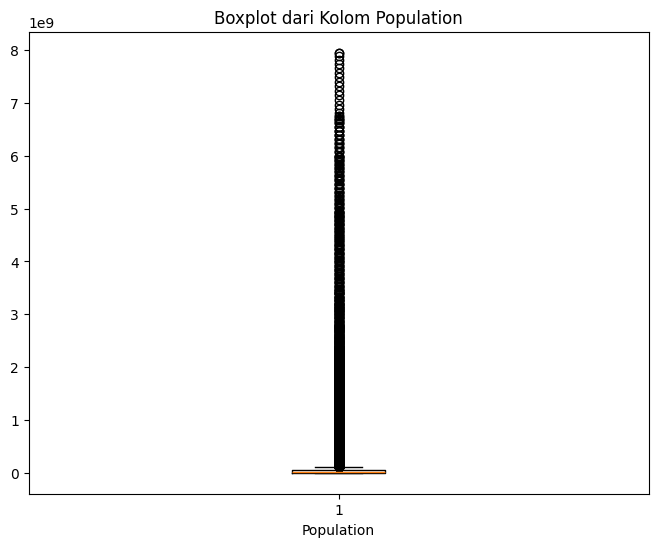

In [92]:
# Visualisasi Sebelum
plt.figure(figsize=(8, 6))
plt.boxplot(df_population_merged['Population'], vert=True)
plt.title('Boxplot dari Kolom Population')
plt.xlabel('Population')
plt.show()

In [93]:
# Memanggil fungsi untuk menghapus outlier
df_population_outlier = remove_outliers(df_population_merged, 'Population')
df_population_outlier

Batasan yang lebih rendah: -67270572.0 Batas atas: 114730972.0
Nilai Minimal: 0   Nilai Maksimal: 7950946801


Country Name Country Code     Indicator Name  \
0                     Afghanistan          AFG  Population, total   
2      Africa Western and Central          AFW  Population, total   
3                         Albania          ALB  Population, total   
4                         Algeria          DZA  Population, total   
5                  American Samoa          ASM  Population, total   
...                           ...          ...                ...   
16954       Virgin Islands (U.S.)          VIR  Population, total   
16955          West Bank and Gaza          PSE  Population, total   
16957                 Yemen, Rep.          YEM  Population, total   
16958                      Zambia          ZMB  Population, total   
16959                    Zimbabwe          ZWE  Population, total   

      Indicator Code  Year  Population  
0        SP.POP.TOTL  1960     8622466  
2        SP.POP.TOTL  1960    97256290  
3        SP.POP.TOTL  1960     1608800  
4        SP.POP.TOTL  1960    11394307  
5        SP.POP.TOTL  1960       20085  
...              ...   ...         ...  
16954    SP.POP.TOTL  2023      105413  
16955    SP.POP.TOTL  2023     5043612  
16957    SP.POP.TOTL  2023    33696614  
16958    SP.POP.TOTL  2023    20017675  
16959    SP.POP.TOTL  2023    16320537  

[13732 rows x 6 columns]

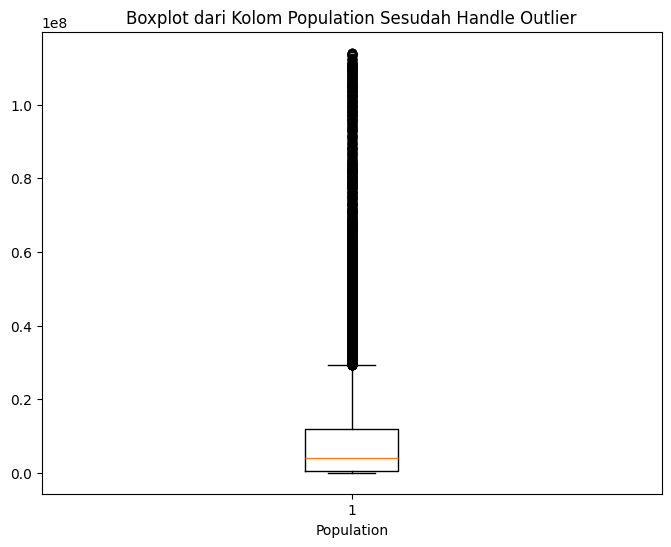

In [94]:
# Visualisasi Sesudah
# Buat boxplot dari kolom 'Population'
plt.figure(figsize=(8, 6))
plt.boxplot(df_population_outlier['Population'], vert=True)
plt.title('Boxplot dari Kolom Population Sesudah Handle Outlier')
plt.xlabel('Population')
plt.show()

### 3.3.6 Replace 

In [95]:
# Mengganti nilai dalam kolom 'Indicator Name' dengan 'Population Total'
df_population_merged['Indicator Name'] = df_population_merged['Indicator Name'].cat.rename_categories({'Population, total': 'Population Total'})
df_population_merged

Country Name Country Code    Indicator Name  \
0                      Afghanistan          AFG  Population Total   
1      Africa Eastern and Southern          AFE  Population Total   
2       Africa Western and Central          AFW  Population Total   
3                          Albania          ALB  Population Total   
4                          Algeria          DZA  Population Total   
...                            ...          ...               ...   
16955           West Bank and Gaza          PSE  Population Total   
16956                        World          WLD  Population Total   
16957                  Yemen, Rep.          YEM  Population Total   
16958                       Zambia          ZMB  Population Total   
16959                     Zimbabwe          ZWE  Population Total   

      Indicator Code  Year  Population  
0        SP.POP.TOTL  1960     8622466  
1        SP.POP.TOTL  1960   130692579  
2        SP.POP.TOTL  1960    97256290  
3        SP.POP.TOTL  1960     1608800  
4        SP.POP.TOTL  1960    11394307  
...              ...   ...         ...  
16955    SP.POP.TOTL  2023     5043612  
16956    SP.POP.TOTL  2023  7950946801  
16957    SP.POP.TOTL  2023    33696614  
16958    SP.POP.TOTL  2023    20017675  
16959    SP.POP.TOTL  2023    16320537  

[16960 rows x 6 columns]

In [96]:
df_population_merged = df_population_merged.sort_values(by=['Country Name', 'Year'])
df_population_merged = df_population_merged.reset_index(drop=True)
df_population_merged

Country Name Country Code    Indicator Name Indicator Code  Year  \
0      Afghanistan          AFG  Population Total    SP.POP.TOTL  1960   
1      Afghanistan          AFG  Population Total    SP.POP.TOTL  1961   
2      Afghanistan          AFG  Population Total    SP.POP.TOTL  1962   
3      Afghanistan          AFG  Population Total    SP.POP.TOTL  1963   
4      Afghanistan          AFG  Population Total    SP.POP.TOTL  1964   
...            ...          ...               ...            ...   ...   
16955     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2019   
16956     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2020   
16957     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2021   
16958     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2022   
16959     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2023   

       Population  
0         8622466  
1         8790140  
2         8969047  
3         9157465  
4         9355514  
...           ...  
16955    15354608  
16956    15669666  
16957    15993524  
16958    16320537  
16959    16320537  

[16960 rows x 6 columns]

### 3.3.5 Visualisasi Plot 3 Negara Studi Kasus Setelah Proses Transform

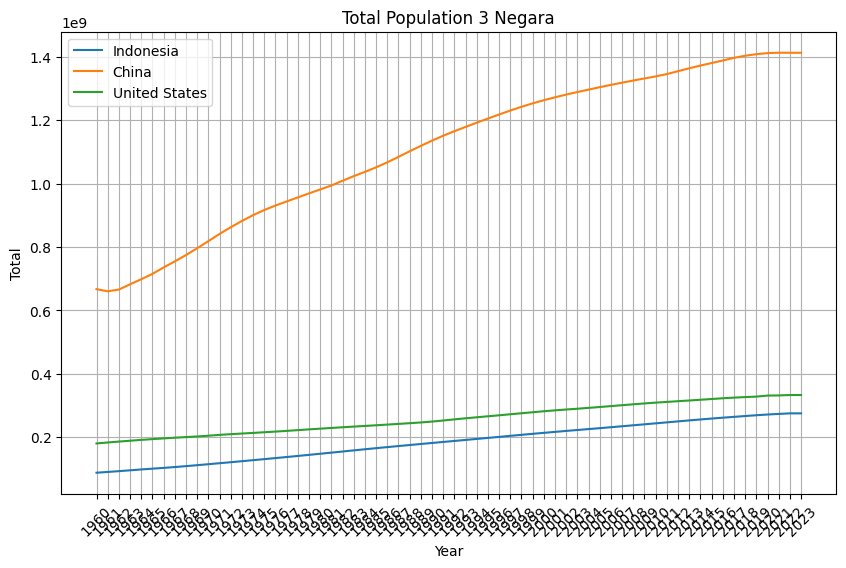

In [97]:
# Filter data untuk negara-negara yang diminta
countries = ['Indonesia', 'China', 'United States']
filtered_df = df_population_merged[df_population_merged['Country Name'].isin(countries)]

# Plot data
plt.figure(figsize=(10, 6))
for country in countries:
    country_data = filtered_df[filtered_df['Country Name'] == country]
    plt.plot(country_data['Year'], country_data['Population'], label=country)

# Menambahkan label dan judul
plt.xlabel('Year')
plt.ylabel('Total')
plt.title('Total Population 3 Negara')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Menampilkan plot
plt.show()

### 3.3.6 Scaling Features

In [98]:
# Melakukan scaling fitur
scaler = MaxAbsScaler()

df_population_scaled = df_population_merged.copy()
df_population_scaled['Population'] = scaler.fit_transform(df_population_scaled[['Population']])
df_population_scaled

Country Name Country Code    Indicator Name Indicator Code  Year  \
0      Afghanistan          AFG  Population Total    SP.POP.TOTL  1960   
1      Afghanistan          AFG  Population Total    SP.POP.TOTL  1961   
2      Afghanistan          AFG  Population Total    SP.POP.TOTL  1962   
3      Afghanistan          AFG  Population Total    SP.POP.TOTL  1963   
4      Afghanistan          AFG  Population Total    SP.POP.TOTL  1964   
...            ...          ...               ...            ...   ...   
16955     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2019   
16956     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2020   
16957     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2021   
16958     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2022   
16959     Zimbabwe          ZWE  Population Total    SP.POP.TOTL  2023   

       Population  
0        0.001084  
1        0.001106  
2        0.001128  
3        0.001152  
4        0.001177  
...           ...  
16955    0.001931  
16956    0.001971  
16957    0.002012  
16958    0.002053  
16959    0.002053  

[16960 rows x 6 columns]

## 3.3 Load

# 4. ETL Pipeline 'rural, electricity, gdp'

## 4.1 Extract Data

### 4.1.1 Extract Data rural

In [99]:
df_rural = pd.read_csv('../data_source/rural_population_percent.csv', skiprows=4) # Lewati empat baris pertama yang tidak berisi data


print("RURAL")
df_rural

RURAL


Country Name Country Code                            Indicator Name  \
0           Aruba          ABW  Rural population (% of total population)   
1     Afghanistan          AFG  Rural population (% of total population)   
2          Angola          AGO  Rural population (% of total population)   
3         Albania          ALB  Rural population (% of total population)   
4         Andorra          AND  Rural population (% of total population)   
..            ...          ...                                       ...   
259        Kosovo          XKX  Rural population (% of total population)   
260   Yemen, Rep.          YEM  Rural population (% of total population)   
261  South Africa          ZAF  Rural population (% of total population)   
262        Zambia          ZMB  Rural population (% of total population)   
263      Zimbabwe          ZWE  Rural population (% of total population)   

     Indicator Code    1960    1961    1962    1963    1964    1965  ...  \
0    SP.RUR.TOTL.ZS  49.224  49.239  49.254  49.270  49.285  49.300  ...   
1    SP.RUR.TOTL.ZS  91.779  91.492  91.195  90.890  90.574  90.250  ...   
2    SP.RUR.TOTL.ZS  89.565  89.202  88.796  88.376  87.942  87.496  ...   
3    SP.RUR.TOTL.ZS  69.295  69.057  68.985  68.914  68.842  68.770  ...   
4    SP.RUR.TOTL.ZS  41.550  39.017  36.538  34.128  31.795  29.555  ...   
..              ...     ...     ...     ...     ...     ...     ...  ...   
259  SP.RUR.TOTL.ZS     NaN     NaN     NaN     NaN     NaN     NaN  ...   
260  SP.RUR.TOTL.ZS  90.900  90.541  90.169  89.784  89.386  88.974  ...   
261  SP.RUR.TOTL.ZS  53.381  53.207  53.094  52.980  52.866  52.752  ...   
262  SP.RUR.TOTL.ZS  81.855  81.049  80.215  79.288  77.985  76.628  ...   
263  SP.RUR.TOTL.ZS  87.392  87.179  86.918  86.422  85.908  85.380  ...   

       2009    2010    2011    2012    2013    2014    2015    2016    2017  \
0    56.579  56.941  57.302  57.636  57.942  58.221  58.472  58.696  58.893   
1    75.687  75.311  74.926  74.532  74.129  73.718  73.297  72.868  72.430   
2    60.701  59.903  59.100  58.301  57.510  56.726  55.950  55.181  54.422   
3    48.924  47.837  46.753  45.670  44.617  43.591  42.593  41.624  40.684   
4    11.648  12.183  12.740  13.292  13.835  14.367  14.885  15.388  15.873   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
259     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
260  68.835  68.268  67.698  67.126  66.550  65.973  65.394  64.813  64.231   
261  38.313  37.782  37.254  36.728  36.212  35.702  35.199  34.705  34.218   
262  61.701  61.275  60.847  60.413  59.973  59.528  59.078  58.621  58.160   
263  66.622  66.804  66.985  67.166  67.346  67.499  67.624  67.723  67.793   

     Unnamed: 62  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN  
..           ...  
259          NaN  
260          NaN  
261          NaN  
262          NaN  
263          NaN  

[264 rows x 63 columns]

In [100]:
df_rural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            259 non-null    float64
 5   1961            259 non-null    float64
 6   1962            259 non-null    float64
 7   1963            259 non-null    float64
 8   1964            259 non-null    float64
 9   1965            259 non-null    float64
 10  1966            259 non-null    float64
 11  1967            259 non-null    float64
 12  1968            259 non-null    float64
 13  1969            259 non-null    float64
 14  1970            259 non-null    float64
 15  1971            259 non-null    float64
 16  1972            259 non-null    float64
 17  1973            259 non-null    flo

### 4.1.2 Extract Data electricity

In [101]:
df_electricity = pd.read_csv('../data_source/electricity_access_percent.csv', skiprows=4) # Lewati empat baris pertama yang tidak berisi data


print("ELECTRICITY")
df_electricity

ELECTRICITY


Country Name Country Code                           Indicator Name  \
0           Aruba          ABW  Access to electricity (% of population)   
1     Afghanistan          AFG  Access to electricity (% of population)   
2          Angola          AGO  Access to electricity (% of population)   
3         Albania          ALB  Access to electricity (% of population)   
4         Andorra          AND  Access to electricity (% of population)   
..            ...          ...                                      ...   
259        Kosovo          XKX  Access to electricity (% of population)   
260   Yemen, Rep.          YEM  Access to electricity (% of population)   
261  South Africa          ZAF  Access to electricity (% of population)   
262        Zambia          ZMB  Access to electricity (% of population)   
263      Zimbabwe          ZWE  Access to electricity (% of population)   

     Indicator Code  1960  1961  1962  1963  1964  1965  ...        2009  \
0    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   93.354546   
1    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   44.854885   
2    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   32.382469   
3    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  100.000000   
4    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  100.000000   
..              ...   ...   ...   ...   ...   ...   ...  ...         ...   
259  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   98.377060   
260  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   61.751400   
261  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   82.700000   
262  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   23.235649   
263  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   43.369082   

           2010        2011        2012        2013        2014        2015  \
0     93.356292   93.942375   94.255814   94.578262   94.906723   95.238182   
1     42.700000   43.222019   69.100000   67.259552   89.500000   71.500000   
2     33.514950   34.600000   35.821964   36.990490   32.000000   42.000000   
3    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
4    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
..          ...         ...         ...         ...         ...         ...   
259    0.000000   99.430435   99.773651   99.942505   99.993134  100.000000   
260   63.134281   64.532181   65.942101   75.600000   66.100000   70.213905   
261   82.900000   84.700000   85.300000   85.400000   86.000000   85.500000   
262   22.000000   24.328644   24.894667   25.469702   27.900000   31.100000   
263   36.063057   36.900000   36.728878   37.076813   32.300000   33.700000   

           2016  2017  Unnamed: 62  
0     95.570145   NaN          NaN  
1     84.137138   NaN          NaN  
2     40.520607   NaN          NaN  
3    100.000000   NaN          NaN  
4    100.000000   NaN          NaN  
..          ...   ...          ...  
259  100.000000   NaN          NaN  
260   71.642349   NaN          NaN  
261   84.200000   NaN          NaN  
262   27.219337   NaN          NaN  
263   38.145138   NaN          NaN  

[264 rows x 63 columns]

In [102]:
df_electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            0 non-null      float64
 5   1961            0 non-null      float64
 6   1962            0 non-null      float64
 7   1963            0 non-null      float64
 8   1964            0 non-null      float64
 9   1965            0 non-null      float64
 10  1966            0 non-null      float64
 11  1967            0 non-null      float64
 12  1968            0 non-null      float64
 13  1969            0 non-null      float64
 14  1970            0 non-null      float64
 15  1971            0 non-null      float64
 16  1972            0 non-null      float64
 17  1973            0 non-null      flo

### 4.1.3 Extract Data GDP

In [103]:
df_gdp = pd.read_csv('../data_source/gdp_data.csv', skiprows=4) # Lewati empat baris pertama yang tidak berisi data


print("GDP")
df_gdp

GDP


Country Name Country Code     Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD   
1     Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD   
2          Angola          AGO  GDP (current US$)  NY.GDP.MKTP.CD   
3         Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD   
4         Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
..            ...          ...                ...             ...   
259        Kosovo          XKX  GDP (current US$)  NY.GDP.MKTP.CD   
260   Yemen, Rep.          YEM  GDP (current US$)  NY.GDP.MKTP.CD   
261  South Africa          ZAF  GDP (current US$)  NY.GDP.MKTP.CD   
262        Zambia          ZMB  GDP (current US$)  NY.GDP.MKTP.CD   
263      Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD   

             1960          1961          1962          1963          1964  \
0             NaN           NaN           NaN           NaN           NaN   
1    5.377778e+08  5.488889e+08  5.466667e+08  7.511112e+08  8.000000e+08   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
259           NaN           NaN           NaN           NaN           NaN   
260           NaN           NaN           NaN           NaN           NaN   
261  7.575248e+09  7.972841e+09  8.497830e+09  9.423212e+09  1.037379e+10   
262  7.130000e+08  6.962857e+08  6.931429e+08  7.187143e+08  8.394286e+08   
263  1.052990e+09  1.096647e+09  1.117602e+09  1.159512e+09  1.217138e+09   

             1965  ...          2009          2010          2011  \
0             NaN  ...  2.498933e+09  2.467704e+09  2.584464e+09   
1    1.006667e+09  ...  1.248694e+10  1.593680e+10  1.793024e+10   
2             NaN  ...  7.549239e+10  8.252614e+10  1.041158e+11   
3             NaN  ...  1.204421e+10  1.192695e+10  1.289087e+10   
4             NaN  ...  3.660531e+09  3.355695e+09  3.442063e+09   
..            ...  ...           ...           ...           ...   
259           NaN  ...  5.653793e+09  5.829934e+09  6.686683e+09   
260           NaN  ...  2.513027e+10  3.090675e+10  3.272642e+10   
261  1.133417e+10  ...  2.972167e+11  3.752981e+11  4.168782e+11   
262  1.082857e+09  ...  1.532834e+10  2.026556e+10  2.346010e+10   
263  1.311436e+09  ...  8.621574e+09  1.014186e+10  1.209845e+10   

             2012          2013          2014          2015          2016  \
0             NaN           NaN           NaN           NaN           NaN   
1    2.053654e+10  2.026425e+10  2.061610e+10  1.921556e+10  1.946902e+10   
2    1.139232e+11  1.249125e+11  1.267302e+11  1.026212e+11  9.533720e+10   
3    1.231978e+10  1.277628e+10  1.322824e+10  1.138693e+10  1.188368e+10   
4    3.164615e+09  3.281585e+09  3.350736e+09  2.811489e+09  2.877312e+09   
..            ...           ...           ...           ...           ...   
259  6.500193e+09  7.073420e+09  7.386891e+09  6.439947e+09  6.715487e+09   
260  3.540133e+10  4.041524e+10  4.322858e+10  3.460248e+10  1.821333e+10   
261  3.963327e+11  3.668294e+11  3.509046e+11  3.177410e+11  2.957627e+11   
262  2.550337e+10  2.804546e+10  2.715063e+10  2.115439e+10  2.095475e+10   
263  1.424249e+10  1.545177e+10  1.589105e+10  1.630467e+10  1.661996e+10   

             2017  Unnamed: 62  
0             NaN          NaN  
1    2.081530e+10          NaN  
2    1.242094e+11          NaN  
3    1.303935e+10          NaN  
4    3.012914e+09          NaN  
..            ...          ...  
259  7.128691e+09          NaN  
260           NaN          NaN  
261  3.494193e+11          NaN  
262  2.580867e+10          NaN  
263  1.784582e+10          NaN  

[264 rows x 63 columns]

In [104]:
df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 63 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country Name    264 non-null    object 
 1   Country Code    264 non-null    object 
 2   Indicator Name  264 non-null    object 
 3   Indicator Code  264 non-null    object 
 4   1960            124 non-null    float64
 5   1961            124 non-null    float64
 6   1962            125 non-null    float64
 7   1963            125 non-null    float64
 8   1964            125 non-null    float64
 9   1965            136 non-null    float64
 10  1966            137 non-null    float64
 11  1967            141 non-null    float64
 12  1968            145 non-null    float64
 13  1969            145 non-null    float64
 14  1970            153 non-null    float64
 15  1971            155 non-null    float64
 16  1972            155 non-null    float64
 17  1973            155 non-null    flo

### 4.1.4 Extract Data From API agar terupdate

#### 4.1.4.1 Rural Population Percent

In [105]:
url = "https://api.worldbank.org/v2/country/all/indicator/SP.RUR.TOTL.ZS?format=json&per_page=30000"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()[1]  # Memilih bagian data dari JSON
    df_rural_percent_api = pd.DataFrame(data)
    columns = ['country.value', 'countryiso3code', 'indicator.id', 'indicator.value', 'date', 'value']
    df_rural_percent_api = pd.json_normalize(data)[columns]
    df_rural_percent_api.columns = ['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name', 'Year', 'ruralpopulationpercent']

else:
    print("Error:", response.status_code)

df_rural_percent_api = df_rural_percent_api.sort_values(by=['Country Name', 'Year'])
df_rural_percent_api = df_rural_percent_api.reset_index(drop=True)
df_rural_percent_api

Country Name Country Code  Indicator Code  \
0      Afghanistan          AFG  SP.RUR.TOTL.ZS   
1      Afghanistan          AFG  SP.RUR.TOTL.ZS   
2      Afghanistan          AFG  SP.RUR.TOTL.ZS   
3      Afghanistan          AFG  SP.RUR.TOTL.ZS   
4      Afghanistan          AFG  SP.RUR.TOTL.ZS   
...            ...          ...             ...   
17019     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17020     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17021     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17022     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17023     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   

                                 Indicator Name  Year  ruralpopulationpercent  
0      Rural population (% of total population)  1960                  91.599  
1      Rural population (% of total population)  1961                  91.316  
2      Rural population (% of total population)  1962                  91.024  
3      Rural population (% of total population)  1963                  90.724  
4      Rural population (% of total population)  1964                  90.414  
...                                         ...   ...                     ...  
17019  Rural population (% of total population)  2019                  67.790  
17020  Rural population (% of total population)  2020                  67.758  
17021  Rural population (% of total population)  2021                  67.697  
17022  Rural population (% of total population)  2022                  67.605  
17023  Rural population (% of total population)  2023                     NaN  

[17024 rows x 6 columns]

#### 4.1.4.2 Electricity Access Percent

In [106]:
url = "https://api.worldbank.org/v2/country/all/indicator/EG.ELC.ACCS.ZS?format=json&per_page=30000"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()[1]  # Memilih bagian data dari JSON
    df_electricity_percent_api = pd.DataFrame(data)
    columns = ['country.value', 'countryiso3code', 'indicator.id', 'indicator.value', 'date', 'value']
    df_electricity_percent_api = pd.json_normalize(data)[columns]
    df_electricity_percent_api.columns = ['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name', 'Year', 'electricityaccesspercent']

else:
    print("Error:", response.status_code)

df_electricity_percent_api = df_electricity_percent_api.sort_values(by=['Country Name', 'Year'])
df_electricity_percent_api = df_electricity_percent_api.reset_index(drop=True)
df_electricity_percent_api

Country Name Country Code  Indicator Code  \
0      Afghanistan          AFG  EG.ELC.ACCS.ZS   
1      Afghanistan          AFG  EG.ELC.ACCS.ZS   
2      Afghanistan          AFG  EG.ELC.ACCS.ZS   
3      Afghanistan          AFG  EG.ELC.ACCS.ZS   
4      Afghanistan          AFG  EG.ELC.ACCS.ZS   
...            ...          ...             ...   
17019     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17020     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17021     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17022     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17023     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   

                                Indicator Name  Year  electricityaccesspercent  
0      Access to electricity (% of population)  1960                       NaN  
1      Access to electricity (% of population)  1961                       NaN  
2      Access to electricity (% of population)  1962                       NaN  
3      Access to electricity (% of population)  1963                       NaN  
4      Access to electricity (% of population)  1964                       NaN  
...                                        ...   ...                       ...  
17019  Access to electricity (% of population)  2019                 46.682095  
17020  Access to electricity (% of population)  2020                 52.747667  
17021  Access to electricity (% of population)  2021                 48.979927  
17022  Access to electricity (% of population)  2022                       NaN  
17023  Access to electricity (% of population)  2023                       NaN  

[17024 rows x 6 columns]

#### 4.1.4.3 GDP

In [107]:
url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?format=json&per_page=30000"

response = requests.get(url)

if response.status_code == 200:
    data = response.json()[1]  # Memilih bagian data dari JSON
    df_gdp_api = pd.DataFrame(data)
    columns = ['country.value', 'countryiso3code', 'indicator.id', 'indicator.value', 'date', 'value']
    df_gdp_api = pd.json_normalize(data)[columns]
    df_gdp_api.columns = ['Country Name', 'Country Code', 'Indicator Code', 'Indicator Name', 'Year', 'gdp']

else:
    print("Error:", response.status_code)

df_gdp_api = df_gdp_api.sort_values(by=['Country Name', 'Year'])
df_gdp_api = df_gdp_api.reset_index(drop=True)
df_gdp_api

Country Name Country Code  Indicator Code     Indicator Name  Year  \
0      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1960   
1      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1961   
2      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1962   
3      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1963   
4      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1964   
...            ...          ...             ...                ...   ...   
17019     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2019   
17020     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2020   
17021     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2021   
17022     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2022   
17023     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2023   

                gdp  
0      5.377778e+08  
1      5.488889e+08  
2      5.466667e+08  
3      7.511112e+08  
4      8.000000e+08  
...             ...  
17019  2.183223e+10  
17020  2.150970e+10  
17021  2.837124e+10  
17022  2.736663e+10  
17023           NaN  

[17024 rows x 6 columns]

### 4.1.5 Drop Kolom yang tidak diperlukan

In [108]:
df_rural.drop(columns=['Unnamed: 62'], inplace=True)
df_electricity.drop(columns=['Unnamed: 62'], inplace=True)
df_gdp.drop(columns=['Unnamed: 62'], inplace=True)

In [109]:
df_rural

Country Name Country Code                            Indicator Name  \
0           Aruba          ABW  Rural population (% of total population)   
1     Afghanistan          AFG  Rural population (% of total population)   
2          Angola          AGO  Rural population (% of total population)   
3         Albania          ALB  Rural population (% of total population)   
4         Andorra          AND  Rural population (% of total population)   
..            ...          ...                                       ...   
259        Kosovo          XKX  Rural population (% of total population)   
260   Yemen, Rep.          YEM  Rural population (% of total population)   
261  South Africa          ZAF  Rural population (% of total population)   
262        Zambia          ZMB  Rural population (% of total population)   
263      Zimbabwe          ZWE  Rural population (% of total population)   

     Indicator Code    1960    1961    1962    1963    1964    1965  ...  \
0    SP.RUR.TOTL.ZS  49.224  49.239  49.254  49.270  49.285  49.300  ...   
1    SP.RUR.TOTL.ZS  91.779  91.492  91.195  90.890  90.574  90.250  ...   
2    SP.RUR.TOTL.ZS  89.565  89.202  88.796  88.376  87.942  87.496  ...   
3    SP.RUR.TOTL.ZS  69.295  69.057  68.985  68.914  68.842  68.770  ...   
4    SP.RUR.TOTL.ZS  41.550  39.017  36.538  34.128  31.795  29.555  ...   
..              ...     ...     ...     ...     ...     ...     ...  ...   
259  SP.RUR.TOTL.ZS     NaN     NaN     NaN     NaN     NaN     NaN  ...   
260  SP.RUR.TOTL.ZS  90.900  90.541  90.169  89.784  89.386  88.974  ...   
261  SP.RUR.TOTL.ZS  53.381  53.207  53.094  52.980  52.866  52.752  ...   
262  SP.RUR.TOTL.ZS  81.855  81.049  80.215  79.288  77.985  76.628  ...   
263  SP.RUR.TOTL.ZS  87.392  87.179  86.918  86.422  85.908  85.380  ...   

       2008    2009    2010    2011    2012    2013    2014    2015    2016  \
0    56.217  56.579  56.941  57.302  57.636  57.942  58.221  58.472  58.696   
1    76.054  75.687  75.311  74.926  74.532  74.129  73.718  73.297  72.868   
2    61.491  60.701  59.903  59.100  58.301  57.510  56.726  55.950  55.181   
3    50.009  48.924  47.837  46.753  45.670  44.617  43.591  42.593  41.624   
4    11.133  11.648  12.183  12.740  13.292  13.835  14.367  14.885  15.388   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
259     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
260  69.398  68.835  68.268  67.698  67.126  66.550  65.973  65.394  64.813   
261  38.846  38.313  37.782  37.254  36.728  36.212  35.702  35.199  34.705   
262  62.125  61.701  61.275  60.847  60.413  59.973  59.528  59.078  58.621   
263  66.440  66.622  66.804  66.985  67.166  67.346  67.499  67.624  67.723   

       2017  
0    58.893  
1    72.430  
2    54.422  
3    40.684  
4    15.873  
..      ...  
259     NaN  
260  64.231  
261  34.218  
262  58.160  
263  67.793  

[264 rows x 62 columns]

In [110]:
df_electricity

Country Name Country Code                           Indicator Name  \
0           Aruba          ABW  Access to electricity (% of population)   
1     Afghanistan          AFG  Access to electricity (% of population)   
2          Angola          AGO  Access to electricity (% of population)   
3         Albania          ALB  Access to electricity (% of population)   
4         Andorra          AND  Access to electricity (% of population)   
..            ...          ...                                      ...   
259        Kosovo          XKX  Access to electricity (% of population)   
260   Yemen, Rep.          YEM  Access to electricity (% of population)   
261  South Africa          ZAF  Access to electricity (% of population)   
262        Zambia          ZMB  Access to electricity (% of population)   
263      Zimbabwe          ZWE  Access to electricity (% of population)   

     Indicator Code  1960  1961  1962  1963  1964  1965  ...        2008  \
0    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   93.086166   
1    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   42.400000   
2    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   31.268013   
3    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  100.000000   
4    EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...  100.000000   
..              ...   ...   ...   ...   ...   ...   ...  ...         ...   
259  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   97.794670   
260  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   60.386539   
261  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   81.900000   
262  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   22.714685   
263  EG.ELC.ACCS.ZS   NaN   NaN   NaN   NaN   NaN   NaN  ...   35.457310   

           2009        2010        2011        2012        2013        2014  \
0     93.354546   93.356292   93.942375   94.255814   94.578262   94.906723   
1     44.854885   42.700000   43.222019   69.100000   67.259552   89.500000   
2     32.382469   33.514950   34.600000   35.821964   36.990490   32.000000   
3    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
4    100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
..          ...         ...         ...         ...         ...         ...   
259   98.377060    0.000000   99.430435   99.773651   99.942505   99.993134   
260   61.751400   63.134281   64.532181   65.942101   75.600000   66.100000   
261   82.700000   82.900000   84.700000   85.300000   85.400000   86.000000   
262   23.235649   22.000000   24.328644   24.894667   25.469702   27.900000   
263   43.369082   36.063057   36.900000   36.728878   37.076813   32.300000   

           2015        2016  2017  
0     95.238182   95.570145   NaN  
1     71.500000   84.137138   NaN  
2     42.000000   40.520607   NaN  
3    100.000000  100.000000   NaN  
4    100.000000  100.000000   NaN  
..          ...         ...   ...  
259  100.000000  100.000000   NaN  
260   70.213905   71.642349   NaN  
261   85.500000   84.200000   NaN  
262   31.100000   27.219337   NaN  
263   33.700000   38.145138   NaN  

[264 rows x 62 columns]

In [111]:
df_gdp

Country Name Country Code     Indicator Name  Indicator Code  \
0           Aruba          ABW  GDP (current US$)  NY.GDP.MKTP.CD   
1     Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD   
2          Angola          AGO  GDP (current US$)  NY.GDP.MKTP.CD   
3         Albania          ALB  GDP (current US$)  NY.GDP.MKTP.CD   
4         Andorra          AND  GDP (current US$)  NY.GDP.MKTP.CD   
..            ...          ...                ...             ...   
259        Kosovo          XKX  GDP (current US$)  NY.GDP.MKTP.CD   
260   Yemen, Rep.          YEM  GDP (current US$)  NY.GDP.MKTP.CD   
261  South Africa          ZAF  GDP (current US$)  NY.GDP.MKTP.CD   
262        Zambia          ZMB  GDP (current US$)  NY.GDP.MKTP.CD   
263      Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD   

             1960          1961          1962          1963          1964  \
0             NaN           NaN           NaN           NaN           NaN   
1    5.377778e+08  5.488889e+08  5.466667e+08  7.511112e+08  8.000000e+08   
2             NaN           NaN           NaN           NaN           NaN   
3             NaN           NaN           NaN           NaN           NaN   
4             NaN           NaN           NaN           NaN           NaN   
..            ...           ...           ...           ...           ...   
259           NaN           NaN           NaN           NaN           NaN   
260           NaN           NaN           NaN           NaN           NaN   
261  7.575248e+09  7.972841e+09  8.497830e+09  9.423212e+09  1.037379e+10   
262  7.130000e+08  6.962857e+08  6.931429e+08  7.187143e+08  8.394286e+08   
263  1.052990e+09  1.096647e+09  1.117602e+09  1.159512e+09  1.217138e+09   

             1965  ...          2008          2009          2010  \
0             NaN  ...  2.791961e+09  2.498933e+09  2.467704e+09   
1    1.006667e+09  ...  1.019053e+10  1.248694e+10  1.593680e+10   
2             NaN  ...  8.417804e+10  7.549239e+10  8.252614e+10   
3             NaN  ...  1.288135e+10  1.204421e+10  1.192695e+10   
4             NaN  ...  4.007353e+09  3.660531e+09  3.355695e+09   
..            ...  ...           ...           ...           ...   
259           NaN  ...  5.687488e+09  5.653793e+09  5.829934e+09   
260           NaN  ...  2.691085e+10  2.513027e+10  3.090675e+10   
261  1.133417e+10  ...  2.871000e+11  2.972167e+11  3.752981e+11   
262  1.082857e+09  ...  1.791086e+10  1.532834e+10  2.026556e+10   
263  1.311436e+09  ...  4.415703e+09  8.621574e+09  1.014186e+10   

             2011          2012          2013          2014          2015  \
0    2.584464e+09           NaN           NaN           NaN           NaN   
1    1.793024e+10  2.053654e+10  2.026425e+10  2.061610e+10  1.921556e+10   
2    1.041158e+11  1.139232e+11  1.249125e+11  1.267302e+11  1.026212e+11   
3    1.289087e+10  1.231978e+10  1.277628e+10  1.322824e+10  1.138693e+10   
4    3.442063e+09  3.164615e+09  3.281585e+09  3.350736e+09  2.811489e+09   
..            ...           ...           ...           ...           ...   
259  6.686683e+09  6.500193e+09  7.073420e+09  7.386891e+09  6.439947e+09   
260  3.272642e+10  3.540133e+10  4.041524e+10  4.322858e+10  3.460248e+10   
261  4.168782e+11  3.963327e+11  3.668294e+11  3.509046e+11  3.177410e+11   
262  2.346010e+10  2.550337e+10  2.804546e+10  2.715063e+10  2.115439e+10   
263  1.209845e+10  1.424249e+10  1.545177e+10  1.589105e+10  1.630467e+10   

             2016          2017  
0             NaN           NaN  
1    1.946902e+10  2.081530e+10  
2    9.533720e+10  1.242094e+11  
3    1.188368e+10  1.303935e+10  
4    2.877312e+09  3.012914e+09  
..            ...           ...  
259  6.715487e+09  7.128691e+09  
260  1.821333e+10           NaN  
261  2.957627e+11  3.494193e+11  
262  2.095475e+10  2.580867e+10  
263  1.661996e+10  1.784582e+10  

[264 rows x 62 columns]

### 4.1.6 Cek Duplicates

In [112]:
# Mengecek duplikat di seluruh DataFrame
df_rural.duplicated()
df_electricity.duplicated()
df_gdp.duplicated()


# Menghitung jumlah duplikat
df_rural.duplicated().sum()
df_electricity.duplicated().sum()
df_gdp.duplicated().sum()

0

## 4.2 Transform Dataset

### 4.2.1 Penyesuaian Type Data

In [113]:
df_rural['Country Name'] = df_rural['Country Name'].astype('category')
df_rural['Country Code'] = df_rural['Country Code'].astype('category')
df_rural['Indicator Name'] = df_rural['Indicator Name'].astype('category')
df_rural['Indicator Code'] = df_rural['Indicator Code'].astype('category')

df_rural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    264 non-null    category
 1   Country Code    264 non-null    category
 2   Indicator Name  264 non-null    category
 3   Indicator Code  264 non-null    category
 4   1960            259 non-null    float64 
 5   1961            259 non-null    float64 
 6   1962            259 non-null    float64 
 7   1963            259 non-null    float64 
 8   1964            259 non-null    float64 
 9   1965            259 non-null    float64 
 10  1966            259 non-null    float64 
 11  1967            259 non-null    float64 
 12  1968            259 non-null    float64 
 13  1969            259 non-null    float64 
 14  1970            259 non-null    float64 
 15  1971            259 non-null    float64 
 16  1972            259 non-null    float64 
 17  1973            

In [114]:
df_electricity['Country Name'] = df_electricity['Country Name'].astype('category')
df_electricity['Country Code'] = df_electricity['Country Code'].astype('category')
df_electricity['Indicator Name'] = df_electricity['Indicator Name'].astype('category')
df_electricity['Indicator Code'] = df_electricity['Indicator Code'].astype('category')

df_electricity.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    264 non-null    category
 1   Country Code    264 non-null    category
 2   Indicator Name  264 non-null    category
 3   Indicator Code  264 non-null    category
 4   1960            0 non-null      float64 
 5   1961            0 non-null      float64 
 6   1962            0 non-null      float64 
 7   1963            0 non-null      float64 
 8   1964            0 non-null      float64 
 9   1965            0 non-null      float64 
 10  1966            0 non-null      float64 
 11  1967            0 non-null      float64 
 12  1968            0 non-null      float64 
 13  1969            0 non-null      float64 
 14  1970            0 non-null      float64 
 15  1971            0 non-null      float64 
 16  1972            0 non-null      float64 
 17  1973            

In [115]:
df_gdp['Country Name'] = df_gdp['Country Name'].astype('category')
df_gdp['Country Code'] = df_gdp['Country Code'].astype('category')
df_gdp['Indicator Name'] = df_gdp['Indicator Name'].astype('category')
df_gdp['Indicator Code'] = df_gdp['Indicator Code'].astype('category')

df_gdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 62 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Country Name    264 non-null    category
 1   Country Code    264 non-null    category
 2   Indicator Name  264 non-null    category
 3   Indicator Code  264 non-null    category
 4   1960            124 non-null    float64 
 5   1961            124 non-null    float64 
 6   1962            125 non-null    float64 
 7   1963            125 non-null    float64 
 8   1964            125 non-null    float64 
 9   1965            136 non-null    float64 
 10  1966            137 non-null    float64 
 11  1967            141 non-null    float64 
 12  1968            145 non-null    float64 
 13  1969            145 non-null    float64 
 14  1970            153 non-null    float64 
 15  1971            155 non-null    float64 
 16  1972            155 non-null    float64 
 17  1973            

### 4.2.2 Feature Engineering Melt Data & Merged Data

In [116]:
# Lakukan melt pada kolom tahun (dari '1960' hingga '2017')
df_electricity_merged = pd.melt(df_electricity, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                     var_name='Year', value_name='electricityaccesspercent')

df_electricity_merged = df_electricity_merged.sort_values(by=['Country Name', 'Year'])
df_electricity_merged = df_electricity_merged.reset_index(drop=True)
df_electricity_merged

Country Name Country Code                           Indicator Name  \
0      Afghanistan          AFG  Access to electricity (% of population)   
1      Afghanistan          AFG  Access to electricity (% of population)   
2      Afghanistan          AFG  Access to electricity (% of population)   
3      Afghanistan          AFG  Access to electricity (% of population)   
4      Afghanistan          AFG  Access to electricity (% of population)   
...            ...          ...                                      ...   
15307     Zimbabwe          ZWE  Access to electricity (% of population)   
15308     Zimbabwe          ZWE  Access to electricity (% of population)   
15309     Zimbabwe          ZWE  Access to electricity (% of population)   
15310     Zimbabwe          ZWE  Access to electricity (% of population)   
15311     Zimbabwe          ZWE  Access to electricity (% of population)   

       Indicator Code  Year  electricityaccesspercent  
0      EG.ELC.ACCS.ZS  1960                       NaN  
1      EG.ELC.ACCS.ZS  1961                       NaN  
2      EG.ELC.ACCS.ZS  1962                       NaN  
3      EG.ELC.ACCS.ZS  1963                       NaN  
4      EG.ELC.ACCS.ZS  1964                       NaN  
...               ...   ...                       ...  
15307  EG.ELC.ACCS.ZS  2013                 37.076813  
15308  EG.ELC.ACCS.ZS  2014                 32.300000  
15309  EG.ELC.ACCS.ZS  2015                 33.700000  
15310  EG.ELC.ACCS.ZS  2016                 38.145138  
15311  EG.ELC.ACCS.ZS  2017                       NaN  

[15312 rows x 6 columns]

In [117]:
# Lakukan melt pada kolom tahun (dari '1960' hingga '2017')
df_rural_merged = pd.melt(df_rural, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                     var_name='Year', value_name='ruralpopulationpercent')
df_rural_merged = df_rural_merged.sort_values(by=['Country Name', 'Year'])
df_rural_merged = df_rural_merged.reset_index(drop=True)
df_rural_merged

Country Name Country Code                            Indicator Name  \
0      Afghanistan          AFG  Rural population (% of total population)   
1      Afghanistan          AFG  Rural population (% of total population)   
2      Afghanistan          AFG  Rural population (% of total population)   
3      Afghanistan          AFG  Rural population (% of total population)   
4      Afghanistan          AFG  Rural population (% of total population)   
...            ...          ...                                       ...   
15307     Zimbabwe          ZWE  Rural population (% of total population)   
15308     Zimbabwe          ZWE  Rural population (% of total population)   
15309     Zimbabwe          ZWE  Rural population (% of total population)   
15310     Zimbabwe          ZWE  Rural population (% of total population)   
15311     Zimbabwe          ZWE  Rural population (% of total population)   

       Indicator Code  Year  ruralpopulationpercent  
0      SP.RUR.TOTL.ZS  1960                  91.779  
1      SP.RUR.TOTL.ZS  1961                  91.492  
2      SP.RUR.TOTL.ZS  1962                  91.195  
3      SP.RUR.TOTL.ZS  1963                  90.890  
4      SP.RUR.TOTL.ZS  1964                  90.574  
...               ...   ...                     ...  
15307  SP.RUR.TOTL.ZS  2013                  67.346  
15308  SP.RUR.TOTL.ZS  2014                  67.499  
15309  SP.RUR.TOTL.ZS  2015                  67.624  
15310  SP.RUR.TOTL.ZS  2016                  67.723  
15311  SP.RUR.TOTL.ZS  2017                  67.793  

[15312 rows x 6 columns]

In [118]:
df_gdp_merged = pd.melt(df_gdp, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                     var_name='Year', value_name='gdp')

df_gdp_merged = df_gdp_merged.sort_values(by=['Country Name', 'Year'])
df_gdp_merged = df_gdp_merged.reset_index(drop=True)
df_gdp_merged

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
15307     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2013   
15308     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2014   
15309     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2015   
15310     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2016   
15311     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2017   

                gdp  
0      5.377778e+08  
1      5.488889e+08  
2      5.466667e+08  
3      7.511112e+08  
4      8.000000e+08  
...             ...  
15307  1.545177e+10  
15308  1.589105e+10  
15309  1.630467e+10  
15310  1.661996e+10  
15311  1.784582e+10  

[15312 rows x 6 columns]

### 4.2.3 Update Data berdasarkan API menggunakan update

In [119]:
df_rural_merged  = pd.concat([df_rural_percent_api], axis=1)
df_electricity_merged  = pd.concat([df_electricity_percent_api], axis=1)
df_gdp_merged  = pd.concat([df_gdp_api], axis=1)

In [120]:
print("RURAL UPDATE")
df_rural_merged = df_rural_merged.sort_values(by=['Country Name', 'Year'])
df_rural_merged = df_rural_merged.reset_index(drop=True)
df_rural_merged

RURAL UPDATE


Country Name Country Code  Indicator Code  \
0      Afghanistan          AFG  SP.RUR.TOTL.ZS   
1      Afghanistan          AFG  SP.RUR.TOTL.ZS   
2      Afghanistan          AFG  SP.RUR.TOTL.ZS   
3      Afghanistan          AFG  SP.RUR.TOTL.ZS   
4      Afghanistan          AFG  SP.RUR.TOTL.ZS   
...            ...          ...             ...   
17019     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17020     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17021     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17022     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17023     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   

                                 Indicator Name  Year  ruralpopulationpercent  
0      Rural population (% of total population)  1960                  91.599  
1      Rural population (% of total population)  1961                  91.316  
2      Rural population (% of total population)  1962                  91.024  
3      Rural population (% of total population)  1963                  90.724  
4      Rural population (% of total population)  1964                  90.414  
...                                         ...   ...                     ...  
17019  Rural population (% of total population)  2019                  67.790  
17020  Rural population (% of total population)  2020                  67.758  
17021  Rural population (% of total population)  2021                  67.697  
17022  Rural population (% of total population)  2022                  67.605  
17023  Rural population (% of total population)  2023                     NaN  

[17024 rows x 6 columns]

In [121]:
print("ELECTRICITY UPDATE")
df_electricity_merged = df_electricity_merged.sort_values(by=['Country Name', 'Year'])
df_electricity_merged = df_electricity_merged.reset_index(drop=True)
df_electricity_merged

ELECTRICITY UPDATE


Country Name Country Code  Indicator Code  \
0      Afghanistan          AFG  EG.ELC.ACCS.ZS   
1      Afghanistan          AFG  EG.ELC.ACCS.ZS   
2      Afghanistan          AFG  EG.ELC.ACCS.ZS   
3      Afghanistan          AFG  EG.ELC.ACCS.ZS   
4      Afghanistan          AFG  EG.ELC.ACCS.ZS   
...            ...          ...             ...   
17019     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17020     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17021     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17022     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   
17023     Zimbabwe          ZWE  EG.ELC.ACCS.ZS   

                                Indicator Name  Year  electricityaccesspercent  
0      Access to electricity (% of population)  1960                       NaN  
1      Access to electricity (% of population)  1961                       NaN  
2      Access to electricity (% of population)  1962                       NaN  
3      Access to electricity (% of population)  1963                       NaN  
4      Access to electricity (% of population)  1964                       NaN  
...                                        ...   ...                       ...  
17019  Access to electricity (% of population)  2019                 46.682095  
17020  Access to electricity (% of population)  2020                 52.747667  
17021  Access to electricity (% of population)  2021                 48.979927  
17022  Access to electricity (% of population)  2022                       NaN  
17023  Access to electricity (% of population)  2023                       NaN  

[17024 rows x 6 columns]

In [122]:
print("GDP UPDATE")
df_gdp_merged = df_gdp_merged.sort_values(by=['Country Name', 'Year'])
df_gdp_merged = df_gdp_merged.reset_index(drop=True)
df_gdp_merged

GDP UPDATE


Country Name Country Code  Indicator Code     Indicator Name  Year  \
0      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1960   
1      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1961   
2      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1962   
3      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1963   
4      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1964   
...            ...          ...             ...                ...   ...   
17019     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2019   
17020     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2020   
17021     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2021   
17022     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2022   
17023     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2023   

                gdp  
0      5.377778e+08  
1      5.488889e+08  
2      5.466667e+08  
3      7.511112e+08  
4      8.000000e+08  
...             ...  
17019  2.183223e+10  
17020  2.150970e+10  
17021  2.837124e+10  
17022  2.736663e+10  
17023           NaN  

[17024 rows x 6 columns]

### 4.2.4 Drop Kolom yang tidak perlu

In [123]:
df_merged_elc_rural = pd.concat([df_rural_merged, df_electricity_merged['electricityaccesspercent']], axis=1)

df_merged_elc_rural

Country Name Country Code  Indicator Code  \
0      Afghanistan          AFG  SP.RUR.TOTL.ZS   
1      Afghanistan          AFG  SP.RUR.TOTL.ZS   
2      Afghanistan          AFG  SP.RUR.TOTL.ZS   
3      Afghanistan          AFG  SP.RUR.TOTL.ZS   
4      Afghanistan          AFG  SP.RUR.TOTL.ZS   
...            ...          ...             ...   
17019     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17020     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17021     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17022     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   
17023     Zimbabwe          ZWE  SP.RUR.TOTL.ZS   

                                 Indicator Name  Year  ruralpopulationpercent  \
0      Rural population (% of total population)  1960                  91.599   
1      Rural population (% of total population)  1961                  91.316   
2      Rural population (% of total population)  1962                  91.024   
3      Rural population (% of total population)  1963                  90.724   
4      Rural population (% of total population)  1964                  90.414   
...                                         ...   ...                     ...   
17019  Rural population (% of total population)  2019                  67.790   
17020  Rural population (% of total population)  2020                  67.758   
17021  Rural population (% of total population)  2021                  67.697   
17022  Rural population (% of total population)  2022                  67.605   
17023  Rural population (% of total population)  2023                     NaN   

       electricityaccesspercent  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...                         ...  
17019                 46.682095  
17020                 52.747667  
17021                 48.979927  
17022                       NaN  
17023                       NaN  

[17024 rows x 7 columns]

In [124]:
df_merged_elc_rural.drop(df_merged_elc_rural.columns[2:4], axis=1, inplace=True)

df_merged_elc_rural

Country Name Country Code  Year  ruralpopulationpercent  \
0      Afghanistan          AFG  1960                  91.599   
1      Afghanistan          AFG  1961                  91.316   
2      Afghanistan          AFG  1962                  91.024   
3      Afghanistan          AFG  1963                  90.724   
4      Afghanistan          AFG  1964                  90.414   
...            ...          ...   ...                     ...   
17019     Zimbabwe          ZWE  2019                  67.790   
17020     Zimbabwe          ZWE  2020                  67.758   
17021     Zimbabwe          ZWE  2021                  67.697   
17022     Zimbabwe          ZWE  2022                  67.605   
17023     Zimbabwe          ZWE  2023                     NaN   

       electricityaccesspercent  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...                         ...  
17019                 46.682095  
17020                 52.747667  
17021                 48.979927  
17022                       NaN  
17023                       NaN  

[17024 rows x 5 columns]

In [125]:
df_merged_elc_rural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17024 entries, 0 to 17023
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              17024 non-null  object 
 1   Country Code              17024 non-null  object 
 2   Year                      17024 non-null  object 
 3   ruralpopulationpercent    16569 non-null  float64
 4   electricityaccesspercent  7348 non-null   float64
dtypes: float64(2), object(3)
memory usage: 665.1+ KB


In [126]:
df_merged_elc_rural = df_merged_elc_rural.sort_values(by=['Country Name', 'Year'])
df_merged_elc_rural = df_merged_elc_rural.reset_index(drop=True)
df_merged_elc_rural

Country Name Country Code  Year  ruralpopulationpercent  \
0      Afghanistan          AFG  1960                  91.599   
1      Afghanistan          AFG  1961                  91.316   
2      Afghanistan          AFG  1962                  91.024   
3      Afghanistan          AFG  1963                  90.724   
4      Afghanistan          AFG  1964                  90.414   
...            ...          ...   ...                     ...   
17019     Zimbabwe          ZWE  2019                  67.790   
17020     Zimbabwe          ZWE  2020                  67.758   
17021     Zimbabwe          ZWE  2021                  67.697   
17022     Zimbabwe          ZWE  2022                  67.605   
17023     Zimbabwe          ZWE  2023                     NaN   

       electricityaccesspercent  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...                         ...  
17019                 46.682095  
17020                 52.747667  
17021                 48.979927  
17022                       NaN  
17023                       NaN  

[17024 rows x 5 columns]

### 4.2.5 Handle Missing Values

In [127]:
# Mengecek nilai NaN pada dataframe
for column in df_merged_elc_rural.columns:
    nan_values = df_merged_elc_rural[df_merged_elc_rural[column].isna()][column]
    if not nan_values.empty:
        print(f"Kolom '{column}' memiliki nilai NaN: {nan_values.values}")

Kolom 'ruralpopulationpercent' memiliki nilai NaN: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan


In [128]:
# Mencari baris yang memiliki nilai NaN pada kolom 'electricityaccesspercent' atau 'ruralpopulationpercent'
rows_with_nan = df_merged_elc_rural[df_merged_elc_rural['electricityaccesspercent'].isna() | df_merged_elc_rural['ruralpopulationpercent'].isna()]
rows_with_nan

Country Name Country Code  Year  ruralpopulationpercent  \
0      Afghanistan          AFG  1960                  91.599   
1      Afghanistan          AFG  1961                  91.316   
2      Afghanistan          AFG  1962                  91.024   
3      Afghanistan          AFG  1963                  90.724   
4      Afghanistan          AFG  1964                  90.414   
...            ...          ...   ...                     ...   
16989     Zimbabwe          ZWE  1989                  71.750   
16990     Zimbabwe          ZWE  1990                  71.012   
16991     Zimbabwe          ZWE  1991                  70.262   
17022     Zimbabwe          ZWE  2022                  67.605   
17023     Zimbabwe          ZWE  2023                     NaN   

       electricityaccesspercent  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN  
...                         ...  
16989                       NaN  
16990                       NaN  
16991                       NaN  
17022                       NaN  
17023                       NaN  

[9718 rows x 5 columns]

In [129]:
df_merged_elc_rural['electricityaccesspercent'] = df_merged_elc_rural['electricityaccesspercent'].fillna(0)
df_merged_elc_rural

Country Name Country Code  Year  ruralpopulationpercent  \
0      Afghanistan          AFG  1960                  91.599   
1      Afghanistan          AFG  1961                  91.316   
2      Afghanistan          AFG  1962                  91.024   
3      Afghanistan          AFG  1963                  90.724   
4      Afghanistan          AFG  1964                  90.414   
...            ...          ...   ...                     ...   
17019     Zimbabwe          ZWE  2019                  67.790   
17020     Zimbabwe          ZWE  2020                  67.758   
17021     Zimbabwe          ZWE  2021                  67.697   
17022     Zimbabwe          ZWE  2022                  67.605   
17023     Zimbabwe          ZWE  2023                     NaN   

       electricityaccesspercent  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.000000  
4                      0.000000  
...                         ...  
17019                 46.682095  
17020                 52.747667  
17021                 48.979927  
17022                  0.000000  
17023                  0.000000  

[17024 rows x 5 columns]

In [130]:
df_merged_elc_rural.isnull().sum()

Country Name                  0
Country Code                  0
Year                          0
ruralpopulationpercent      455
electricityaccesspercent      0
dtype: int64

### 4.2.6 Penyesuaian Type Data 2

In [131]:
df_merged_elc_rural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17024 entries, 0 to 17023
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              17024 non-null  object 
 1   Country Code              17024 non-null  object 
 2   Year                      17024 non-null  object 
 3   ruralpopulationpercent    16569 non-null  float64
 4   electricityaccesspercent  17024 non-null  float64
dtypes: float64(2), object(3)
memory usage: 665.1+ KB


In [132]:
df_merged_elc_rural['Country Name'] = df_merged_elc_rural['Country Name'].astype('category')
df_merged_elc_rural['Country Code'] = df_merged_elc_rural['Country Code'].astype('category')
df_merged_elc_rural['Year'] = df_merged_elc_rural['Year'].astype('category')

df_merged_elc_rural.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17024 entries, 0 to 17023
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   Country Name              17024 non-null  category
 1   Country Code              17024 non-null  category
 2   Year                      17024 non-null  category
 3   ruralpopulationpercent    16569 non-null  float64 
 4   electricityaccesspercent  17024 non-null  float64 
dtypes: category(3), float64(2)
memory usage: 372.1 KB


### 4.2.7 Cek Duplicate

In [133]:
df_merged_elc_rural.duplicated()

df_merged_elc_rural.duplicated().sum()

0

In [134]:
# Hapus baris dengan nilai 'Not classified' dalam kolom 'Country Name'
df_merged_elc_rural = df_merged_elc_rural[df_merged_elc_rural['Country Name'] != 'Not classified']
df_merged_elc_rural = df_merged_elc_rural.reset_index(drop=True)
df_merged_elc_rural

Country Name Country Code  Year  ruralpopulationpercent  \
0      Afghanistan          AFG  1960                  91.599   
1      Afghanistan          AFG  1961                  91.316   
2      Afghanistan          AFG  1962                  91.024   
3      Afghanistan          AFG  1963                  90.724   
4      Afghanistan          AFG  1964                  90.414   
...            ...          ...   ...                     ...   
16955     Zimbabwe          ZWE  2019                  67.790   
16956     Zimbabwe          ZWE  2020                  67.758   
16957     Zimbabwe          ZWE  2021                  67.697   
16958     Zimbabwe          ZWE  2022                  67.605   
16959     Zimbabwe          ZWE  2023                     NaN   

       electricityaccesspercent  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.000000  
4                      0.000000  
...                         ...  
16955                 46.682095  
16956                 52.747667  
16957                 48.979927  
16958                  0.000000  
16959                  0.000000  

[16960 rows x 5 columns]

### 4.2.8 Visualisasi Kebenaran Data

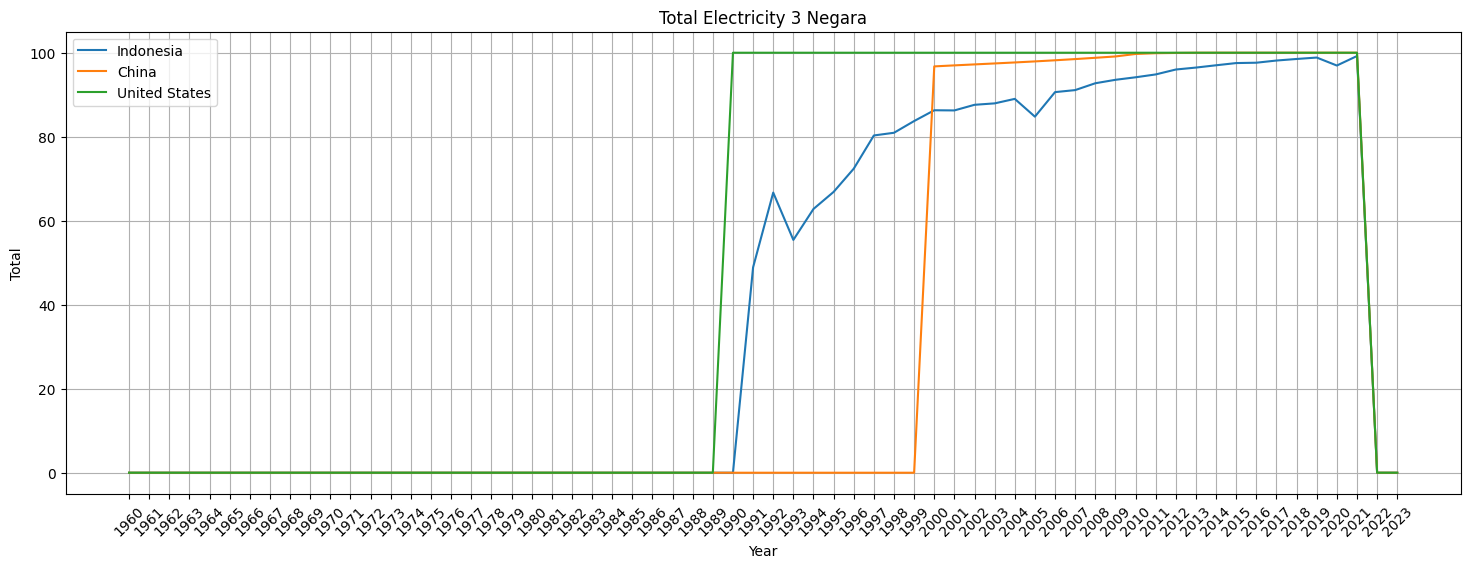

In [135]:
# Filter data untuk negara-negara yang diminta
countries = ['Indonesia', 'China', 'United States']
df_vis_merged_elc_rural = df_merged_elc_rural[df_merged_elc_rural['Country Name'].isin(countries)]

# Plot data
plt.figure(figsize=(18, 6))
for country in countries:
    country_data = df_vis_merged_elc_rural[df_vis_merged_elc_rural['Country Name'] == country]
    plt.plot(country_data['Year'], country_data['electricityaccesspercent'], label=country)

# Menambahkan label dan judul
plt.xlabel('Year')
plt.ylabel('Total')
plt.title('Total Electricity 3 Negara')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Menampilkan plot
plt.show()

## 4.3 Transform Lebih Lanjut GDP

In [136]:
df_gdp_merged

Country Name Country Code  Indicator Code     Indicator Name  Year  \
0      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1960   
1      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1961   
2      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1962   
3      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1963   
4      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1964   
...            ...          ...             ...                ...   ...   
17019     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2019   
17020     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2020   
17021     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2021   
17022     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2022   
17023     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2023   

                gdp  
0      5.377778e+08  
1      5.488889e+08  
2      5.466667e+08  
3      7.511112e+08  
4      8.000000e+08  
...             ...  
17019  2.183223e+10  
17020  2.150970e+10  
17021  2.837124e+10  
17022  2.736663e+10  
17023           NaN  

[17024 rows x 6 columns]

In [137]:
# Hapus baris dengan nilai 'Not classified' dalam kolom 'Country Name'
df_gdp_merged = df_gdp_merged[df_gdp_merged['Country Name'] != 'Not classified']
df_gdp_merged = df_gdp_merged.reset_index(drop=True)
df_gdp_merged

Country Name Country Code  Indicator Code     Indicator Name  Year  \
0      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1960   
1      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1961   
2      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1962   
3      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1963   
4      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1964   
...            ...          ...             ...                ...   ...   
16955     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2019   
16956     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2020   
16957     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2021   
16958     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2022   
16959     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2023   

                gdp  
0      5.377778e+08  
1      5.488889e+08  
2      5.466667e+08  
3      7.511112e+08  
4      8.000000e+08  
...             ...  
16955  2.183223e+10  
16956  2.150970e+10  
16957  2.837124e+10  
16958  2.736663e+10  
16959           NaN  

[16960 rows x 6 columns]

### 4.3.1 Handle Missing Values

In [138]:
# Mengecek nilai NaN pada dataframe
for column in df_gdp_merged.columns:
    nan_values = df_gdp_merged[df_gdp_merged[column].isna()][column]
    if not nan_values.empty:
        print(f"Kolom '{column}' memiliki nilai NaN: {nan_values.values}")

Kolom 'gdp' memiliki nilai NaN: [nan nan nan ... nan nan nan]


In [139]:
df_gdp_merged.isnull().sum()

Country Name         0
Country Code         0
Indicator Code       0
Indicator Name       0
Year                 0
gdp               3762
dtype: int64

In [140]:
gdp_nan = df_gdp_merged[df_gdp_merged['gdp'].isna()]
gdp_nan

Country Name Country Code  Indicator Code     Indicator Name  Year  gdp
22     Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1982  NaN
23     Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1983  NaN
24     Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1984  NaN
25     Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1985  NaN
26     Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1986  NaN
...            ...          ...             ...                ...   ...  ...
16829  Yemen, Rep.          YEM  NY.GDP.MKTP.CD  GDP (current US$)  2021  NaN
16830  Yemen, Rep.          YEM  NY.GDP.MKTP.CD  GDP (current US$)  2022  NaN
16831  Yemen, Rep.          YEM  NY.GDP.MKTP.CD  GDP (current US$)  2023  NaN
16895       Zambia          ZMB  NY.GDP.MKTP.CD  GDP (current US$)  2023  NaN
16959     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2023  NaN

[3762 rows x 6 columns]

In [141]:
df_gdp_merged['gdp'] = df_gdp_merged['gdp'].fillna(0)
df_gdp_merged

Country Name Country Code  Indicator Code     Indicator Name  Year  \
0      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1960   
1      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1961   
2      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1962   
3      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1963   
4      Afghanistan          AFG  NY.GDP.MKTP.CD  GDP (current US$)  1964   
...            ...          ...             ...                ...   ...   
16955     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2019   
16956     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2020   
16957     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2021   
16958     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2022   
16959     Zimbabwe          ZWE  NY.GDP.MKTP.CD  GDP (current US$)  2023   

                gdp  
0      5.377778e+08  
1      5.488889e+08  
2      5.466667e+08  
3      7.511112e+08  
4      8.000000e+08  
...             ...  
16955  2.183223e+10  
16956  2.150970e+10  
16957  2.837124e+10  
16958  2.736663e+10  
16959  0.000000e+00  

[16960 rows x 6 columns]

### 4.3.2 Mengisi Missing Values (0) menggunakan Backfill dan Forward Fill

In [142]:
# Membuat pivot table
df_gdp_merged = df_gdp_merged.pivot_table(index=['Country Name', 'Country Code',
                                    'Indicator Name', 'Indicator Code'],
                             columns='Year', values='gdp').reset_index()
df_gdp_merged.columns.name = None
df_gdp_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  GDP (current US$)   
1    Africa Eastern and Southern          AFE  GDP (current US$)   
2     Africa Western and Central          AFW  GDP (current US$)   
3                        Albania          ALB  GDP (current US$)   
4                        Algeria          DZA  GDP (current US$)   
..                           ...          ...                ...   
260           West Bank and Gaza          PSE  GDP (current US$)   
261                        World          WLD  GDP (current US$)   
262                  Yemen, Rep.          YEM  GDP (current US$)   
263                       Zambia          ZMB  GDP (current US$)   
264                     Zimbabwe          ZWE  GDP (current US$)   

     Indicator Code          1960          1961          1962          1963  \
0    NY.GDP.MKTP.CD  5.377778e+08  5.488889e+08  5.466667e+08  7.511112e+08   
1    NY.GDP.MKTP.CD  1.847810e+10  1.936631e+10  2.050647e+10  2.224273e+10   
2    NY.GDP.MKTP.CD  1.041165e+10  1.113592e+10  1.195171e+10  1.268581e+10   
3    NY.GDP.MKTP.CD  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
4    NY.GDP.MKTP.CD  2.723615e+09  2.434747e+09  2.001445e+09  2.702982e+09   
..              ...           ...           ...           ...           ...   
260  NY.GDP.MKTP.CD  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
261  NY.GDP.MKTP.CD  1.381135e+12  1.446356e+12  1.546369e+12  1.670666e+12   
262  NY.GDP.MKTP.CD  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
263  NY.GDP.MKTP.CD  7.130000e+08  6.962857e+08  6.931429e+08  7.187143e+08   
264  NY.GDP.MKTP.CD  1.052990e+09  1.096647e+09  1.117602e+09  1.159512e+09   

             1964          1965  ...          2014          2015  \
0    8.000000e+08  1.006667e+09  ...  2.049713e+10  1.913422e+10   
1    2.429433e+10  2.661956e+10  ...  1.006992e+12  9.325135e+11   
2    1.384900e+10  1.487476e+10  ...  8.945050e+11  7.692632e+11   
3    0.000000e+00  0.000000e+00  ...  1.322815e+10  1.138685e+10   
4    2.909316e+09  3.136284e+09  ...  2.138100e+11  1.659792e+11   
..            ...           ...  ...           ...           ...   
260  0.000000e+00  0.000000e+00  ...  1.398970e+10  1.397240e+10   
261  1.832616e+12  1.994519e+12  ...  7.983716e+13  7.528327e+13   
262  0.000000e+00  0.000000e+00  ...  4.322859e+10  4.244449e+10   
263  8.394286e+08  1.082857e+09  ...  2.714102e+10  2.125122e+10   
264  1.217138e+09  1.311436e+09  ...  1.949552e+10  1.996312e+10   

             2016          2017          2018          2019          2020  \
0    1.811657e+10  1.875346e+10  1.805322e+10  1.879944e+10  1.995593e+10   
1    8.900514e+11  1.028394e+12  1.012521e+12  1.006191e+12  9.288802e+11   
2    6.921149e+11  6.856303e+11  7.681582e+11  8.234056e+11  7.869624e+11   
3    1.186120e+10  1.301973e+10  1.515642e+10  1.540183e+10  1.516273e+10   
4    1.600342e+11  1.700970e+11  1.749107e+11  1.717603e+11  1.457435e+11   
..            ...           ...           ...           ...           ...   
260  1.540540e+10  1.612800e+10  1.627660e+10  1.713350e+10  1.553170e+10   
261  7.651898e+13  8.148410e+13  8.654268e+13  8.777740e+13  8.527268e+13   
262  3.131782e+10  2.684223e+10  2.160616e+10  0.000000e+00  0.000000e+00   
263  2.095841e+10  2.587360e+10  2.631151e+10  2.330867e+10  1.811064e+10   
264  2.054868e+10  1.758489e+10  3.415607e+10  2.183223e+10  2.150970e+10   

             2021          2022  2023  
0    1.426650e+10  0.000000e+00   0.0  
1    1.086531e+12  1.185138e+12   0.0  
2    8.449275e+11  8.753937e+11   0.0  
3    1.793057e+10  1.891638e+10   0.0  
4    1.634724e+11  1.949984e+11   0.0  
..            ...           ...   ...  
260  1.810900e+10  1.911190e+10   0.0  
261  9.715318e+13  1.008796e+14   0.0  
262  0.000000e+00  0.000000e+00   0.0  
263  2.209642e+10  2.916378e+10   0.0  
264  2.837124e+10  2.736663e+10   0.0  

[265 rows x 68 columns]

In [143]:
# Mengecek nilai 0 pada dataframe
for column in df_gdp_merged.columns:
    zero_values = df_gdp_merged[df_gdp_merged[column] == 0][column]
    if not zero_values.empty:
        print(f"Kolom '{column}' memiliki nilai 0: {zero_values.values}")

Kolom '1960' memiliki nilai 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Kolom '1961' memiliki nilai 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Kolom '1962' memiliki nilai 0: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

In [144]:
# Set upaya untuk mengaktifkan perilaku yang akan datang
pd.set_option('future.no_silent_downcasting', True)

# Kolom kelima ke atas
columns_to_fill = df_gdp_merged.columns[4:69]

# Mengisi nilai 0 dengan back fill dan forward fill
df_gdp_merged[columns_to_fill] = df_gdp_merged[columns_to_fill].replace(0, pd.NA).bfill(axis=1).ffill(axis=1).fillna(0)
df_gdp_merged

Country Name Country Code     Indicator Name  \
0                    Afghanistan          AFG  GDP (current US$)   
1    Africa Eastern and Southern          AFE  GDP (current US$)   
2     Africa Western and Central          AFW  GDP (current US$)   
3                        Albania          ALB  GDP (current US$)   
4                        Algeria          DZA  GDP (current US$)   
..                           ...          ...                ...   
260           West Bank and Gaza          PSE  GDP (current US$)   
261                        World          WLD  GDP (current US$)   
262                  Yemen, Rep.          YEM  GDP (current US$)   
263                       Zambia          ZMB  GDP (current US$)   
264                     Zimbabwe          ZWE  GDP (current US$)   

     Indicator Code                  1960                  1961  \
0    NY.GDP.MKTP.CD      537777811.111111      548888895.555556   
1    NY.GDP.MKTP.CD    18478095142.178101      19366314294.0882   
2    NY.GDP.MKTP.CD    10411646287.305799    11135924727.940901   
3    NY.GDP.MKTP.CD        1857337995.338        1857337995.338   
4    NY.GDP.MKTP.CD      2723615451.30098      2434747055.94018   
..              ...                   ...                   ...   
260  NY.GDP.MKTP.CD          2843300000.0          2843300000.0   
261  NY.GDP.MKTP.CD  1381135479871.290039  1446355951851.149902   
262  NY.GDP.MKTP.CD    12643821568.962601    12643821568.962601   
263  NY.GDP.MKTP.CD           713000000.0      696285714.285714   
264  NY.GDP.MKTP.CD          1052990400.0          1096646600.0   

                     1962                 1963                  1964  \
0        546666677.777778     751111191.111111      800000044.444444   
1        20506467177.8699      22242734491.041    24294329779.903702   
2      11951712282.042801     12685805889.8937    13848998668.618401   
3          1857337995.338       1857337995.338        1857337995.338   
4        2001444543.91885     2702982017.63803       2909316435.2874   
..                    ...                  ...                   ...   
260          2843300000.0         2843300000.0          2843300000.0   
261  1546369168288.820068  1670666024902.52002  1832615520368.050049   
262    12643821568.962601   12643821568.962601    12643821568.962601   
263      693142857.142857     718714285.714286      839428571.428571   
264          1117601600.0         1159511700.0          1217138000.0   

                     1965  ...                  2014                   2015  \
0        1006666637.77778  ...      20497128600.3363       19134221744.5294   
1      26619560806.504101  ...  1006992481353.939941    932513471557.123047   
2        14874755833.5382  ...   894505003403.490967    769263195356.948975   
3          1857337995.338  ...      13228147516.1168       11386853113.0189   
4        3136284306.85469  ...   213809979836.313995    165979224866.131012   
..                    ...  ...                   ...                    ...   
260          2843300000.0  ...         13989700000.0          13972400000.0   
261  1994519203522.570068  ...      79837156825125.5  75283270551887.203125   
262    12643821568.962601  ...    43228585321.327202     42444489522.230301   
263      1082857142.85714  ...    27141023558.082901     21251216798.776199   
264          1311435800.0  ...         19495519600.0          19963120600.0   

                     2016                  2017                  2018  \
0      18116572399.129799    18753456506.570801      18053222734.8881   
1     890051427265.995972  1028394291260.589966  1012521425296.349976   
2     692114931613.254028   685630289666.515015   768158194632.396973   
3        11861199830.8396      13019726211.7369    15156424015.197701   
4     160034212126.018005   170096988531.906006   174910684781.571014   
..                    ...                   ...                   ...   
260         15405400000.0         16128000000.0         16276600000.0   


### 4.3.3 Features Engineering Melt Data

In [145]:
# Lakukan melt pada kolom tahun (dari '1960' hingga '2023')
df_gdp_merged = pd.melt(df_gdp_merged, id_vars=['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code'],
                     var_name='Year', value_name='gdp')
df_gdp_merged

Country Name Country Code     Indicator Name  \
0                      Afghanistan          AFG  GDP (current US$)   
1      Africa Eastern and Southern          AFE  GDP (current US$)   
2       Africa Western and Central          AFW  GDP (current US$)   
3                          Albania          ALB  GDP (current US$)   
4                          Algeria          DZA  GDP (current US$)   
...                            ...          ...                ...   
16955           West Bank and Gaza          PSE  GDP (current US$)   
16956                        World          WLD  GDP (current US$)   
16957                  Yemen, Rep.          YEM  GDP (current US$)   
16958                       Zambia          ZMB  GDP (current US$)   
16959                     Zimbabwe          ZWE  GDP (current US$)   

       Indicator Code  Year                 gdp  
0      NY.GDP.MKTP.CD  1960    537777811.111111  
1      NY.GDP.MKTP.CD  1960  18478095142.178101  
2      NY.GDP.MKTP.CD  1960  10411646287.305799  
3      NY.GDP.MKTP.CD  1960      1857337995.338  
4      NY.GDP.MKTP.CD  1960    2723615451.30098  
...               ...   ...                 ...  
16955  NY.GDP.MKTP.CD  2023       19111900000.0  
16956  NY.GDP.MKTP.CD  2023   100879560825391.0  
16957  NY.GDP.MKTP.CD  2023  21606160783.984501  
16958  NY.GDP.MKTP.CD  2023  29163782138.341499  
16959  NY.GDP.MKTP.CD  2023  27366627153.085201  

[16960 rows x 6 columns]

#### 4.3.3.1 Features Engineering Merged with Dataset Population

In [146]:
df_gdp_merged = df_gdp_merged.sort_values(by=['Country Name', 'Year'])
df_gdp_merged = df_gdp_merged.reset_index(drop=True)
df_gdp_merged

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
16955     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2019   
16956     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2020   
16957     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2021   
16958     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2022   
16959     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2023   

                      gdp  
0        537777811.111111  
1        548888895.555556  
2        546666677.777778  
3        751111191.111111  
4        800000044.444444  
...                   ...  
16955  21832234921.176201  
16956    21509698406.6618  
16957  28371238665.864601  
16958  27366627153.085201  
16959  27366627153.085201  

[16960 rows x 6 columns]

In [147]:
# Buat DataFrame baru dengan kolom 'Population' dari df_population_merged
df_pop_copy = df_population_merged[['Population']].copy()

# Gabungkan DataFrame baru dengan df_gdp_merged
df_gdp_pop_merged = pd.concat([df_gdp_merged, df_pop_copy], axis=1)

# Cetak DataFrame gabungan
df_gdp_pop_merged

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
16955     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2019   
16956     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2020   
16957     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2021   
16958     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2022   
16959     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2023   

                      gdp  Population  
0        537777811.111111     8622466  
1        548888895.555556     8790140  
2        546666677.777778     8969047  
3        751111191.111111     9157465  
4        800000044.444444     9355514  
...                   ...         ...  
16955  21832234921.176201    15354608  
16956    21509698406.6618    15669666  
16957  28371238665.864601    15993524  
16958  27366627153.085201    16320537  
16959  27366627153.085201    16320537  

[16960 rows x 7 columns]

In [148]:
df_gdp_pop_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Country Name    16960 non-null  object
 1   Country Code    16960 non-null  object
 2   Indicator Name  16960 non-null  object
 3   Indicator Code  16960 non-null  object
 4   Year            16960 non-null  object
 5   gdp             16960 non-null  object
 6   Population      16960 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 927.6+ KB


In [149]:
df_gdp_pop_merged['gdp'] = df_gdp_pop_merged['gdp'].astype('float64')
df_gdp_pop_merged

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
16955     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2019   
16956     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2020   
16957     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2021   
16958     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2022   
16959     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2023   

                gdp  Population  
0      5.377778e+08     8622466  
1      5.488889e+08     8790140  
2      5.466667e+08     8969047  
3      7.511112e+08     9157465  
4      8.000000e+08     9355514  
...             ...         ...  
16955  2.183223e+10    15354608  
16956  2.150970e+10    15669666  
16957  2.837124e+10    15993524  
16958  2.736663e+10    16320537  
16959  2.736663e+10    16320537  

[16960 rows x 7 columns]

#### 4.3.3.2 Features Engineering GDP per Capita

In [150]:
# Definisikan fungsi untuk feature engineering
def calculate_gdppercapita(row):
    if row['Population'] == 0:
        return 0
    else:
        return row['gdp'] / row['Population']

# Terapkan fungsi pada DataFrame menggunakan metode apply
df_gdp_pop_merged['gdppercapita'] = df_gdp_pop_merged.apply(lambda row: calculate_gdppercapita(row), axis=1)

# Cetak DataFrame setelah feature engineering
df_gdp_pop_merged

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
16955     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2019   
16956     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2020   
16957     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2021   
16958     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2022   
16959     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2023   

                gdp  Population  gdppercapita  
0      5.377778e+08     8622466     62.369375  
1      5.488889e+08     8790140     62.443703  
2      5.466667e+08     8969047     60.950364  
3      7.511112e+08     9157465     82.021738  
4      8.000000e+08     9355514     85.511073  
...             ...         ...           ...  
16955  2.183223e+10    15354608   1421.868596  
16956  2.150970e+10    15669666   1372.696674  
16957  2.837124e+10    15993524   1773.920411  
16958  2.736663e+10    16320537   1676.821489  
16959  2.736663e+10    16320537   1676.821489  

[16960 rows x 8 columns]

In [151]:
# Filter baris dengan nilai infinity pada kolom gdppercapita
rows_with_inf = df_gdp_pop_merged[df_gdp_pop_merged['gdppercapita'] == float('inf')]

# Menampilkan baris-baris yang memiliki nilai infinity pada kolom gdppercapita
rows_with_inf

Empty DataFrame
Columns: [Country Name, Country Code, Indicator Name, Indicator Code, Year, gdp, Population, gdppercapita]
Index: []

#### 4.3.3.3 Features Engineering GDP, Population, GDP per Capita, Electricity, Rural

In [152]:
df_elc_rural_copy = df_merged_elc_rural[['ruralpopulationpercent', 'electricityaccesspercent']].copy()

# Gabungkan DataFrame baru dengan df_gdp_merged
df_merged_to_final = pd.concat([df_gdp_pop_merged, df_elc_rural_copy], axis=1)

# Cetak DataFrame gabungan
df_merged_to_final

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
16955     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2019   
16956     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2020   
16957     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2021   
16958     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2022   
16959     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2023   

                gdp  Population  gdppercapita  ruralpopulationpercent  \
0      5.377778e+08     8622466     62.369375                  91.599   
1      5.488889e+08     8790140     62.443703                  91.316   
2      5.466667e+08     8969047     60.950364                  91.024   
3      7.511112e+08     9157465     82.021738                  90.724   
4      8.000000e+08     9355514     85.511073                  90.414   
...             ...         ...           ...                     ...   
16955  2.183223e+10    15354608   1421.868596                  67.790   
16956  2.150970e+10    15669666   1372.696674                  67.758   
16957  2.837124e+10    15993524   1773.920411                  67.697   
16958  2.736663e+10    16320537   1676.821489                  67.605   
16959  2.736663e+10    16320537   1676.821489                     NaN   

       electricityaccesspercent  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.000000  
4                      0.000000  
...                         ...  
16955                 46.682095  
16956                 52.747667  
16957                 48.979927  
16958                  0.000000  
16959                  0.000000  

[16960 rows x 10 columns]

In [153]:
df_merged_to_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              16960 non-null  object 
 1   Country Code              16960 non-null  object 
 2   Indicator Name            16960 non-null  object 
 3   Indicator Code            16960 non-null  object 
 4   Year                      16960 non-null  object 
 5   gdp                       16960 non-null  float64
 6   Population                16960 non-null  int64  
 7   gdppercapita              16960 non-null  float64
 8   ruralpopulationpercent    16569 non-null  float64
 9   electricityaccesspercent  16960 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.3+ MB


In [154]:
df_merged_to_final = df_merged_to_final.fillna(0)
df_merged_to_final

Country Name Country Code     Indicator Name  Indicator Code  Year  \
0      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1960   
1      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1961   
2      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1962   
3      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1963   
4      Afghanistan          AFG  GDP (current US$)  NY.GDP.MKTP.CD  1964   
...            ...          ...                ...             ...   ...   
16955     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2019   
16956     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2020   
16957     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2021   
16958     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2022   
16959     Zimbabwe          ZWE  GDP (current US$)  NY.GDP.MKTP.CD  2023   

                gdp  Population  gdppercapita  ruralpopulationpercent  \
0      5.377778e+08     8622466     62.369375                  91.599   
1      5.488889e+08     8790140     62.443703                  91.316   
2      5.466667e+08     8969047     60.950364                  91.024   
3      7.511112e+08     9157465     82.021738                  90.724   
4      8.000000e+08     9355514     85.511073                  90.414   
...             ...         ...           ...                     ...   
16955  2.183223e+10    15354608   1421.868596                  67.790   
16956  2.150970e+10    15669666   1372.696674                  67.758   
16957  2.837124e+10    15993524   1773.920411                  67.697   
16958  2.736663e+10    16320537   1676.821489                  67.605   
16959  2.736663e+10    16320537   1676.821489                   0.000   

       electricityaccesspercent  
0                      0.000000  
1                      0.000000  
2                      0.000000  
3                      0.000000  
4                      0.000000  
...                         ...  
16955                 46.682095  
16956                 52.747667  
16957                 48.979927  
16958                  0.000000  
16959                  0.000000  

[16960 rows x 10 columns]

#### 4.3.3.4 Features Engineering Merged All

##### a. Atur Similiar Country Name

In [155]:
df_rural['Country Name'].tolist()
# From the output, we should be careful for a similar country name, e.g.
# Niger VS Nigeria

['Aruba',
 'Afghanistan',
 'Angola',
 'Albania',
 'Andorra',
 'Arab World',
 'United Arab Emirates',
 'Argentina',
 'Armenia',
 'American Samoa',
 'Antigua and Barbuda',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Burundi',
 'Belgium',
 'Benin',
 'Burkina Faso',
 'Bangladesh',
 'Bulgaria',
 'Bahrain',
 'Bahamas, The',
 'Bosnia and Herzegovina',
 'Belarus',
 'Belize',
 'Bermuda',
 'Bolivia',
 'Brazil',
 'Barbados',
 'Brunei Darussalam',
 'Bhutan',
 'Botswana',
 'Central African Republic',
 'Canada',
 'Central Europe and the Baltics',
 'Switzerland',
 'Channel Islands',
 'Chile',
 'China',
 "Cote d'Ivoire",
 'Cameroon',
 'Congo, Dem. Rep.',
 'Congo, Rep.',
 'Colombia',
 'Comoros',
 'Cabo Verde',
 'Costa Rica',
 'Caribbean small states',
 'Cuba',
 'Curacao',
 'Cayman Islands',
 'Cyprus',
 'Czech Republic',
 'Germany',
 'Djibouti',
 'Dominica',
 'Denmark',
 'Dominican Republic',
 'Algeria',
 'East Asia & Pacific (excluding high income)',
 'Early-demographic dividend',
 'East Asia & Pacific'

In [156]:
short_country_names = []

for idx, row in df_project_data.iterrows():
    found_short_country = None

    for country_short in df_rural['Country Name']:
        if re.search(r'\b{}\b'.format(re.escape(country_short)), row['countryname']):
            found_short_country = country_short
            break

    short_country_names.append(found_short_country)


print(len(short_country_names))
print(short_country_names)

df_project_data['countryname_short'] = short_country_names

18248
['World', None, 'Bangladesh', 'Afghanistan', 'Nigeria', 'Tunisia', 'Nigeria', 'Nigeria', 'Nigeria', None, None, 'Nigeria', 'Nepal', 'Nigeria', 'Kyrgyz Republic', 'Jordan', 'Myanmar', None, 'Tanzania', 'Ethiopia', 'Burkina Faso', 'Uzbekistan', 'Romania', 'Ethiopia', 'Ghana', 'Ecuador', 'Vietnam', 'China', 'Senegal', 'Grenada', 'Guyana', None, 'Indonesia', 'Kenya', 'Indonesia', 'Cambodia', 'Angola', 'India', 'China', None, 'Zambia', 'Kenya', None, 'Panama', 'Tunisia', 'Tonga', 'Pakistan', 'Pakistan', 'Bangladesh', 'Niger', 'Uganda', 'Madagascar', 'Bolivia', 'Afghanistan', 'China', 'Indonesia', None, 'Morocco', None, 'Djibouti', None, 'Maldives', 'Senegal', 'Indonesia', 'China', 'China', 'China', 'Central African Republic', 'India', None, 'Cabo Verde', "Cote d'Ivoire", 'Montenegro', 'Kyrgyz Republic', 'West Bank and Gaza', 'West Bank and Gaza', 'Ethiopia', 'Ghana', 'Haiti', 'Senegal', 'Guinea', 'Haiti', 'World', 'Samoa', 'Indonesia', None, None, 'Marshall Islands', 'Angola', 'Tunisi

In [157]:
df_project_data[[
    'id', 'regionname', 'countryname', 'countryname_short', 'boardapprovaldate', 'lendprojectcost'
]]

id                   regionname                       countryname  \
0      P162228                        Other                             World   
1      P163962                       Africa  Democratic Republic of the Congo   
2      P167672                   South Asia   People's Republic of Bangladesh   
3      P158768                   South Asia  Islamic  Republic of Afghanistan   
4      P161364                       Africa       Federal Republic of Nigeria   
...        ...                          ...                               ...   
18243  P006578  Latin America and Caribbean                 Republic of Chile   
18244  P037451      Europe and Central Asia         Grand Duchy of Luxembourg   
18245  P037362      Europe and Central Asia                Kingdom of Denmark   
18246  P037452      Europe and Central Asia        Kingdom of the Netherlands   
18247  P037383      Europe and Central Asia                   French Republic   

      countryname_short boardapprovaldate  lendprojectcost  
0                 World              2018           500000  
1                  None              2018        200000000  
2            Bangladesh              2018         50000000  
3           Afghanistan              2018         50000000  
4               Nigeria              2018        100000000  
...                 ...               ...              ...  
18243             Chile              1948         13500000  
18244        Luxembourg              1947         12000000  
18245           Denmark              1947         40000000  
18246       Netherlands              1947        195000000  
18247              None              1947        250000000  

[18248 rows x 6 columns]

In [158]:
df_project_data[
    df_project_data['countryname_short'] == 'Niger'][
        ['id', 'regionname', 'countryname', 'countryname_short'
    ]
]

id regionname        countryname countryname_short
49     P163157     Africa  Republic of Niger             Niger
154    P163467     Africa  Republic of Niger             Niger
303    P163318     Africa  Republic of Niger             Niger
444    P163144     Africa  Republic of Niger             Niger
512    P160170     Africa  Republic of Niger             Niger
...        ...        ...                ...               ...
16848  P164563     Africa  Republic of Niger             Niger
16890  P165062     Africa  Republic of Niger             Niger
16983  P166602     Africa  Republic of Niger             Niger
17534  P001935     Africa  Republic of Niger             Niger
17802  P001934     Africa  Republic of Niger             Niger

[128 rows x 4 columns]

In [159]:
df_project_data['boardapprovaldate'] =  df_project_data['boardapprovaldate'].astype('object')
df_project_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18248 entries, 0 to 18247
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   id                        18248 non-null  object  
 1   regionname                18248 non-null  object  
 2   countryname               18248 non-null  category
 3   prodline                  18248 non-null  object  
 4   lendinginstr              18002 non-null  object  
 5   lendinginstrtype          18002 non-null  object  
 6   envassesmentcategorycode  12437 non-null  object  
 7   supplementprojectflg      18195 non-null  object  
 8   productlinetype           18248 non-null  object  
 9   projectstatusdisplay      18244 non-null  object  
 10  status                    18244 non-null  object  
 11  project_name              18248 non-null  object  
 12  boardapprovaldate         18248 non-null  object  
 13  board_approval_month      16744 non-null  obje

In [160]:
df_to_combine_project = df_merged_to_final[['Country Name', 'Year']]

# Melakukan penggabungan berdasarkan kolom Country Name dan Year
df_project_data_merged = df_project_data.merge(
    df_to_combine_project,
    how='right',
    left_on=['countryname_short', 'boardapprovaldate'],
    right_on=['Country Name', 'Year'])[[
    'Country Name', 'boardapprovaldate', 'lendprojectcost'
]]


df_project_data_merged = df_project_data_merged.sort_values(by=['Country Name', 'boardapprovaldate'])
df_project_data_merged

Country Name boardapprovaldate  lendprojectcost
4      Afghanistan              1964        3500000.0
9      Afghanistan              1969        5000000.0
10     Afghanistan              1970        5000000.0
11     Afghanistan              1971        5000000.0
13     Afghanistan              1973       11500000.0
...            ...               ...              ...
26390     Zimbabwe               NaN              NaN
26391     Zimbabwe               NaN              NaN
26392     Zimbabwe               NaN              NaN
26393     Zimbabwe               NaN              NaN
26394     Zimbabwe               NaN              NaN

[26395 rows x 3 columns]

In [161]:
df_project_data_merged = df_project_data_merged.fillna(0)
df_project_data_merged

Country Name boardapprovaldate  lendprojectcost
4      Afghanistan              1964        3500000.0
9      Afghanistan              1969        5000000.0
10     Afghanistan              1970        5000000.0
11     Afghanistan              1971        5000000.0
13     Afghanistan              1973       11500000.0
...            ...               ...              ...
26390     Zimbabwe                 0              0.0
26391     Zimbabwe                 0              0.0
26392     Zimbabwe                 0              0.0
26393     Zimbabwe                 0              0.0
26394     Zimbabwe                 0              0.0

[26395 rows x 3 columns]

In [162]:
df_project_data_merged['boardapprovaldate'] = df_project_data_merged['boardapprovaldate'].astype('int64')

# Memilih baris dengan boardapprovaldate dalam rentang tahun 1960-2023
df_project_data_merged = df_project_data_merged.loc[(df_project_data_merged['boardapprovaldate'] >= 1960)
                                                    & (df_project_data_merged['boardapprovaldate'] <= 2023)]

# Reset indeks DataFrame
df_project_data_merged.reset_index(drop=True, inplace=True)
df_project_data_merged

Country Name  boardapprovaldate  lendprojectcost
0      Afghanistan               1964        3500000.0
1      Afghanistan               1969        5000000.0
2      Afghanistan               1970        5000000.0
3      Afghanistan               1971        5000000.0
4      Afghanistan               1973       11500000.0
...            ...                ...              ...
13356     Zimbabwe               2015        2000000.0
13357     Zimbabwe               2016        1900000.0
13358     Zimbabwe               2016       20800000.0
13359     Zimbabwe               2016       20000000.0
13360     Zimbabwe               2017       10000000.0

[13361 rows x 3 columns]

In [163]:
df_project_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13361 entries, 0 to 13360
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Name       13361 non-null  object 
 1   boardapprovaldate  13361 non-null  int64  
 2   lendprojectcost    13361 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 313.3+ KB


In [164]:
df_project_data_merged

Country Name  boardapprovaldate  lendprojectcost
0      Afghanistan               1964        3500000.0
1      Afghanistan               1969        5000000.0
2      Afghanistan               1970        5000000.0
3      Afghanistan               1971        5000000.0
4      Afghanistan               1973       11500000.0
...            ...                ...              ...
13356     Zimbabwe               2015        2000000.0
13357     Zimbabwe               2016        1900000.0
13358     Zimbabwe               2016       20800000.0
13359     Zimbabwe               2016       20000000.0
13360     Zimbabwe               2017       10000000.0

[13361 rows x 3 columns]

In [165]:
df_project_data[['countryname']].nunique()
# df_merged_to_final[['Country Name']].nunique

countryname    206
dtype: int64

In [166]:
df_merged_to_final[['Country Name']].nunique()

Country Name    265
dtype: int64

##### b. Merge All

In [167]:
df_project_data_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13361 entries, 0 to 13360
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Country Name       13361 non-null  object 
 1   boardapprovaldate  13361 non-null  int64  
 2   lendprojectcost    13361 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 313.3+ KB


In [168]:
df_merged_to_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              16960 non-null  object 
 1   Country Code              16960 non-null  object 
 2   Indicator Name            16960 non-null  object 
 3   Indicator Code            16960 non-null  object 
 4   Year                      16960 non-null  object 
 5   gdp                       16960 non-null  float64
 6   Population                16960 non-null  int64  
 7   gdppercapita              16960 non-null  float64
 8   ruralpopulationpercent    16960 non-null  float64
 9   electricityaccesspercent  16960 non-null  float64
dtypes: float64(4), int64(1), object(5)
memory usage: 1.3+ MB


In [169]:
# Mengonversi nilai dalam kolom Year menjadi int
df_merged_to_final['Year'] = df_merged_to_final['Year'].astype('int64')

In [170]:
df_final = df_project_data_merged.merge(
    df_merged_to_final,
    how='right',
    left_on=['Country Name', 'boardapprovaldate'],
    right_on=['Country Name', 'Year'])[['Country Name', 'Country Code', 'Year', 'gdp', 'Population', 'gdppercapita',
                       'ruralpopulationpercent', 'electricityaccesspercent', 'lendprojectcost']]

In [171]:
df_final

Country Name Country Code  Year           gdp  Population  gdppercapita  \
0      Afghanistan          AFG  1960  5.377778e+08     8622466     62.369375   
1      Afghanistan          AFG  1961  5.488889e+08     8790140     62.443703   
2      Afghanistan          AFG  1962  5.466667e+08     8969047     60.950364   
3      Afghanistan          AFG  1963  7.511112e+08     9157465     82.021738   
4      Afghanistan          AFG  1964  8.000000e+08     9355514     85.511073   
...            ...          ...   ...           ...         ...           ...   
26390     Zimbabwe          ZWE  2019  2.183223e+10    15354608   1421.868596   
26391     Zimbabwe          ZWE  2020  2.150970e+10    15669666   1372.696674   
26392     Zimbabwe          ZWE  2021  2.837124e+10    15993524   1773.920411   
26393     Zimbabwe          ZWE  2022  2.736663e+10    16320537   1676.821489   
26394     Zimbabwe          ZWE  2023  2.736663e+10    16320537   1676.821489   

       ruralpopulationpercent  electricityaccesspercent  lendprojectcost  
0                      91.599                  0.000000              NaN  
1                      91.316                  0.000000              NaN  
2                      91.024                  0.000000              NaN  
3                      90.724                  0.000000              NaN  
4                      90.414                  0.000000        3500000.0  
...                       ...                       ...              ...  
26390                  67.790                 46.682095              NaN  
26391                  67.758                 52.747667              NaN  
26392                  67.697                 48.979927              NaN  
26393                  67.605                  0.000000              NaN  
26394                   0.000                  0.000000              NaN  

[26395 rows x 9 columns]

In [172]:
duplikat_by_kolom = df_final[df_final.duplicated(subset=['Country Name', 'Country Code', 'Year'])]
duplikat_by_kolom

Country Name Country Code  Year           gdp  Population  gdppercapita  \
14     Afghanistan          AFG  1973  1.733333e+09    11575305    149.744068   
15     Afghanistan          AFG  1973  1.733333e+09    11575305    149.744068   
16     Afghanistan          AFG  1973  1.733333e+09    11575305    149.744068   
19     Afghanistan          AFG  1975  2.366667e+09    12157386    194.669036   
21     Afghanistan          AFG  1976  2.555556e+09    12425267    205.674097   
...            ...          ...   ...           ...         ...           ...   
26378     Zimbabwe          ZWE  2011  1.410192e+10    13025785   1082.615773   
26382     Zimbabwe          ZWE  2014  1.949552e+10    13855753   1407.034291   
26384     Zimbabwe          ZWE  2015  1.996312e+10    14154937   1410.329173   
26386     Zimbabwe          ZWE  2016  2.054868e+10    14452704   1421.787791   
26387     Zimbabwe          ZWE  2016  2.054868e+10    14452704   1421.787791   

       ruralpopulationpercent  electricityaccesspercent  lendprojectcost  
14                     87.191                  0.000000        2000000.0  
15                     87.191                  0.000000        2500000.0  
16                     87.191                  0.000000        9000000.0  
19                     86.359                  0.000000       13000000.0  
21                     85.926                  0.000000       15000000.0  
...                       ...                       ...              ...  
26378                  66.985                 36.900000         600000.0  
26382                  67.496                 32.300000        2390000.0  
26384                  67.615                 33.700000        2000000.0  
26386                  67.704                 42.465588       20800000.0  
26387                  67.704                 42.465588       20000000.0  

[9435 rows x 9 columns]

In [173]:
# Menjumlahkan lendprojectcost berdasarkan kolom yang duplicated
df_final = df_final.groupby(['Country Name', 'Country Code', 'Year', 'Population', 'gdp',
                             'gdppercapita', 'ruralpopulationpercent', 'electricityaccesspercent']
                            )['lendprojectcost'].sum().reset_index()

# Menghapus baris yang duplikat setelah dijumlahkan, hanya menyisakan satu baris
df_final.drop_duplicates(subset=['Country Name', 'Country Code', 'Year'], keep='first', inplace=True)
df_final

Country Name Country Code  Year  Population           gdp  gdppercapita  \
0      Afghanistan          AFG  1960     8622466  5.377778e+08     62.369375   
1      Afghanistan          AFG  1961     8790140  5.488889e+08     62.443703   
2      Afghanistan          AFG  1962     8969047  5.466667e+08     60.950364   
3      Afghanistan          AFG  1963     9157465  7.511112e+08     82.021738   
4      Afghanistan          AFG  1964     9355514  8.000000e+08     85.511073   
...            ...          ...   ...         ...           ...           ...   
16955     Zimbabwe          ZWE  2019    15354608  2.183223e+10   1421.868596   
16956     Zimbabwe          ZWE  2020    15669666  2.150970e+10   1372.696674   
16957     Zimbabwe          ZWE  2021    15993524  2.837124e+10   1773.920411   
16958     Zimbabwe          ZWE  2022    16320537  2.736663e+10   1676.821489   
16959     Zimbabwe          ZWE  2023    16320537  2.736663e+10   1676.821489   

       ruralpopulationpercent  electricityaccesspercent  lendprojectcost  
0                      91.599                  0.000000              0.0  
1                      91.316                  0.000000              0.0  
2                      91.024                  0.000000              0.0  
3                      90.724                  0.000000              0.0  
4                      90.414                  0.000000        3500000.0  
...                       ...                       ...              ...  
16955                  67.790                 46.682095              0.0  
16956                  67.758                 52.747667              0.0  
16957                  67.697                 48.979927              0.0  
16958                  67.605                  0.000000              0.0  
16959                   0.000                  0.000000              0.0  

[16960 rows x 9 columns]

In [174]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              16960 non-null  object 
 1   Country Code              16960 non-null  object 
 2   Year                      16960 non-null  int64  
 3   Population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   lendprojectcost           16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


##### c. Penyesuaian Kebenaran Data

In [175]:
df_project_data_merged[
    df_project_data_merged['Country Name'] == 'Afghanistan'] [
        ['Country Name', 'boardapprovaldate', 'lendprojectcost'
    ]
]

Country Name  boardapprovaldate  lendprojectcost
0    Afghanistan               1964        3500000.0
1    Afghanistan               1969        5000000.0
2    Afghanistan               1970        5000000.0
3    Afghanistan               1971        5000000.0
4    Afghanistan               1973       11500000.0
..           ...                ...              ...
152  Afghanistan               2018       50000000.0
153  Afghanistan               2018      300000000.0
154  Afghanistan               2018       51000000.0
155  Afghanistan               2018      600000000.0
156  Afghanistan               2018       40000000.0

[157 rows x 3 columns]

In [176]:
df_final[
    (df_final['Country Name'] == 'Afghanistan') & (df_final['Year'] == 1970)
][
    ['Country Name', 'Country Code', 'Year', 'Population', 'gdp', 'gdppercapita', 'ruralpopulationpercent', 'electricityaccesspercent', 'lendprojectcost']
]


Country Name Country Code  Year  Population           gdp  gdppercapita  \
10  Afghanistan          AFG  1970    10752971  1.748887e+09    162.642175   

    ruralpopulationpercent  electricityaccesspercent  lendprojectcost  
10                  88.357                       0.0        5000000.0

In [177]:
df_final = df_final.rename(columns={'lendprojectcost': 'projectcost'})

In [178]:
df_final

Country Name Country Code  Year  Population           gdp  gdppercapita  \
0      Afghanistan          AFG  1960     8622466  5.377778e+08     62.369375   
1      Afghanistan          AFG  1961     8790140  5.488889e+08     62.443703   
2      Afghanistan          AFG  1962     8969047  5.466667e+08     60.950364   
3      Afghanistan          AFG  1963     9157465  7.511112e+08     82.021738   
4      Afghanistan          AFG  1964     9355514  8.000000e+08     85.511073   
...            ...          ...   ...         ...           ...           ...   
16955     Zimbabwe          ZWE  2019    15354608  2.183223e+10   1421.868596   
16956     Zimbabwe          ZWE  2020    15669666  2.150970e+10   1372.696674   
16957     Zimbabwe          ZWE  2021    15993524  2.837124e+10   1773.920411   
16958     Zimbabwe          ZWE  2022    16320537  2.736663e+10   1676.821489   
16959     Zimbabwe          ZWE  2023    16320537  2.736663e+10   1676.821489   

       ruralpopulationpercent  electricityaccesspercent  projectcost  
0                      91.599                  0.000000          0.0  
1                      91.316                  0.000000          0.0  
2                      91.024                  0.000000          0.0  
3                      90.724                  0.000000          0.0  
4                      90.414                  0.000000    3500000.0  
...                       ...                       ...          ...  
16955                  67.790                 46.682095          0.0  
16956                  67.758                 52.747667          0.0  
16957                  67.697                 48.979927          0.0  
16958                  67.605                  0.000000          0.0  
16959                   0.000                  0.000000          0.0  

[16960 rows x 9 columns]

In [179]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              16960 non-null  object 
 1   Country Code              16960 non-null  object 
 2   Year                      16960 non-null  int64  
 3   Population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   projectcost               16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


In [180]:
# Update nilai 'Country Code' berdasarkan nilai 'Country Name'
df_final.loc[df_final['Country Name'] == 'High income', 'Country Code'] = 'HIC'
df_final.loc[df_final['Country Name'] == 'Low income', 'Country Code'] = 'LIC'
df_final.loc[df_final['Country Name'] == 'Lower middle income', 'Country Code'] = 'LMC'
df_final.loc[df_final['Country Name'] == 'Upper middle income', 'Country Code'] = 'UMC'

# Hapus baris dengan nilai 'Not classified' dalam kolom 'Country Name'
df_final = df_final[df_final['Country Name'] != 'Not classified']
df_final

Country Name Country Code  Year  Population           gdp  gdppercapita  \
0      Afghanistan          AFG  1960     8622466  5.377778e+08     62.369375   
1      Afghanistan          AFG  1961     8790140  5.488889e+08     62.443703   
2      Afghanistan          AFG  1962     8969047  5.466667e+08     60.950364   
3      Afghanistan          AFG  1963     9157465  7.511112e+08     82.021738   
4      Afghanistan          AFG  1964     9355514  8.000000e+08     85.511073   
...            ...          ...   ...         ...           ...           ...   
16955     Zimbabwe          ZWE  2019    15354608  2.183223e+10   1421.868596   
16956     Zimbabwe          ZWE  2020    15669666  2.150970e+10   1372.696674   
16957     Zimbabwe          ZWE  2021    15993524  2.837124e+10   1773.920411   
16958     Zimbabwe          ZWE  2022    16320537  2.736663e+10   1676.821489   
16959     Zimbabwe          ZWE  2023    16320537  2.736663e+10   1676.821489   

       ruralpopulationpercent  electricityaccesspercent  projectcost  
0                      91.599                  0.000000          0.0  
1                      91.316                  0.000000          0.0  
2                      91.024                  0.000000          0.0  
3                      90.724                  0.000000          0.0  
4                      90.414                  0.000000    3500000.0  
...                       ...                       ...          ...  
16955                  67.790                 46.682095          0.0  
16956                  67.758                 52.747667          0.0  
16957                  67.697                 48.979927          0.0  
16958                  67.605                  0.000000          0.0  
16959                   0.000                  0.000000          0.0  

[16960 rows x 9 columns]

In [181]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Country Name              16960 non-null  object 
 1   Country Code              16960 non-null  object 
 2   Year                      16960 non-null  int64  
 3   Population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   projectcost               16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


In [182]:
# Mengubah nama kolom
df_final = df_final.rename(columns={
    'Country Name': 'countryname',
    'Country Code': 'countrycode',
    'Year': 'year',
    'Population': 'population'
})
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   countryname               16960 non-null  object 
 1   countrycode               16960 non-null  object 
 2   year                      16960 non-null  int64  
 3   population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   projectcost               16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


In [183]:
# Mengonversi nilai dalam kolom Country Name, Country Code menjadi string
df_final['countryname'] = df_final['countryname'].astype(str)
df_final['countrycode'] = df_final['countrycode'].astype(str)

In [184]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   countryname               16960 non-null  object 
 1   countrycode               16960 non-null  object 
 2   year                      16960 non-null  int64  
 3   population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   projectcost               16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


In [185]:
df_final

countryname countrycode  year  population           gdp  gdppercapita  \
0      Afghanistan         AFG  1960     8622466  5.377778e+08     62.369375   
1      Afghanistan         AFG  1961     8790140  5.488889e+08     62.443703   
2      Afghanistan         AFG  1962     8969047  5.466667e+08     60.950364   
3      Afghanistan         AFG  1963     9157465  7.511112e+08     82.021738   
4      Afghanistan         AFG  1964     9355514  8.000000e+08     85.511073   
...            ...         ...   ...         ...           ...           ...   
16955     Zimbabwe         ZWE  2019    15354608  2.183223e+10   1421.868596   
16956     Zimbabwe         ZWE  2020    15669666  2.150970e+10   1372.696674   
16957     Zimbabwe         ZWE  2021    15993524  2.837124e+10   1773.920411   
16958     Zimbabwe         ZWE  2022    16320537  2.736663e+10   1676.821489   
16959     Zimbabwe         ZWE  2023    16320537  2.736663e+10   1676.821489   

       ruralpopulationpercent  electricityaccesspercent  projectcost  
0                      91.599                  0.000000          0.0  
1                      91.316                  0.000000          0.0  
2                      91.024                  0.000000          0.0  
3                      90.724                  0.000000          0.0  
4                      90.414                  0.000000    3500000.0  
...                       ...                       ...          ...  
16955                  67.790                 46.682095          0.0  
16956                  67.758                 52.747667          0.0  
16957                  67.697                 48.979927          0.0  
16958                  67.605                  0.000000          0.0  
16959                   0.000                  0.000000          0.0  

[16960 rows x 9 columns]

In [186]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   countryname               16960 non-null  object 
 1   countrycode               16960 non-null  object 
 2   year                      16960 non-null  int64  
 3   population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   projectcost               16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


##### d. Visualisasi 3 Dataset Country

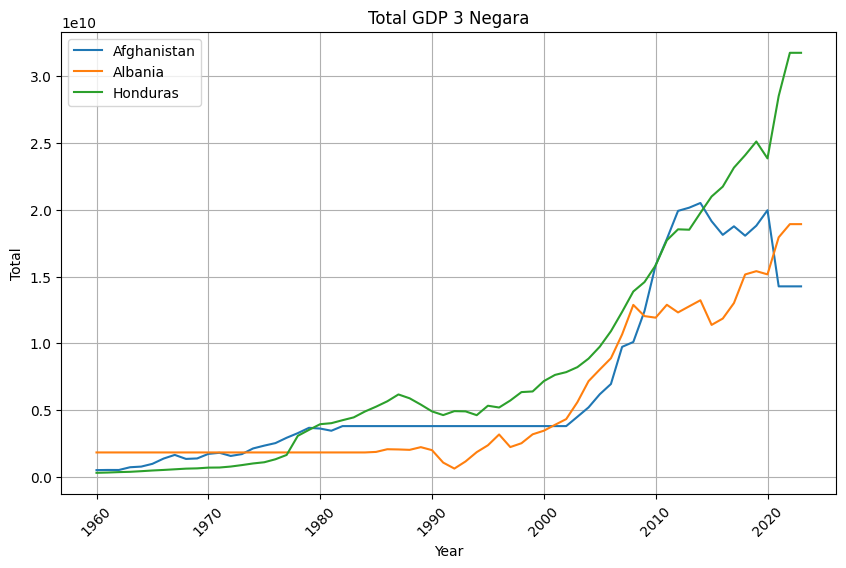

In [187]:
# Filter data untuk negara-negara yang diminta
countries = ['Afghanistan', 'Albania', 'Honduras']
df_cek_3_country = df_final[df_final['countryname'].isin(countries)]

# Plot data
plt.figure(figsize=(10, 6))
for country in countries:
    country_data = df_cek_3_country[df_cek_3_country['countryname'] == country]
    plt.plot(country_data['year'], country_data['gdp'], label=country)

# Menambahkan label dan judul
plt.xlabel('Year')
plt.ylabel('Total')
plt.title('Total GDP 3 Negara')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

# Menampilkan plot
plt.show()

#### 4.3.3.5 Scaled Dataset

In [188]:
# Membuat objek scaler
scaler = StandardScaler()

# Memilih kolom yang akan discaling
columns_to_scale = ['population', 'gdp', 'gdppercapita',
                    'ruralpopulationpercent', 'electricityaccesspercent', 'projectcost']

# Melakukan penskalaan menggunakan MaxAbsScaler
df_final_scaled = df_final.copy()
df_final_scaled[columns_to_scale] = scaler.fit_transform(df_final_scaled[columns_to_scale])
# Batasi jumlah angka di belakang koma menjadi maksimum 3 angka

df_final_scaled

countryname countrycode  year  population       gdp  gdppercapita  \
0      Afghanistan         AFG  1960   -0.291672 -0.201744     -0.398548   
1      Afghanistan         AFG  1961   -0.291437 -0.201742     -0.398545   
2      Afghanistan         AFG  1962   -0.291187 -0.201742     -0.398608   
3      Afghanistan         AFG  1963   -0.290924 -0.201702     -0.397724   
4      Afghanistan         AFG  1964   -0.290647 -0.201692     -0.397577   
...            ...         ...   ...         ...       ...           ...   
16955     Zimbabwe         ZWE  2019   -0.282262 -0.197509     -0.341492   
16956     Zimbabwe         ZWE  2020   -0.281822 -0.197573     -0.343555   
16957     Zimbabwe         ZWE  2021   -0.281369 -0.196208     -0.326716   
16958     Zimbabwe         ZWE  2022   -0.280912 -0.196408     -0.330792   
16959     Zimbabwe         ZWE  2023   -0.280912 -0.196408     -0.330792   

       ruralpopulationpercent  electricityaccesspercent  projectcost  
0                    1.679170                 -0.790447    -0.086398  
1                    1.668114                 -0.790447    -0.086398  
2                    1.656707                 -0.790447    -0.086398  
3                    1.644987                 -0.790447    -0.086398  
4                    1.632876                 -0.790447    -0.083357  
...                       ...                       ...          ...  
16955                0.749034                  0.264166    -0.086398  
16956                0.747784                  0.401196    -0.086398  
16957                0.745401                  0.316078    -0.086398  
16958                0.741807                 -0.790447    -0.086398  
16959               -1.899288                 -0.790447    -0.086398  

[16960 rows x 9 columns]

In [189]:
df_final_scaled.describe()

year    population           gdp  gdppercapita  \
count  16960.000000  1.696000e+04  1.696000e+04  1.696000e+04   
mean    1991.500000 -2.681293e-17 -2.010970e-17 -9.133155e-17   
std       18.473498  1.000029e+00  1.000029e+00  1.000029e+00   
min     1960.000000 -3.037234e-01 -2.018511e-01 -4.011659e-01   
25%     1975.750000 -3.023536e-01 -2.015039e-01 -3.756891e-01   
50%     1991.500000 -2.942182e-01 -1.995886e-01 -3.180100e-01   
75%     2007.250000 -2.387579e-01 -1.745576e-01 -7.176468e-02   
max     2023.000000  1.080929e+01  1.986227e+01  2.040391e+01   

       ruralpopulationpercent  electricityaccesspercent   projectcost  
count            1.696000e+04              1.696000e+04  1.696000e+04  
mean            -1.675808e-18             -2.429922e-17 -1.508228e-17  
std              1.000029e+00              1.000029e+00  1.000029e+00  
min             -1.899288e+00             -7.904467e-01 -8.639842e-02  
25%             -7.818576e-01             -7.904467e-01 -8.639842e-02  
50%              6.419719e-02             -7.904467e-01 -8.639842e-02  
75%              8.192073e-01              1.352624e+00 -8.639842e-02  
max              1.926227e+00              1.468692e+00  1.008985e+02

#### 4.3.3.6 Save to CSV

In [190]:
# Menyimpan DataFrame ke dalam file CSV
df_final.to_csv('../data_final/data_final.csv', index=False)
df_final_scaled.to_csv('../data_final/data_final_scaled.csv', index=False)

## 4.4 Load

### 4.4.1 Sqlite

#### 4.4.1.1 No Scaled

In [191]:
def load_csv_to_sqlite(csv_file, db_file):
    # Membuat koneksi ke database SQLite
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Membuat tabel jika belum ada
    c.execute('''CREATE TABLE IF NOT EXISTS data (
                    id INTEGER PRIMARY KEY,
                    country_name TEXT,
                    country_code TEXT,
                    year INTEGER,
                    population INTEGER,
                    gdp REAL,
                    gdp_per_capita REAL,
                    rural_population_percent REAL,
                    electricity_access_percent REAL,
                    project_cost REAL
                )''')

    # Membaca data dari CSV dan memasukkannya ke database
    with open(csv_file, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        for row in csv_reader:
            c.execute('''INSERT INTO data (
                            country_name,
                            country_code,
                            year,
                            population,
                            gdp,
                            gdp_per_capita,
                            rural_population_percent,
                            electricity_access_percent,
                            project_cost
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                        (
                            row['countryname'],
                            row['countrycode'],
                            int(row['year']),
                            int(row['population']),
                            float(row['gdp']),
                            float(row['gdppercapita']),
                            float(row['ruralpopulationpercent']),
                            float(row['electricityaccesspercent']),
                            float(row['projectcost'])
                        ))

    # Menyimpan perubahan dan menutup koneksi
    conn.commit()
    conn.close()

# Panggil fungsi untuk memuat data CSV ke database SQLite
load_csv_to_sqlite('../data_final/data_final.csv', '../data_final/data_final.db')

#### 4.4.1.2 Scaled

In [192]:
def load_csv_scaled_ro_sqlite(csv_file, db_file):
    # Membuat koneksi ke database SQLite
    conn = sqlite3.connect(db_file)
    c = conn.cursor()

    # Membuat tabel jika belum ada
    c.execute('''CREATE TABLE IF NOT EXISTS data (
                    id INTEGER PRIMARY KEY,
                    country_name TEXT,
                    country_code TEXT,
                    year INTEGER,
                    population REAL,
                    gdp REAL,
                    gdp_per_capita REAL,
                    rural_population_percent REAL,
                    electricity_access_percent REAL,
                    project_cost REAL
                )''')

    # Membaca data dari CSV dan memasukkannya ke database
    with open(csv_file, 'r', newline='', encoding='utf-8') as csvfile:
        csv_reader = csv.DictReader(csvfile)
        for row in csv_reader:
            c.execute('''INSERT INTO data (
                            country_name,
                            country_code,
                            year,
                            population,
                            gdp,
                            gdp_per_capita,
                            rural_population_percent,
                            electricity_access_percent,
                            project_cost
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                        (
                            row['countryname'],
                            row['countrycode'],
                            int(row['year']),
                            float(row['population']),
                            float(row['gdp']),
                            float(row['gdppercapita']),
                            float(row['ruralpopulationpercent']),
                            float(row['electricityaccesspercent']),
                            float(row['projectcost'])
                        ))

    # Menyimpan perubahan dan menutup koneksi
    conn.commit()
    conn.close()

# Panggil fungsi untuk memuat data CSV ke database SQLite
load_csv_scaled_ro_sqlite('../data_final/data_final_scaled.csv', '../data_final/data_final_scaled.db')

### 4.4.2 Cloud Storage

In [193]:
def upload_files_to_gcs(service_account_json, bucket_name, file_paths):
    # Inisialisasi client GCS
    client = storage.Client.from_service_account_json(service_account_json)
    
    # Iterasi melalui setiap file dan unggah ke GCS
    for local_path, gcs_filename in file_paths:
        # Membaca file CSV menjadi DataFrame
        df = pd.read_csv(local_path)
        
        # Mengunggah file ke GCS
        bucket = client.get_bucket(bucket_name)
        blob = bucket.blob(gcs_filename)
        blob.upload_from_filename(local_path)
        
        print(f"Berhasil Load to GCS dengan data: {gcs_filename} kedalam Bucket: {bucket_name}.")

# Contoh pemanggilan fungsi
service_account_json = 'serviceAccount.json'
bucket_name = "mini-project-data-engineer-bucket-nuri"
file_paths = [
    ("../data_final/data_final.csv", "data_final.csv"),
    ("../data_final/data_final_scaled.csv", "data_final_scaled.csv")
]

upload_files_to_gcs(service_account_json, bucket_name, file_paths)

Berhasil Load to GCS dengan data: data_final.csv kedalam Bucket: mini-project-data-engineer-bucket-nuri.
Berhasil Load to GCS dengan data: data_final_scaled.csv kedalam Bucket: mini-project-data-engineer-bucket-nuri.


### 4.4.3 Google Big Query

In [194]:
df_to_gbq = pd.read_csv('../data_final/data_final.csv')
df_to_gbq

countryname countrycode  year  population           gdp  gdppercapita  \
0      Afghanistan         AFG  1960     8622466  5.377778e+08     62.369375   
1      Afghanistan         AFG  1961     8790140  5.488889e+08     62.443703   
2      Afghanistan         AFG  1962     8969047  5.466667e+08     60.950364   
3      Afghanistan         AFG  1963     9157465  7.511112e+08     82.021738   
4      Afghanistan         AFG  1964     9355514  8.000000e+08     85.511073   
...            ...         ...   ...         ...           ...           ...   
16955     Zimbabwe         ZWE  2019    15354608  2.183223e+10   1421.868596   
16956     Zimbabwe         ZWE  2020    15669666  2.150970e+10   1372.696674   
16957     Zimbabwe         ZWE  2021    15993524  2.837124e+10   1773.920411   
16958     Zimbabwe         ZWE  2022    16320537  2.736663e+10   1676.821489   
16959     Zimbabwe         ZWE  2023    16320537  2.736663e+10   1676.821489   

       ruralpopulationpercent  electricityaccesspercent  projectcost  
0                      91.599                  0.000000          0.0  
1                      91.316                  0.000000          0.0  
2                      91.024                  0.000000          0.0  
3                      90.724                  0.000000          0.0  
4                      90.414                  0.000000    3500000.0  
...                       ...                       ...          ...  
16955                  67.790                 46.682095          0.0  
16956                  67.758                 52.747667          0.0  
16957                  67.697                 48.979927          0.0  
16958                  67.605                  0.000000          0.0  
16959                   0.000                  0.000000          0.0  

[16960 rows x 9 columns]

In [195]:
df_to_gbq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16960 entries, 0 to 16959
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   countryname               16960 non-null  object 
 1   countrycode               16960 non-null  object 
 2   year                      16960 non-null  int64  
 3   population                16960 non-null  int64  
 4   gdp                       16960 non-null  float64
 5   gdppercapita              16960 non-null  float64
 6   ruralpopulationpercent    16960 non-null  float64
 7   electricityaccesspercent  16960 non-null  float64
 8   projectcost               16960 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 1.2+ MB


In [ ]:
project_id = "mini-project-423106"

table_id = 'mini_project.data'

pandas_gbq.to_gbq(df_to_gbq, table_id, project_id=project_id)

# 5. Visualisasi dan Data Analysis Merged Dataset

## 5.1 Analisis menggunakan AI

In [197]:
load_dotenv()

api = os.getenv("OPEN_API_KEY")

client = OpenAI(
    api_key=api,
    base_url="https://api.naga.ac/v1"
    )

def generate(prompt, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    return response.choices[0].message.content

df_AI = pd.read_csv("../data_final/data_final.csv")

In [198]:
prompt = (f"Berikan analisis data dari dataset berikut: \n\n {df_AI}"
            "dari Kolom countryname, countrycode, year, gdp, population, gdppercapita, ruralpopulationpercent, electricityaccesspercent, dan projectcost"
            "buatkan visualisasi data yang informatif dan menarik."
            "analisis ini bisa berupa analisis statistik deskriptif, analisis korelasi, analisis distribusi, analisis tren, analisis perbandingan, atau analisis lain yang informatif."
            "gunakan teknik visualisasi untuk membuat analisis ini lebih menarik dan informatif."
          )

hasil = generate(prompt)
print(hasil)

Untuk membuat analisis yang informatif dan menarik dari dataset tersebut, kita bisa melakukan beberapa analisis sebagai berikut:

1. Analisis Statistik Deskriptif:
Kita dapat melakukan analisis statistik deskriptif untuk melihat ringkasan data dari kolom-kolom numerik seperti population, gdp, gdppercapita, ruralpopulationpercent, electricityaccesspercent, dan projectcost. Dengan demikian, kita bisa melihat rata-rata, median, standar deviasi, minimum, dan maksimum dari setiap kolom tersebut.

2. Analisis Korelasi:
Kita juga bisa melakukan analisis korelasi antara variabel-variabel numerik tersebut. Misalnya, apakah terdapat korelasi antara gdp per capita dengan tingkat akses listrik atau antara populasi dengan proyeksi biaya. Visualisasi yang cocok untuk analisis ini adalah heatmap korelasi.

3. Analisis Distribusi:
Melakukan analisis distribusi untuk melihat sebaran data dari variabel-variabel numerik tersebut. Kita bisa menggunakan histogram atau box plot untuk melihat distribusi data

In [199]:
prompt = (f"Berikan kode python untuk Visualisasinya dari \n\n {hasil} yang sudah diberikan tadi"
          )

hasil1 = generate(prompt)
print(hasil1)


Berikut adalah contoh kode Python untuk melakukan visualisasi dari analisis yang telah disebutkan di atas:

1. Analisis Statistik Deskriptif:
```python
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
data = pd.read_csv('dataset.csv')

# Analisis statistik deskriptif
numeric_cols = ['population', 'gdp', 'gdppercapita', 'ruralpopulationpercent', 'electricityaccesspercent', 'projectcost']
desc_stats = data[numeric_cols].describe()
print(desc_stats)
```

2. Analisis Korelasi:
```python
import seaborn as sns

# Analisis korelasi
correlation = data[numeric_cols].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()
```

3. Analisis Distribusi:
```python
# Analisis distribusi
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(numeric_cols):
    sns.histplot(data[col], kde=True, ax=axes[i//3, i%3])
plt.show()
```

4. Analisis Tren:
```python
# Analisis tren
time_series_cols = ['gdp', 'population', 'gdppercapita']
data['year'] = pd.to

In [223]:
# Daftar negara maju dari OECD
negara_maju = ['France', 'Germany', 'Italy', 'Japan', 'Netherlands', 'China','United Kingdom', 'United States']

In [224]:
# Daftar negara Asean dari OECD
negara_Asean = ['Indonesia', 'Philippines', 'Myanmar', 'Malaysia', 'Viet Nam', 'Lao PDR','Cambodia', 'Timor Leste', 'Brunei Darussalam', 'Singapore']

## 5.2 Analisis Deskriptif & Korelasi

### 5.2.1 Deskriptif

In [200]:
# Analisis Statistik Deskriptif
numerical_cols = ['gdp', 'population', 'gdppercapita', 'ruralpopulationpercent', 'electricityaccesspercent', 'projectcost']
desc_stats = df_AI[numerical_cols].describe()
desc_stats

gdp    population   gdppercapita  ruralpopulationpercent  \
count  1.696000e+04  1.696000e+04   16960.000000            16960.000000   
mean   1.014879e+12  2.173028e+08    9558.649293               48.616723   
std    5.028005e+12  7.154841e+08   23827.873768               25.598093   
min    0.000000e+00  0.000000e+00       0.000000                0.000000   
25%    1.745746e+09  9.800070e+05     607.040869               28.603250   
50%    1.137549e+10  6.800591e+06    1981.370199               50.260000   
75%    1.372278e+11  4.648039e+07    7848.699911               69.586250   
max    1.008796e+14  7.950947e+09  495726.217533               97.923000   

       electricityaccesspercent   projectcost  
count              16960.000000  1.696000e+04  
mean                  34.988861  9.941881e+07  
std                   44.265971  1.150736e+09  
min                    0.000000  0.000000e+00  
25%                    0.000000  0.000000e+00  
50%                    0.000000  0.000000e+00  
75%                   94.862331  0.000000e+00  
max                  100.000000  1.162035e+11

#### a. GDP

In [271]:
fig = px.box(df_AI, y='gdp', title='Statistik dari gdp')
fig.show()

#### b. Population

In [272]:
fig = px.box(df_AI, y='population', title='Statistik dari population')
fig.show()

#### c. GDP Percapita

In [273]:
fig = px.box(df_AI, y='gdppercapita', title='Statistik dari gdppercapita')
fig.show()

#### d. Akses Listrik

In [274]:
fig = px.box(df_AI, y='electricityaccesspercent', title='Statistik dari electricityaccesspercent')
fig.show()

#### e. Populasi Pedesaan

In [275]:
fig = px.box(df_AI, y='ruralpopulationpercent', title='Statistik dari ruralpopulationpercent')
fig.show()

#### f. Project Cost

In [270]:
fig = px.box(df_AI, y='projectcost', title='Statistik dari projectcost')
fig.show()

### 5.2.2 Korelasi

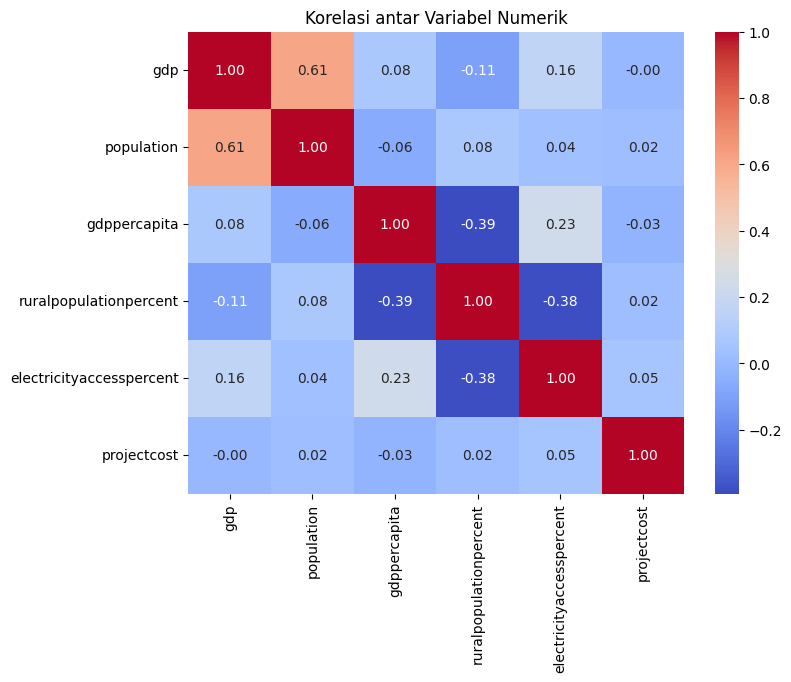

In [201]:
# Melakukan visualisasi menggunakan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(df_AI[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Korelasi antar Variabel Numerik")
plt.show()

## 5.3 Analisis Distribusi

In [202]:
# Membuat histogram untuk masing-masing variabel numerik
fig = go.Figure()

for col in numerical_cols:
    fig.add_trace(go.Histogram(x=df_AI[col], name=col, histnorm='probability'))

fig.update_layout(title='Distribusi Variabel Numerik',
                  xaxis_title='Nilai',
                  yaxis_title='Proporsi',
                  barmode='overlay')

fig.show()

### 5.3.1 Distribusi Project Cost Berdasarkan Negara

In [225]:
fig = px.pie(df_AI[df_AI['countryname'].isin(negara_maju)], values='projectcost', names='countryname', title='Distribusi Project Cost berdasarkan Negara')
fig.show()

In [226]:
fig = px.pie(df_AI[df_AI['countryname'].isin(negara_Asean)], values='projectcost', names='countryname', title='Distribusi Project Cost berdasarkan Negara')
fig.show()

## 5.4 Analisis Tren berdasarkan Negara Maju & Asean

### 5.4.1 GDP

In [203]:
# Membuat plot tren untuk semua negara maju dalam satu plot dengan warna garis yang berbeda menggunakan Plotly
fig = px.line(df_AI[df_AI['countryname'].isin(negara_maju)], x='year', y='gdp', color='countryname', 
              title='Tren Gross Domestic Bruto di Negara Maju dari tahun ke tahun',
              labels={'year': 'Tahun', 'gdp': 'Nilai', 'countryname': 'Negara'})
fig.show()


In [204]:
# Membuat plot tren untuk semua negara Asean dalam satu plot dengan warna garis yang berbeda menggunakan Plotly
fig = px.line(df_AI[df_AI['countryname'].isin(negara_Asean)], x='year', y='gdp', color='countryname', 
              title='Tren Gross Domestic Bruto di Negara Asean dari tahun ke tahun',
              labels={'year': 'Tahun', 'gdp': 'Nilai', 'countryname': 'Negara'})
fig.show()


### 5.4.2 GDP per Capita

In [205]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_maju)], x='year', y='gdppercapita', color='countryname', 
              title='Tren GDP Per Capita di Negara Maju dari tahun ke tahun',
              labels={'year': 'Tahun', 'gdppercapita': 'Nilai', 'countryname': 'Negara'})
fig.show()

In [206]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_Asean)], x='year', y='gdppercapita', color='countryname', 
              title='Tren GDP Per Capita di Negara Asean dari tahun ke tahun',
              labels={'year': 'Tahun', 'gdppercapita': 'Nilai', 'countryname': 'Negara'})
fig.show()

### 5.4.3 Population

In [207]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_maju)], x='year', y='population', color='countryname', 
              title='Tren Populasi di Negara Maju dari tahun ke tahun',
              labels={'year': 'Tahun', 'population': 'Nilai', 'countryname': 'Negara'})
fig.show()

In [208]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_Asean)], x='year', y='population', color='countryname', 
              title='Tren Populasi di Negara Asean dari tahun ke tahun',
              labels={'year': 'Tahun', 'population': 'Nilai', 'countryname': 'Negara'})
fig.show()

### 5.4.4 Populasi Pedesaan

In [209]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_maju)], x='year', y='ruralpopulationpercent', color='countryname', 
              title='Tren Populasi Pedesaan di Negara Maju dari tahun ke tahun',
              labels={'year': 'Tahun', 'ruralpopulationpercent': 'Nilai', 'countryname': 'Negara'})
fig.show()

In [210]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_Asean)], x='year', y='ruralpopulationpercent', color='countryname', 
              title='Tren Populasi Pedesaan di Negara Asean dari tahun ke tahun',
              labels={'year': 'Tahun', 'ruralpopulationpercent': 'Nilai', 'countryname': 'Negara'})
fig.show()

### 5.4.5 Electricity Access Percent

In [211]:
# Analisis Tren
fig = px.line(df_AI[df_AI['countryname'].isin(negara_maju)], x='year', y='electricityaccesspercent', color='countryname', 
              title='Tren Akses Listrik dalam % di Negara Maju dari tahun ke tahun',
              labels={'year': 'Tahun', 'electricityaccesspercent': 'Nilai', 'countryname': 'Negara'})
fig.show()

In [212]:
fig = px.line(df_AI[df_AI['countryname'].isin(negara_Asean)], x='year', y='electricityaccesspercent', color='countryname', 
              title='Tren Akses Listrik dalam % di Negara Asean dari tahun ke tahun',
              labels={'year': 'Tahun', 'electricityaccesspercent': 'Nilai', 'countryname': 'Negara'})
fig.show()

# 6. Visualisasi & Analisis 'project_data.csv'

In [ ]:
project_data_df

id                    regionname                      countryname  \
0     P161364                        Africa      Federal Republic of Nigeria   
1     P154525                    South Asia                Republic of India   
2     P159712                    South Asia     Islamic Republic of Pakistan   
4     P159692  Middle East and North Africa                Lebanese Republic   
5     P165558  Middle East and North Africa             Republic of Djibouti   
...       ...                           ...                              ...   
3480  P006043   Latin America and Caribbean               Argentine Republic   
3481  P041887                    South Asia  People's Republic of Bangladesh   
3483  P034154                        Africa                 State of Eritrea   
3484  P005920   Latin America and Caribbean               Argentine Republic   
3485  P049706  Middle East and North Africa      Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
0                             Nigeria For Women Project        2018-06-27   
1             Uttarakhand Workforce Development Project        2018-06-19   
2                            Sindh Solar Energy Project        2018-06-14   
4              Land Administration System Modernization        2018-06-08   
5     Djibouti Support for Women and Youth Entrepren...        2018-06-08   
...                                                 ...               ...   
3480       Renewable Energy in the Rural Market Project        1999-03-30   
3481                                 Municipal Services        1999-03-16   
3483                       Ports Rehabilitation Project        1997-11-18   
3484     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
3485                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate  lendprojectcost  \
0     2023-05-31      100000000.0   
1     2023-06-30       92500000.0   
2     2023-09-29      105000000.0   
4     2023-12-31       43000000.0   
5     2023-12-31       15000000.0   
...          ...              ...   
3480  2012-12-31      120500000.0   
3481  2012-06-30      200000000.0   
3483  2011-12-31       36600000.0   
3484  2014-12-30       30000000.0   
3485  2012-12-31        3800000.0   

                                               location  Active  Closed  
0     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0  
1     Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0  
2     Thatta District;Thar Parkar District;Tando Muh...       1       0  
4                                               Lebanon       1       0  
5                                  Republic of Djibouti       1       0  
...                                                 ...     ...     ...  
3480  Provincia de Entre Ros;Provincia de Corrientes...       0       1  
3481  Thakurgaon;Tungi;Sylhet;Godagari;Rajshahi;Pati...       0       1  
3483                        Massawa;Hirgigo;Assab Wedeb       0       1  
3484                                       Buenos Aires       0       1  
3485                              Muhafazat Amman;Amman       0       1  

[3140 rows x 10 columns]

In [ ]:
project_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3140 entries, 0 to 3485
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 3140 non-null   category      
 1   regionname         3140 non-null   category      
 2   countryname        3140 non-null   category      
 3   project_name       3140 non-null   category      
 4   boardapprovaldate  3140 non-null   datetime64[ns]
 5   closingdate        3140 non-null   datetime64[ns]
 6   lendprojectcost    3140 non-null   float64       
 7   location           3140 non-null   category      
 8   Active             3140 non-null   int32         
 9   Closed             3140 non-null   int32         
dtypes: category(5), datetime64[ns](2), float64(1), int32(2)
memory usage: 557.0 KB


In [215]:
project_data_df.to_csv('../data_final/data_project_beta_version.csv', index=False)

## 6.1 Analisis Menggunakan AI

In [257]:
load_dotenv()

api = os.getenv("OPEN_API_KEY")

client = OpenAI(
    api_key=api,
    base_url="https://api.naga.ac/v1"
    )

def generate(prompt, model="gpt-3.5-turbo"):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt,
            },
        ],
    )

    return response.choices[0].message.content

df_AI_project = pd.read_csv("../data_final/data_project_beta_version.csv")

In [217]:
prompt = (f"Berikan analisis data dari dataset berikut: \n\n {df_AI_project}"
            "dari kolom-kolom yang tersedia"
            "buatkan visualisasi data yang informatif dan menarik."
            "analisis ini bisa berupa analisis statistik deskriptif, analisis korelasi, analisis distribusi, analisis tren, analisis perbandingan, atau analisis lain yang informatif."
            "gunakan teknik visualisasi untuk membuat analisis ini lebih menarik dan informatif."
          )

output = generate(prompt)
print(output)

Untuk membuat analisis data yang informatif dan menarik dari dataset tersebut, kita dapat menggunakan teknik visualisasi seperti diagram batang, diagram lingkaran, dan diagram garis. Berikut adalah beberapa analisis yang dapat dilakukan:

1. Analisis perbandingan antara regionname dan lendprojectcost
   - Dapat dibuat diagram batang atau diagram lingkaran untuk menunjukkan perbandingan jumlah proyek dan biaya proyek berdasarkan regionname.

2. Analisis distribusi lendprojectcost
   - Dapat digunakan histogram atau box plot untuk menunjukkan distribusi lendprojectcost di seluruh proyek.

3. Analisis tren dari waktu (boardapprovaldate dan closingdate) terhadap jumlah proyek dan biaya proyek
   - Dapat digunakan diagram garis untuk menunjukkan tren jumlah proyek atau biaya proyek setiap tahun.

4. Analisis korelasi antara lendprojectcost dan Active/Closed
   - Dapat digunakan scatter plot untuk menunjukkan hubungan antara lendprojectcost dan status (Active/Closed) proyek.

5. Analisis sta

In [219]:
prompt = (f"Berikan kode program dari hasil output yang tadi diberikan \n\n {output} menggunakan plotly"
          )

hasil_1 = generate(prompt)
print(hasil_1)

import plotly.express as px
import pandas as pd

# Create a DataFrame from the given data
data = {
    'regionname': ['Asia', 'Africa', 'Europe', 'Americas'],
    'lendprojectcost': [5000000, 3000000, 7000000, 4000000]
}
df = pd.DataFrame(data)

# Create a bar chart to compare lendprojectcost by regionname
fig = px.bar(df, x='regionname', y='lendprojectcost', title='Comparison of lendprojectcost by regionname')
fig.show()

# Create a pie chart to show the distribution of lendprojectcost by regionname
fig = px.pie(df, values='lendprojectcost', names='regionname', title='Distribution of lendprojectcost by regionname')
fig.show()

# Create a histogram to show the distribution of lendprojectcost
fig = px.histogram(df, x='lendprojectcost', title='Distribution of lendprojectcost')
fig.show()

# Create a line chart to show the trend of lendprojectcost over time
# Assuming we have a DataFrame df_time with columns 'boardapprovaldate', 'closingdate', 'lendprojectcost'
fig = px.line(df_time, x='b

## 6.2 Analisis Perbandingan

In [246]:
fig = px.bar(df_AI_project, x='regionname', y='lendprojectcost', title='Perbandingan dari Project Cost berdasarkan Region Negara')
fig.show()

## 6.3 Analisis Distribusi

In [247]:
fig = px.pie(df_AI_project, values='lendprojectcost', names='regionname', title='Distribusi Project Cost berdasarkan Region Negara')
fig.show()

In [248]:
fig = px.histogram(df_AI_project, x='lendprojectcost', title='Distribusi dari lendprojectcost')
fig.show()

## 6.4 Analisis Tren

In [249]:
fig = px.line(df_AI_project, x='boardapprovaldate', y='lendprojectcost', title='Tren dari lendprojectcost Tiap waktunya',
              line_shape='spline', markers=True)
fig.show()

## 6.5 Analisis Korelasi

In [262]:
dummies = pd.get_dummies(df_AI_project[['Active', 'Closed']])
dummies

Active  Closed
0          1       0
1          1       0
2          1       0
3          1       0
4          1       0
...      ...     ...
3135       0       1
3136       0       1
3137       0       1
3138       0       1
3139       0       1

[3140 rows x 2 columns]

In [266]:
df_AI_project['status'] = pd.from_dummies(df_AI_project[['Active', 'Closed']])
df_AI_project

id                    regionname                      countryname  \
0     P161364                        Africa      Federal Republic of Nigeria   
1     P154525                    South Asia                Republic of India   
2     P159712                    South Asia     Islamic Republic of Pakistan   
3     P159692  Middle East and North Africa                Lebanese Republic   
4     P165558  Middle East and North Africa             Republic of Djibouti   
...       ...                           ...                              ...   
3135  P006043   Latin America and Caribbean               Argentine Republic   
3136  P041887                    South Asia  People's Republic of Bangladesh   
3137  P034154                        Africa                 State of Eritrea   
3138  P005920   Latin America and Caribbean               Argentine Republic   
3139  P049706  Middle East and North Africa      Hashemite Kingdom of Jordan   

                                           project_name boardapprovaldate  \
0                             Nigeria For Women Project        2018-06-27   
1             Uttarakhand Workforce Development Project        2018-06-19   
2                            Sindh Solar Energy Project        2018-06-14   
3              Land Administration System Modernization        2018-06-08   
4     Djibouti Support for Women and Youth Entrepren...        2018-06-08   
...                                                 ...               ...   
3135       Renewable Energy in the Rural Market Project        1999-03-30   
3136                                 Municipal Services        1999-03-16   
3137                       Ports Rehabilitation Project        1997-11-18   
3138     Reduction of Ozone Project (Montreal Protocol)        1997-01-09   
3139                                JO: ODS PHASEOUT II        1996-10-06   

     closingdate  lendprojectcost  \
0     2023-05-31      100000000.0   
1     2023-06-30       92500000.0   
2     2023-09-29      105000000.0   
3     2023-12-31       43000000.0   
4     2023-12-31       15000000.0   
...          ...              ...   
3135  2012-12-31      120500000.0   
3136  2012-06-30      200000000.0   
3137  2011-12-31       36600000.0   
3138  2014-12-30       30000000.0   
3139  2012-12-31        3800000.0   

                                               location  Active  Closed  \
0     Ogun State;Niger State;Abia State;Edo;Kebbi St...       1       0   
1     Uttarkashi;TehriGarhwal;Pithoragarh;Naini Tal;...       1       0   
2     Thatta District;Thar Parkar District;Tando Muh...       1       0   
3                                               Lebanon       1       0   
4                                  Republic of Djibouti       1       0   
...                                                 ...     ...     ...   
3135  Provincia de Entre Ros;Provincia de Corrientes...       0       1   
3136  Thakurgaon;Tungi;Sylhet;Godagari;Rajshahi;Pati...       0       1   
3137                        Massawa;Hirgigo;Assab Wedeb       0       1   
3138                                       Buenos Aires       0       1   
3139                              Muhafazat Amman;Amman       0       1   

      status  
0     Active  
1     Active  
2     Active  
3     Active  
4     Active  
...      ...  
3135  Closed  
3136  Closed  
3137  Closed  
3138  Closed  
3139  Closed  

[3140 rows x 11 columns]

In [268]:
fig = px.scatter(df_AI_project, x='lendprojectcost', y='status', title='Korelasi antara lendprojectcost dan status')
fig.show()

## 6.6 Analisis Statistik

In [269]:
fig = px.box(df_AI_project, y='lendprojectcost', title='Statistik dari lendprojectcost')
fig.show()